---
## 1. 导入库

首先，我们导入所需的库：

- **numpy**: 数值计算的基础库
- **matplotlib**: 可视化库
- **cv2 (OpenCV)**: 计算机视觉库，用于图像对齐和变换
- **skimage (scikit-image)**: 图像处理库，用于分割和特征提取
- **scipy**: 科学计算库，用于距离计算和优化

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# OpenCV - 图像对齐和仿射变换
import cv2

# scikit-image - 图像处理
from skimage import io, filters, measure, morphology
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# scipy - 距离计算和优化
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from scipy import ndimage

# 设置中文字体（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("库导入成功!")
print(f"OpenCV version: {cv2.__version__}")

库导入成功!
OpenCV version: 4.12.0


---
## 2. 图像读取与基本操作

### skimage.io.imread vs cv2.imread

| 特性 | skimage.io.imread | cv2.imread |
|------|-------------------|------------|
| 颜色顺序 | RGB | BGR |
| 数据类型 | 取决于图像 | uint8 |
| 灵活性 | 高 | 中 |

我们的脚本使用 `skimage.io.imread`，因为它返回 RGB 格式，与 matplotlib 兼容。

成功读取图像！
Tetrad 平板路径: /hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/6d/242_tyw3_6d_#1_202510.cropped.png
HYG 平板路径: /hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/242_tyw3_HYG_#1_202510.cropped.png


/tmp/ipykernel_1714547/4142433100.py:26: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4142433100.py:26: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4142433100.py:26: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4142433100.py:26: UserWarning: Glyph 31579 (\N{CJK UNIFIED IDEOGRAPH-7B5B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4142433100.py:26: UserWarning: Glyph 36873 (\N{CJK UNIFIED IDEOGRAPH-9009}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

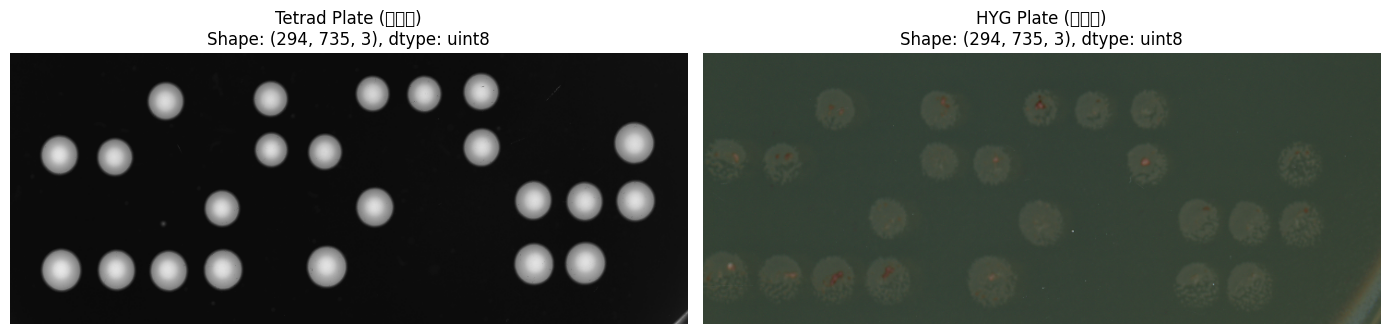

In [21]:
# 定义真实图像路径
TETRAD_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/6d/242_tyw3_6d_#1_202510.cropped.png"  # 基准图 (黑底)
HYG_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/242_tyw3_HYG_#1_202510.cropped.png"    # 筛选图 (绿底/胶底)

# 读取真实图像
from skimage import io

tetrad_plate = io.imread(TETRAD_PATH)
hyg_plate = io.imread(HYG_PATH)

print(f"成功读取图像！")
print(f"Tetrad 平板路径: {TETRAD_PATH}")
print(f"HYG 平板路径: {HYG_PATH}")

# 显示两张图像
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(tetrad_plate)
axes[0].set_title(f'Tetrad Plate (基准图)\nShape: {tetrad_plate.shape}, dtype: {tetrad_plate.dtype}')
axes[0].axis('off')

axes[1].imshow(hyg_plate)
axes[1].set_title(f'HYG Plate (筛选图)\nShape: {hyg_plate.shape}, dtype: {hyg_plate.dtype}')
axes[1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

# 为后续演示使用 tetrad_plate 作为主要示例
sample_plate = tetrad_plate.copy()

---
## 3. 灰度转换

### 为什么需要灰度图？

大多数图像分割算法需要单通道（灰度）输入。将 RGB 转换为灰度的常用方法：

1. **取平均值**: `gray = (R + G + B) / 3`
2. **加权平均** (模拟人眼): `gray = 0.299*R + 0.587*G + 0.114*B`
3. **取单个通道**: 适用于特定颜色背景

### 在我们的脚本中：
- **Tetrad 平板**: 使用平均值 `np.mean(img, axis=2)`
- **HYG 平板**: 使用红色通道 `img[:, :, 0]`（因为绿色背景在红色通道中较暗）

/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 32511 (\N{CJK UNIFIED IDEOGRAPH-7EFF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 24213 (\N{CJK UNIFIED IDEOGRAPH-5E95}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 27492 (\N{CJK UNIFIED IDEOGRAPH-6B64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/4215411399.py:47: UserWarning: Glyph 26368 (\N{CJK UN

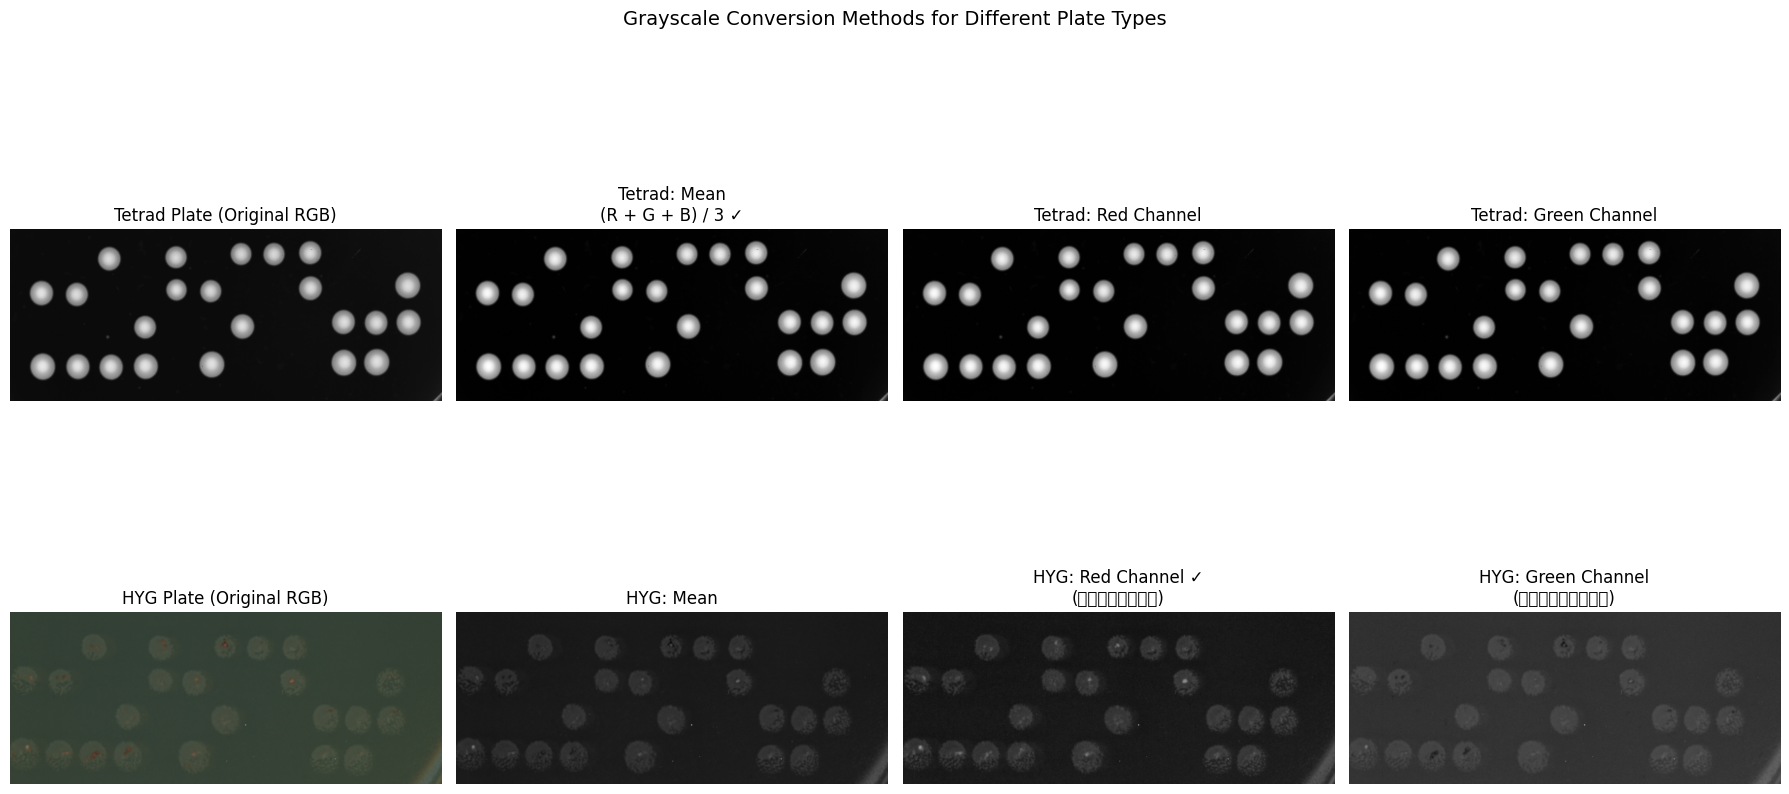


总结:
- Tetrad 平板 (黑底): 使用 np.mean() 取平均值效果最好
- HYG 平板 (绿底): 使用红色通道 img[:,:,0] 效果最好
  因为绿色背景在红色通道中显示为暗色，而白色菌落保持亮色，对比度更高！



In [22]:
# 演示不同的灰度转换方法 - 使用两种真实平板图像
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# ===== Tetrad 平板 (黑底) =====
axes[0, 0].imshow(tetrad_plate)
axes[0, 0].set_title('Tetrad Plate (Original RGB)')
axes[0, 0].axis('off')

# 方法1: 取平均值 - 适合 Tetrad
gray_tetrad_mean = np.mean(tetrad_plate, axis=2)
axes[0, 1].imshow(gray_tetrad_mean, cmap='gray')
axes[0, 1].set_title('Tetrad: Mean\n(R + G + B) / 3 ✓')
axes[0, 1].axis('off')

# 红色通道
axes[0, 2].imshow(tetrad_plate[:, :, 0], cmap='gray')
axes[0, 2].set_title('Tetrad: Red Channel')
axes[0, 2].axis('off')

# 绿色通道
axes[0, 3].imshow(tetrad_plate[:, :, 1], cmap='gray')
axes[0, 3].set_title('Tetrad: Green Channel')
axes[0, 3].axis('off')

# ===== HYG 平板 (绿底) =====
axes[1, 0].imshow(hyg_plate)
axes[1, 0].set_title('HYG Plate (Original RGB)')
axes[1, 0].axis('off')

# 方法1: 取平均值
gray_hyg_mean = np.mean(hyg_plate, axis=2)
axes[1, 1].imshow(gray_hyg_mean, cmap='gray')
axes[1, 1].set_title('HYG: Mean')
axes[1, 1].axis('off')

# 红色通道 - 适合 HYG (绿色背景在红色通道中较暗)
axes[1, 2].imshow(hyg_plate[:, :, 0], cmap='gray')
axes[1, 2].set_title('HYG: Red Channel ✓\n(绿底在此通道最暗)')
axes[1, 2].axis('off')

# 绿色通道
axes[1, 3].imshow(hyg_plate[:, :, 1], cmap='gray')
axes[1, 3].set_title('HYG: Green Channel\n(菌落与背景难以区分)')
axes[1, 3].axis('off')

plt.suptitle('Grayscale Conversion Methods for Different Plate Types', fontsize=14)
plt.tight_layout()
plt.show()

print("""
总结:
- Tetrad 平板 (黑底): 使用 np.mean() 取平均值效果最好
- HYG 平板 (绿底): 使用红色通道 img[:,:,0] 效果最好
  因为绿色背景在红色通道中显示为暗色，而白色菌落保持亮色，对比度更高！
""")

---
## 4. 高斯模糊

### 什么是高斯模糊？

高斯模糊是一种**低通滤波器**，用于：
- 平滑图像
- 减少噪声
- 去除细小细节

### 高斯核 (Gaussian Kernel)

$$G(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}$$

其中 $\sigma$ (sigma) 是标准差，控制模糊程度：
- **小 sigma (0.5-1)**: 轻微模糊，保留细节
- **大 sigma (2-5)**: 强模糊，去除更多噪声

### 在脚本中的使用
```python
from skimage.filters import gaussian
blurred = gaussian(gray, sigma=1.0, preserve_range=True)
```

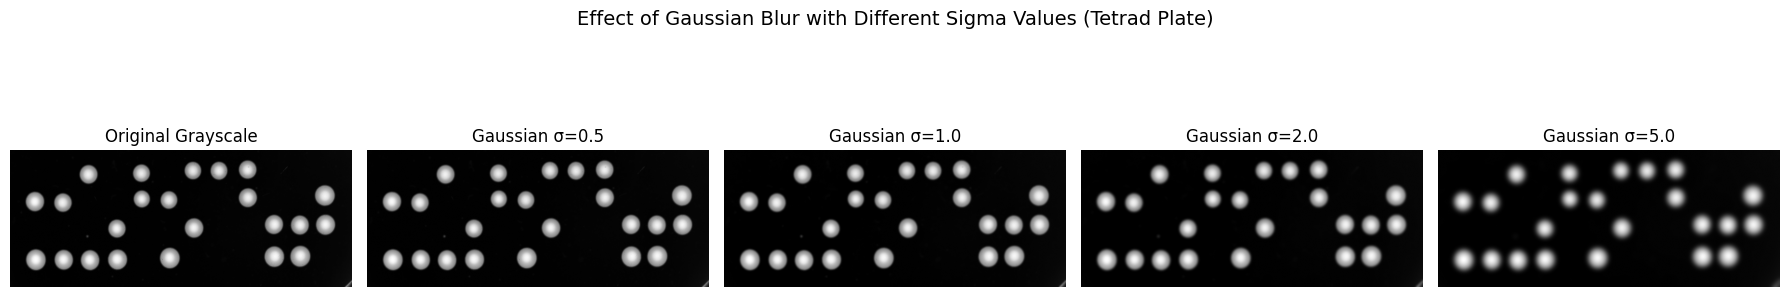

总结:
- σ=0.5: 适合 HYG 平板，保留更多细节
- σ=1.0: 适合 Tetrad 平板，平衡噪声和细节
- σ>2.0: 过度模糊，可能丢失小菌落


In [23]:
from skimage.filters import gaussian

# 使用 Tetrad 平板的灰度图
gray = np.mean(tetrad_plate, axis=2)

# 不同 sigma 值的效果
sigmas = [0.5, 1.0, 2.0, 5.0]

fig, axes = plt.subplots(1, len(sigmas) + 1, figsize=(18, 4))

# 原始灰度图
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Original Grayscale')
axes[0].axis('off')

# 不同 sigma 的高斯模糊
for i, sigma in enumerate(sigmas):
    blurred = gaussian(gray, sigma=sigma, preserve_range=True)
    axes[i + 1].imshow(blurred, cmap='gray')
    axes[i + 1].set_title(f'Gaussian σ={sigma}')
    axes[i + 1].axis('off')

plt.suptitle('Effect of Gaussian Blur with Different Sigma Values (Tetrad Plate)', fontsize=14)
plt.tight_layout()
plt.show()

print("""总结:
- σ=0.5: 适合 HYG 平板，保留更多细节
- σ=1.0: 适合 Tetrad 平板，平衡噪声和细节
- σ>2.0: 过度模糊，可能丢失小菌落""")

---
## 5. 阈值分割 (Otsu)

### 什么是阈值分割？

将灰度图转换为二值图（黑白）：
- 像素值 > 阈值 → 白色 (前景/菌落)
- 像素值 ≤ 阈值 → 黑色 (背景)

### Otsu 方法

**自动**计算最佳阈值，使得前景和背景的**类间方差最大化**。

$$\sigma_B^2(t) = \omega_0(t)\omega_1(t)[\mu_0(t) - \mu_1(t)]^2$$

优点：
- 无需手动设置阈值
- 对双峰直方图效果最好

Otsu 自动计算的阈值: 84.9


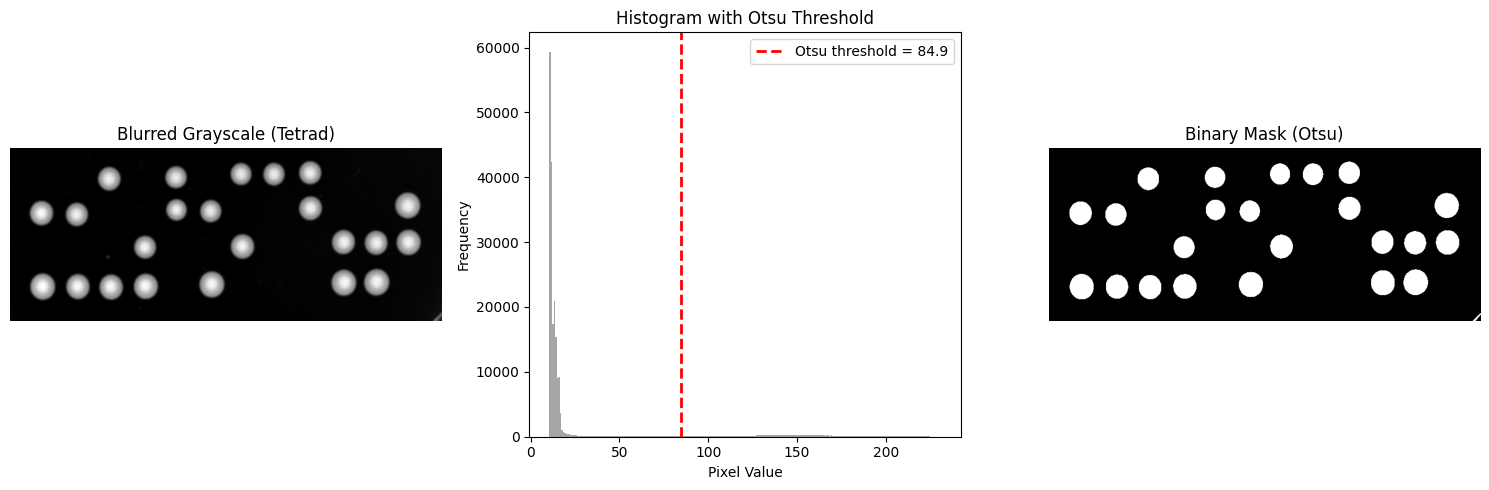

In [24]:
from skimage.filters import threshold_otsu

# 使用 Tetrad 平板
gray = np.mean(tetrad_plate, axis=2)

# 先进行高斯模糊
blurred = gaussian(gray, sigma=1.0, preserve_range=True)

# Otsu 阈值
thresh_val = threshold_otsu(blurred)
print(f"Otsu 自动计算的阈值: {thresh_val:.1f}")

# 二值化
binary_mask = blurred > thresh_val

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 灰度图
axes[0].imshow(blurred, cmap='gray')
axes[0].set_title('Blurred Grayscale (Tetrad)')
axes[0].axis('off')

# 直方图 + 阈值线
axes[1].hist(blurred.ravel(), bins=256, color='gray', alpha=0.7)
axes[1].axvline(thresh_val, color='red', linestyle='--', linewidth=2, label=f'Otsu threshold = {thresh_val:.1f}')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram with Otsu Threshold')
axes[1].legend()

# 二值化结果
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Binary Mask (Otsu)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

---
## 6. 形态学操作

形态学操作用于处理二值图像的形状：

### 常用操作

| 操作 | 英文 | 效果 |
|------|------|------|
| 膨胀 | Dilation | 扩大白色区域 |
| 腐蚀 | Erosion | 缩小白色区域 |
| 开运算 | Opening | 腐蚀 → 膨胀（去除小白点） |
| 闭运算 | Closing | 膨胀 → 腐蚀（填充小黑洞） |

### 结构元素 (Structuring Element)

定义操作的形状和大小，常用的有：
- `morphology.disk(r)`: 圆形，半径 r
- `morphology.square(n)`: 方形，边长 n

/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 32553 (\N{CJK UNIFIED IDEOGRAPH-7F29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2556896030.py:30: UserWarning: Glyph 25193 (\N{CJK UN

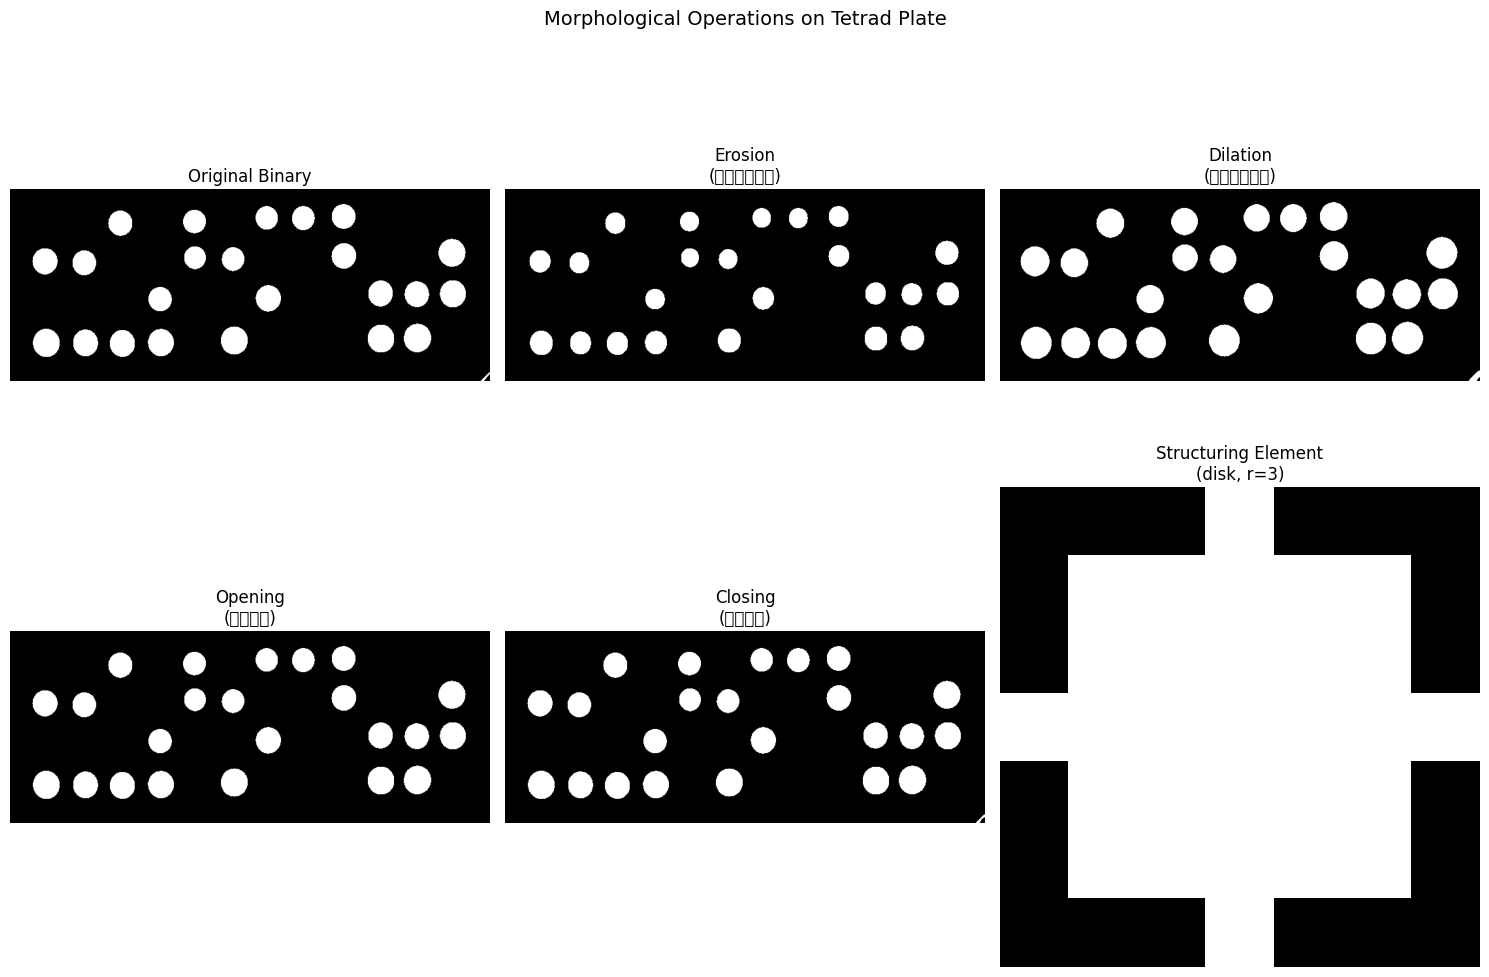

在脚本中:
mask = morphology.binary_opening(mask, morphology.disk(3))

开运算 (Opening) 用于去除由噪声产生的小白点，同时保持菌落的基本形状。


In [25]:
from skimage import morphology

# 创建结构元素
selem = morphology.disk(3)  # 半径为 3 的圆盘

# 各种形态学操作
eroded = morphology.binary_erosion(binary_mask, selem)
dilated = morphology.binary_dilation(binary_mask, selem)
opened = morphology.binary_opening(binary_mask, selem)  # 先腐蚀后膨胀
closed = morphology.binary_closing(binary_mask, selem)  # 先膨胀后腐蚀

# 可视化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

operations = [
    (binary_mask, 'Original Binary'),
    (eroded, 'Erosion\n(缩小白色区域)'),
    (dilated, 'Dilation\n(扩大白色区域)'),
    (opened, 'Opening\n(去除噪点)'),
    (closed, 'Closing\n(填充小洞)'),
    (selem, 'Structuring Element\n(disk, r=3)')
]

for ax, (img, title) in zip(axes.flat, operations):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.suptitle('Morphological Operations on Tetrad Plate', fontsize=14)
plt.tight_layout()
plt.show()

print("""在脚本中:
mask = morphology.binary_opening(mask, morphology.disk(3))

开运算 (Opening) 用于去除由噪声产生的小白点，同时保持菌落的基本形状。""")

/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 33104 (\N{CJK UNIFIED IDEOGRAPH-8150}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 34432 (\N{CJK UNIFIED IDEOGRAPH-8680}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3275349251.py:94: UserWarning: Glyph 36793 (\N{CJK UN

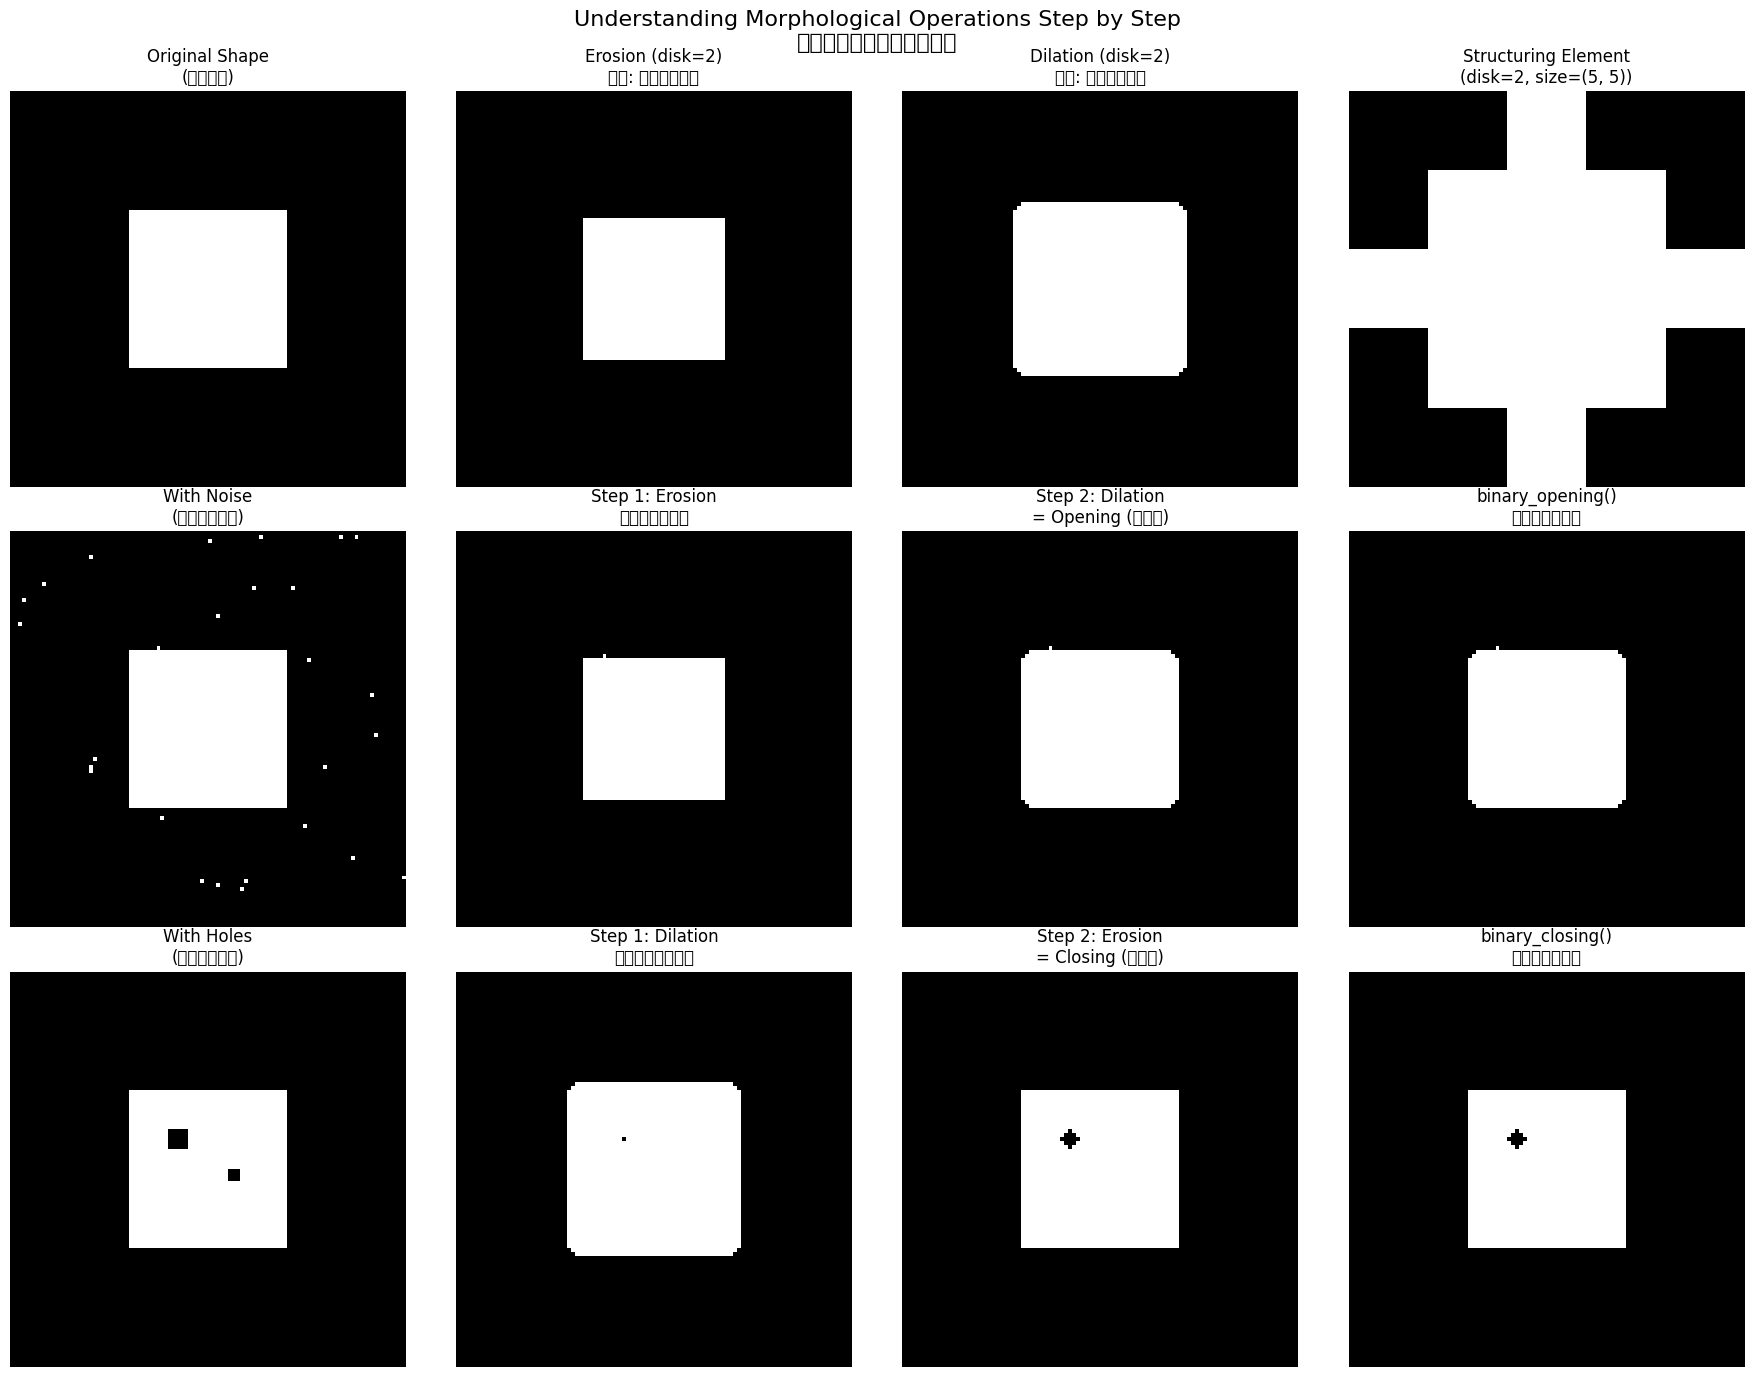


形态学操作总结:

1. 腐蚀 (Erosion):
   - 作用: 缩小白色区域，扩大黑色区域
   - 原理: 只有当结构元素完全在白色区域内时，中心像素才保留为白色
   - 效果: 去除小的白色噪点，使物体边缘向内收缩

2. 膨胀 (Dilation):
   - 作用: 扩大白色区域，缩小黑色区域
   - 原理: 只要结构元素与白色区域有任何重叠，中心像素就变为白色
   - 效果: 填充小的黑色洞，使物体边缘向外扩张

3. 开运算 (Opening) = 腐蚀 + 膨胀:
   - 作用: 去除小的白色噪点，同时大致保持物体大小
   - 在菌落检测中: 去除图像中的小杂点，保留真正的菌落

4. 闭运算 (Closing) = 膨胀 + 腐蚀:
   - 作用: 填充小的黑色洞，同时大致保持物体大小
   - 在菌落检测中: 填充菌落内部的小空洞

5. 结构元素 (Structuring Element):
   - morphology.disk(r): 圆形，半径为 r
   - morphology.square(n): 正方形，边长为 n
   - 大小决定了操作的"强度"：越大，去除的噪点/洞越大



In [26]:
# ============================================================
# 深入理解形态学操作的工作原理
# ============================================================

# 为了更清晰地展示形态学操作的效果，我们创建一个带有噪点和小洞的示例
fig, axes = plt.subplots(3, 4, figsize=(18, 14))

# ===== 第一行: 腐蚀和膨胀的基本原理 =====
# 创建简单示例
simple_shape = np.zeros((100, 100), dtype=bool)
simple_shape[30:70, 30:70] = True  # 一个正方形

# 不同大小的结构元素
selem_small = morphology.disk(2)
selem_large = morphology.disk(5)

axes[0, 0].imshow(simple_shape, cmap='gray')
axes[0, 0].set_title('Original Shape\n(原始形状)')
axes[0, 0].axis('off')

axes[0, 1].imshow(morphology.binary_erosion(simple_shape, selem_small), cmap='gray')
axes[0, 1].set_title('Erosion (disk=2)\n腐蚀: 边缘向内收缩')
axes[0, 1].axis('off')

axes[0, 2].imshow(morphology.binary_dilation(simple_shape, selem_small), cmap='gray')
axes[0, 2].set_title('Dilation (disk=2)\n膨胀: 边缘向外扩张')
axes[0, 2].axis('off')

# 显示结构元素
axes[0, 3].imshow(selem_small, cmap='gray')
axes[0, 3].set_title(f'Structuring Element\n(disk=2, size={selem_small.shape})')
axes[0, 3].axis('off')

# ===== 第二行: 开运算去除噪点 =====
# 创建带噪点的图像
noisy_shape = simple_shape.copy()
# 添加随机噪点
np.random.seed(42)
noise_positions = np.random.randint(0, 100, size=(30, 2))
for pos in noise_positions:
    if not simple_shape[pos[0], pos[1]]:  # 在背景上添加噪点
        noisy_shape[pos[0], pos[1]] = True

axes[1, 0].imshow(noisy_shape, cmap='gray')
axes[1, 0].set_title('With Noise\n(带噪点的图像)')
axes[1, 0].axis('off')

# 先腐蚀
eroded_noisy = morphology.binary_erosion(noisy_shape, selem_small)
axes[1, 1].imshow(eroded_noisy, cmap='gray')
axes[1, 1].set_title('Step 1: Erosion\n腐蚀后噪点消失')
axes[1, 1].axis('off')

# 再膨胀 = 开运算
opened_noisy = morphology.binary_dilation(eroded_noisy, selem_small)
axes[1, 2].imshow(opened_noisy, cmap='gray')
axes[1, 2].set_title('Step 2: Dilation\n= Opening (开运算)')
axes[1, 2].axis('off')

# 直接使用 opening
axes[1, 3].imshow(morphology.binary_opening(noisy_shape, selem_small), cmap='gray')
axes[1, 3].set_title('binary_opening()\n一步完成开运算')
axes[1, 3].axis('off')

# ===== 第三行: 闭运算填充小洞 =====
# 创建带小洞的图像
shape_with_holes = simple_shape.copy()
# 添加小洞
shape_with_holes[40:45, 40:45] = False
shape_with_holes[50:53, 55:58] = False

axes[2, 0].imshow(shape_with_holes, cmap='gray')
axes[2, 0].set_title('With Holes\n(带小洞的图像)')
axes[2, 0].axis('off')

# 先膨胀
dilated_holes = morphology.binary_dilation(shape_with_holes, selem_small)
axes[2, 1].imshow(dilated_holes, cmap='gray')
axes[2, 1].set_title('Step 1: Dilation\n膨胀后小洞被填充')
axes[2, 1].axis('off')

# 再腐蚀 = 闭运算
closed_holes = morphology.binary_erosion(dilated_holes, selem_small)
axes[2, 2].imshow(closed_holes, cmap='gray')
axes[2, 2].set_title('Step 2: Erosion\n= Closing (闭运算)')
axes[2, 2].axis('off')

# 直接使用 closing
axes[2, 3].imshow(morphology.binary_closing(shape_with_holes, selem_small), cmap='gray')
axes[2, 3].set_title('binary_closing()\n一步完成闭运算')
axes[2, 3].axis('off')

plt.suptitle('Understanding Morphological Operations Step by Step\n理解形态学操作的工作原理', fontsize=16)
plt.tight_layout()
plt.show()

print("""
形态学操作总结:
================

1. 腐蚀 (Erosion):
   - 作用: 缩小白色区域，扩大黑色区域
   - 原理: 只有当结构元素完全在白色区域内时，中心像素才保留为白色
   - 效果: 去除小的白色噪点，使物体边缘向内收缩

2. 膨胀 (Dilation):
   - 作用: 扩大白色区域，缩小黑色区域
   - 原理: 只要结构元素与白色区域有任何重叠，中心像素就变为白色
   - 效果: 填充小的黑色洞，使物体边缘向外扩张

3. 开运算 (Opening) = 腐蚀 + 膨胀:
   - 作用: 去除小的白色噪点，同时大致保持物体大小
   - 在菌落检测中: 去除图像中的小杂点，保留真正的菌落

4. 闭运算 (Closing) = 膨胀 + 腐蚀:
   - 作用: 填充小的黑色洞，同时大致保持物体大小
   - 在菌落检测中: 填充菌落内部的小空洞

5. 结构元素 (Structuring Element):
   - morphology.disk(r): 圆形，半径为 r
   - morphology.square(n): 正方形，边长为 n
   - 大小决定了操作的"强度"：越大，去除的噪点/洞越大
""")

HYG 平板 Otsu 阈值: 61.0


/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 26495 (\N{CJK UNIFIED IDEOGRAPH-677F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 32418 (\N{CJK UNIFIED IDEOGRAPH-7EA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:87: UserWarning: Glyph 36890 (\N{CJK UN

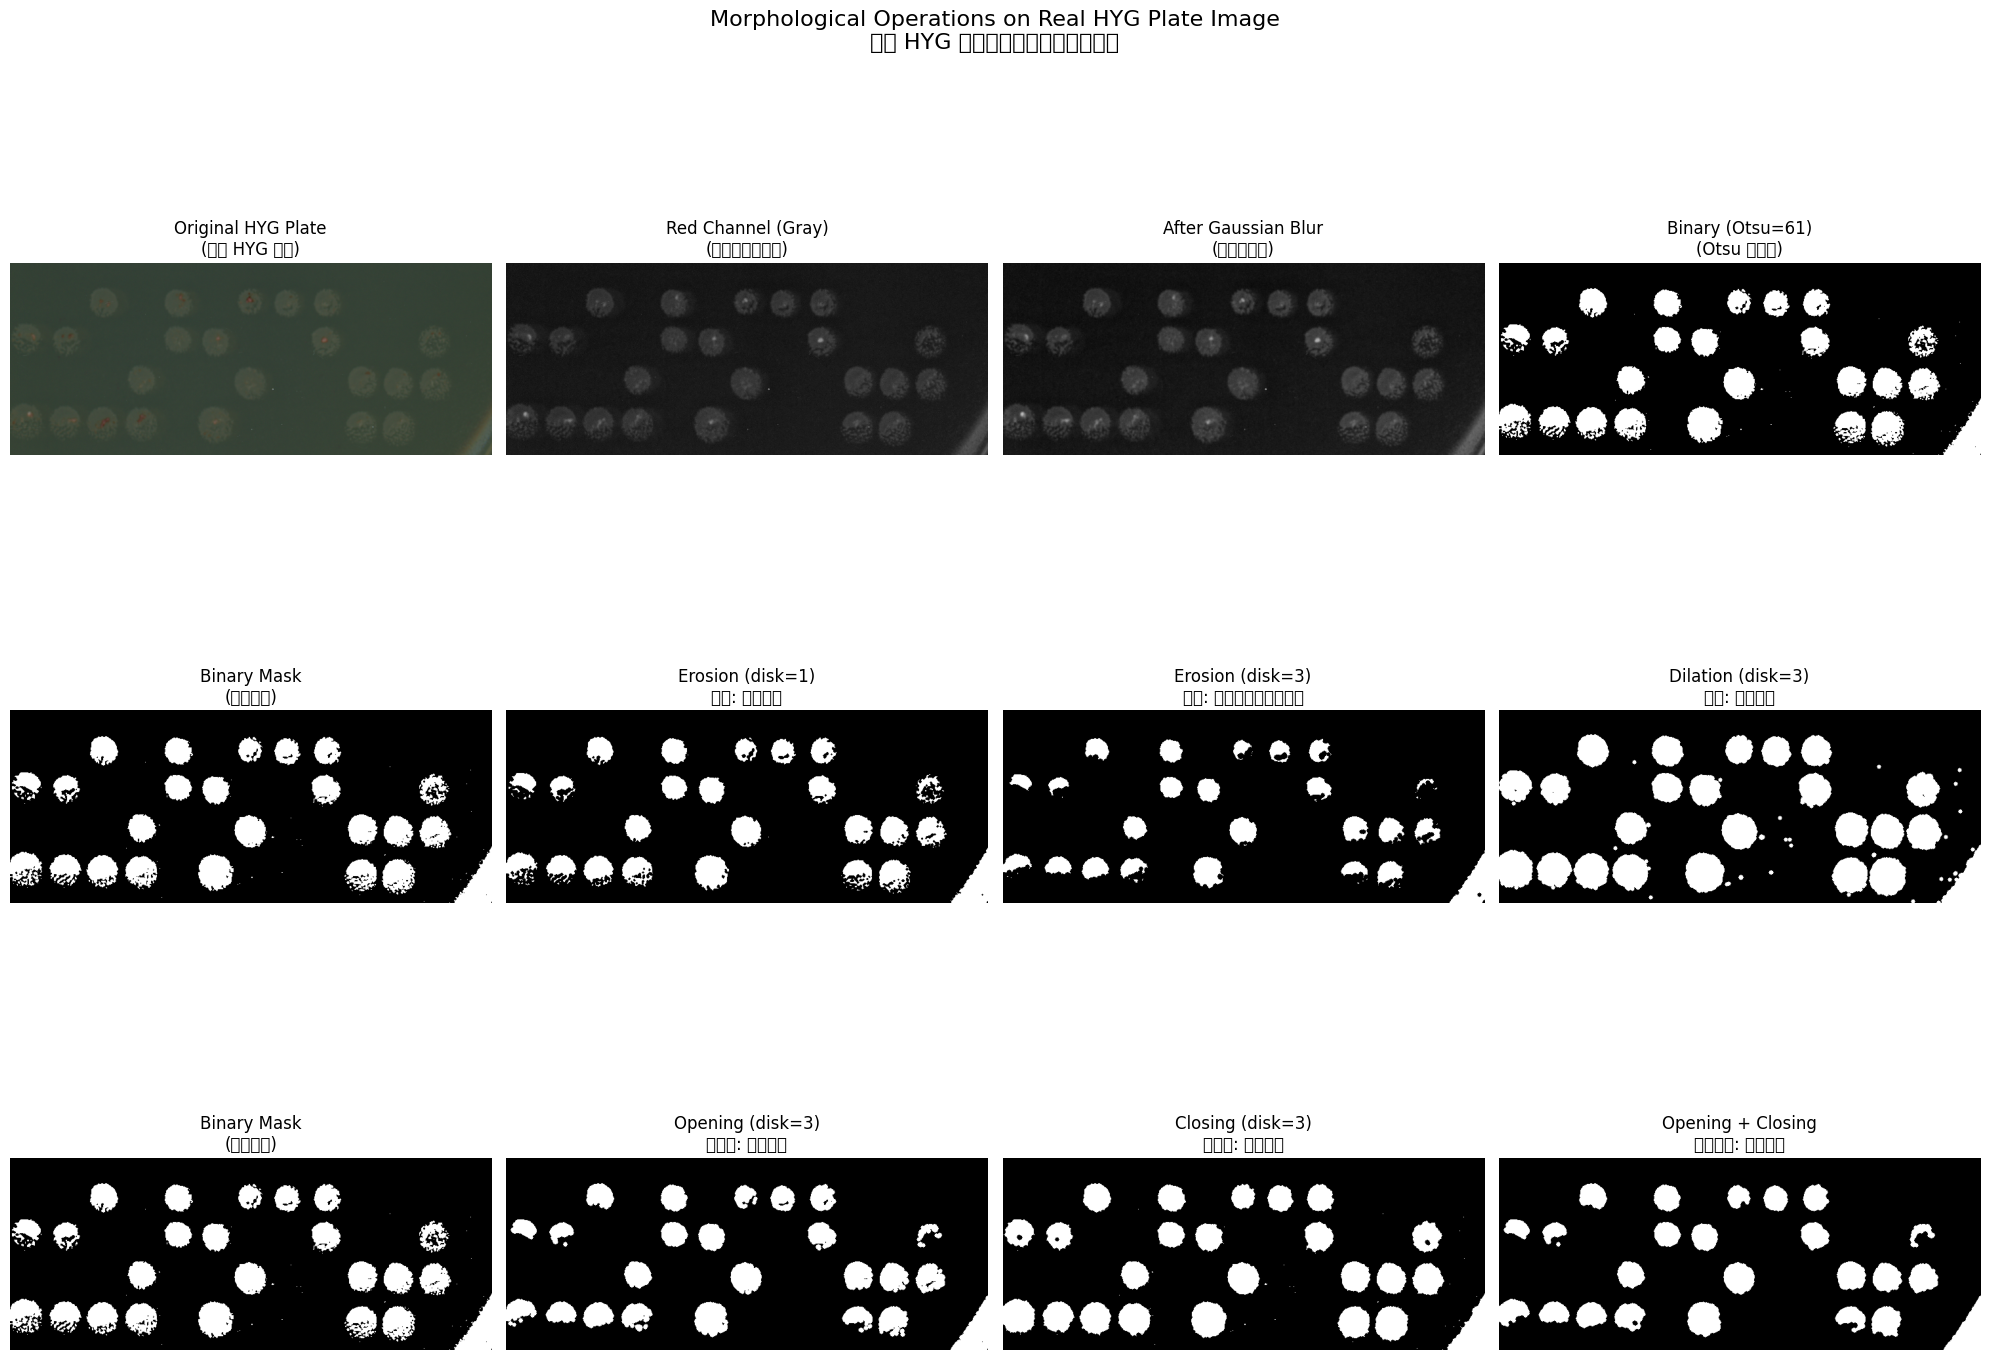

/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 24320 (\N{CJK UNIFIED IDEOGRAPH-5F00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3789989231.py:119: UserWarning: Glyph 36816 (\N

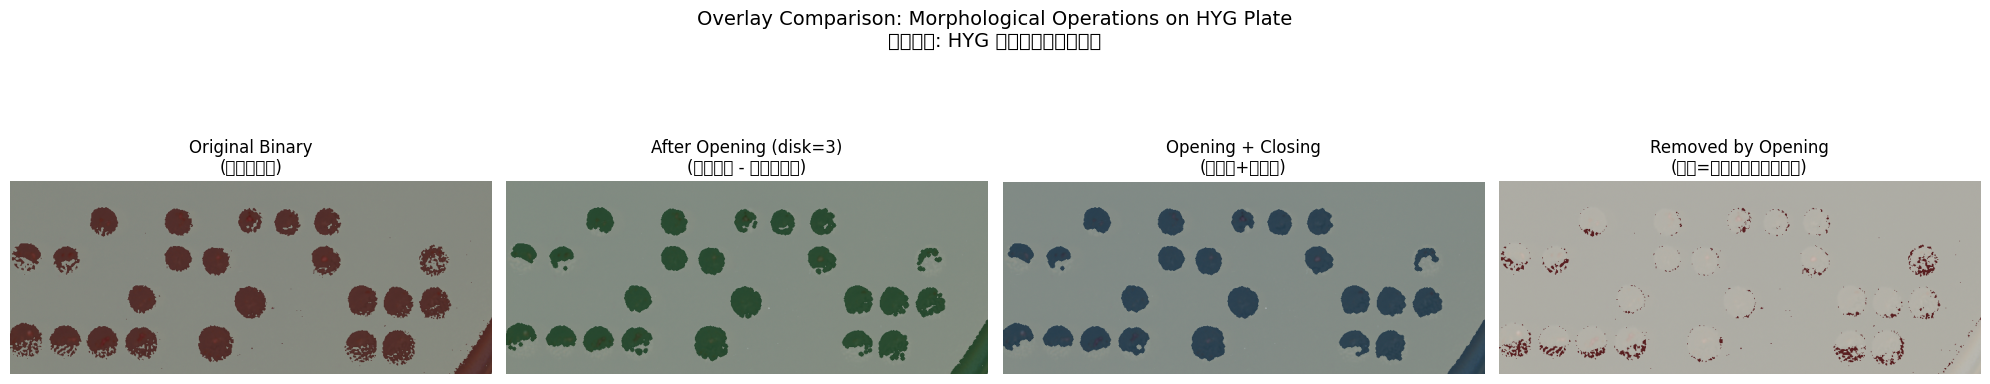


HYG 平板形态学处理统计:
原始二值化白色像素数: 35,344
开运算后白色像素数: 31,156
被去除的噪点像素数: 4,188 (11.8%)

结论: 开运算 (Opening) 有效去除了图像中的小噪点，
      同时保留了真正的菌落区域！



In [27]:
# ============================================================
# 使用真实 HYG 图像展示形态学操作的效果
# ============================================================

# 对 HYG 平板图像进行处理
# 使用红色通道（绿色背景在红色通道中较暗）
gray_hyg = hyg_plate[:, :, 0].astype(float)

# 高斯模糊
blurred_hyg = gaussian(gray_hyg, sigma=0.5, preserve_range=True)

# Otsu 阈值
thresh_hyg = threshold_otsu(blurred_hyg)
binary_hyg = blurred_hyg > thresh_hyg

print(f"HYG 平板 Otsu 阈值: {thresh_hyg:.1f}")

# 不同大小的结构元素
disk_1 = morphology.disk(1)
disk_3 = morphology.disk(3)
disk_5 = morphology.disk(5)

# 应用不同的形态学操作
eroded_hyg_1 = morphology.binary_erosion(binary_hyg, disk_1)
eroded_hyg_3 = morphology.binary_erosion(binary_hyg, disk_3)
dilated_hyg_3 = morphology.binary_dilation(binary_hyg, disk_3)
opened_hyg_3 = morphology.binary_opening(binary_hyg, disk_3)
closed_hyg_3 = morphology.binary_closing(binary_hyg, disk_3)

# 可视化
fig, axes = plt.subplots(3, 4, figsize=(20, 16))

# ===== 第一行: 原始图像和二值化 =====
axes[0, 0].imshow(hyg_plate)
axes[0, 0].set_title('Original HYG Plate\n(原始 HYG 平板)')
axes[0, 0].axis('off')

axes[0, 1].imshow(gray_hyg, cmap='gray')
axes[0, 1].set_title('Red Channel (Gray)\n(红色通道灰度图)')
axes[0, 1].axis('off')

axes[0, 2].imshow(blurred_hyg, cmap='gray')
axes[0, 2].set_title('After Gaussian Blur\n(高斯模糊后)')
axes[0, 2].axis('off')

axes[0, 3].imshow(binary_hyg, cmap='gray')
axes[0, 3].set_title(f'Binary (Otsu={thresh_hyg:.0f})\n(Otsu 二值化)')
axes[0, 3].axis('off')

# ===== 第二行: 腐蚀和膨胀效果对比 =====
axes[1, 0].imshow(binary_hyg, cmap='gray')
axes[1, 0].set_title('Binary Mask\n(二值掩码)')
axes[1, 0].axis('off')

axes[1, 1].imshow(eroded_hyg_1, cmap='gray')
axes[1, 1].set_title('Erosion (disk=1)\n腐蚀: 轻微收缩')
axes[1, 1].axis('off')

axes[1, 2].imshow(eroded_hyg_3, cmap='gray')
axes[1, 2].set_title('Erosion (disk=3)\n腐蚀: 明显收缩，小点消失')
axes[1, 2].axis('off')

axes[1, 3].imshow(dilated_hyg_3, cmap='gray')
axes[1, 3].set_title('Dilation (disk=3)\n膨胀: 菌落变大')
axes[1, 3].axis('off')

# ===== 第三行: 开运算和闭运算 =====
axes[2, 0].imshow(binary_hyg, cmap='gray')
axes[2, 0].set_title('Binary Mask\n(二值掩码)')
axes[2, 0].axis('off')

axes[2, 1].imshow(opened_hyg_3, cmap='gray')
axes[2, 1].set_title('Opening (disk=3)\n开运算: 去除噪点')
axes[2, 1].axis('off')

axes[2, 2].imshow(closed_hyg_3, cmap='gray')
axes[2, 2].set_title('Closing (disk=3)\n闭运算: 填充小洞')
axes[2, 2].axis('off')

# 开运算 + 闭运算组合
opened_closed = morphology.binary_closing(opened_hyg_3, disk_3)
axes[2, 3].imshow(opened_closed, cmap='gray')
axes[2, 3].set_title('Opening + Closing\n先开后闭: 最佳效果')
axes[2, 3].axis('off')

plt.suptitle('Morphological Operations on Real HYG Plate Image\n真实 HYG 平板图像的形态学操作效果', fontsize=16)
plt.tight_layout()
plt.show()

# ===== 叠加原图显示效果 =====
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 原始二值化叠加
axes[0].imshow(hyg_plate)
axes[0].imshow(binary_hyg, alpha=0.4, cmap='Reds')
axes[0].set_title('Original Binary\n(原始二值化)')
axes[0].axis('off')

# 开运算叠加
axes[1].imshow(hyg_plate)
axes[1].imshow(opened_hyg_3, alpha=0.4, cmap='Greens')
axes[1].set_title('After Opening (disk=3)\n(开运算后 - 噪点已去除)')
axes[1].axis('off')

# 开运算+闭运算叠加
axes[2].imshow(hyg_plate)
axes[2].imshow(opened_closed, alpha=0.4, cmap='Blues')
axes[2].set_title('Opening + Closing\n(开运算+闭运算)')
axes[2].axis('off')

# 差异对比
diff = binary_hyg.astype(int) - opened_hyg_3.astype(int)
axes[3].imshow(hyg_plate)
axes[3].imshow(diff == 1, alpha=0.6, cmap='Reds')  # 被去除的部分
axes[3].set_title('Removed by Opening\n(红色=被开运算去除的噪点)')
axes[3].axis('off')

plt.suptitle('Overlay Comparison: Morphological Operations on HYG Plate\n叠加对比: HYG 平板形态学操作效果', fontsize=14)
plt.tight_layout()
plt.show()

# 统计被去除的像素数
removed_pixels = np.sum(binary_hyg) - np.sum(opened_hyg_3)
print(f"""
HYG 平板形态学处理统计:
========================
原始二值化白色像素数: {np.sum(binary_hyg):,}
开运算后白色像素数: {np.sum(opened_hyg_3):,}
被去除的噪点像素数: {removed_pixels:,} ({removed_pixels/np.sum(binary_hyg)*100:.1f}%)

结论: 开运算 (Opening) 有效去除了图像中的小噪点，
      同时保留了真正的菌落区域！
""")

---
## 7. 分水岭分割

### 问题: 融合的菌落

当两个菌落靠得很近时，阈值分割会把它们合并成一个区域。

### 分水岭算法 (Watershed)

想象图像是一个地形图：
1. 将灰度值视为「海拔高度」
2. 从局部最低点开始「注水」
3. 水位上升直到不同流域相遇
4. 相遇处形成「分水岭」（边界）

### 实现步骤
1. **距离变换**: 计算每个前景像素到最近背景像素的距离
2. **找局部最大值**: 作为「注水点」（markers）
3. **应用分水岭**: 分割融合区域

找到 2 个局部最大值 (菌落中心)


/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 34701 (\N{CJK UNIFIED IDEOGRAPH-878D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 33740 (\N{CJK UNIFIED IDEOGRAPH-83CC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 33853 (\N{CJK UNIFIED IDEOGRAPH-843D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3228429502.py:68: UserWarning: Glyph 31163 (\N{CJK UN

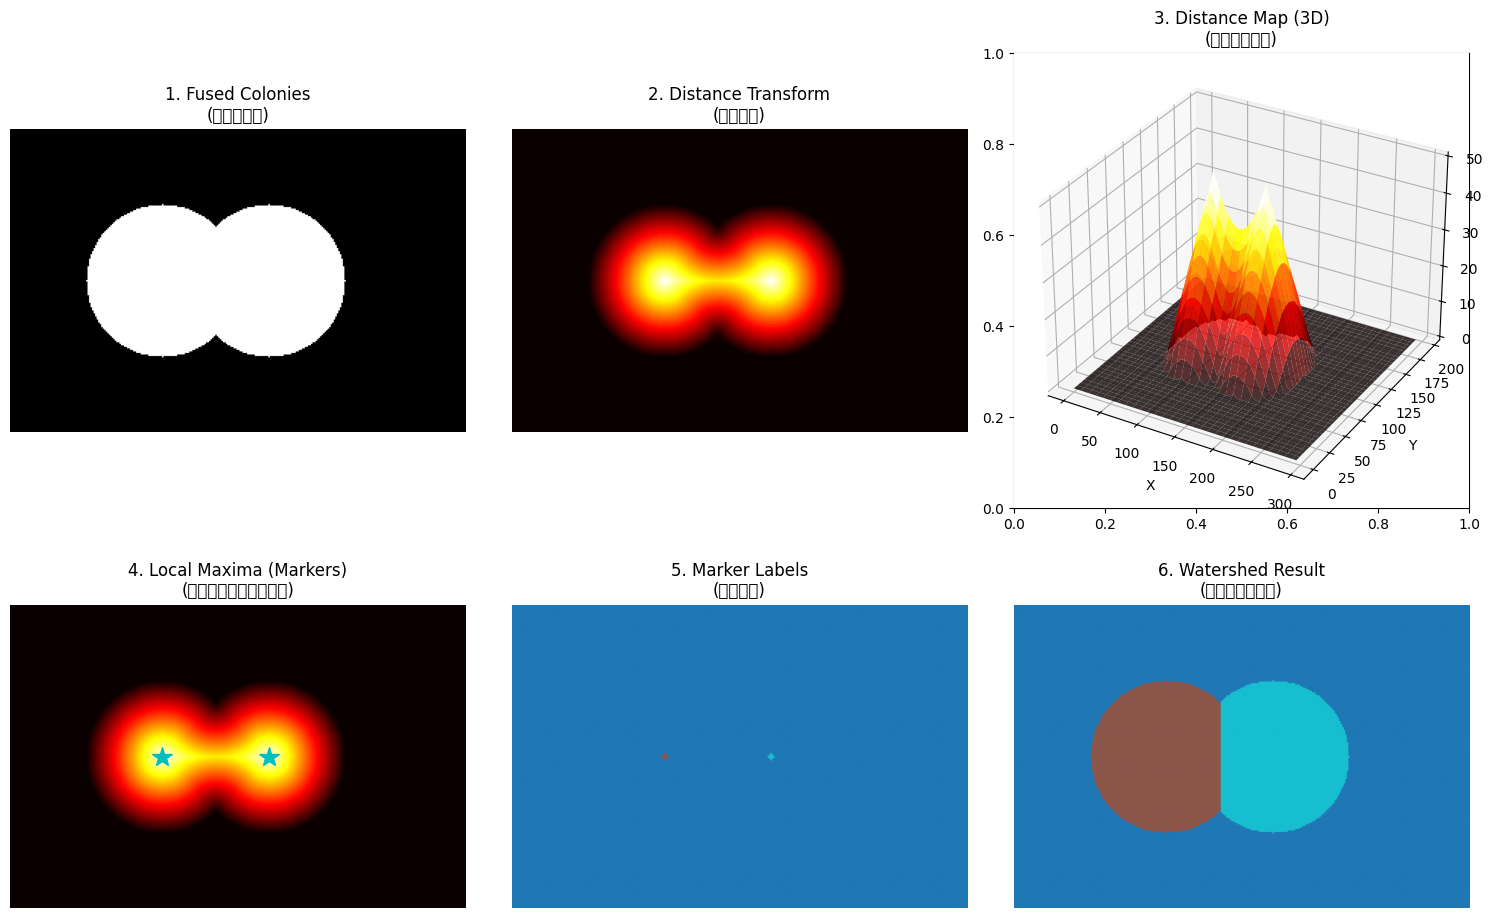


分水岭算法关键参数:
- min_distance: 控制两个局部最大值之间的最小距离
  在脚本中: tetrad_split_min_distance=20, hyg_split_min_distance=5



In [28]:
# 为了演示分水岭算法，我们使用真实图像中可能存在的融合菌落区域
# 同时创建一个简单的模拟示例来说明原理

# 创建两个融合的圆（模拟融合菌落）用于清晰演示原理
def create_fused_colonies():
    img = np.zeros((200, 300), dtype=np.uint8)
    cv2.circle(img, (100, 100), 50, 255, -1)
    cv2.circle(img, (170, 100), 50, 255, -1)
    return img > 0

fused_mask = create_fused_colonies()

# 步骤1: 距离变换
distance_map = ndimage.distance_transform_edt(fused_mask)

# 步骤2: 找局部最大值
coords = peak_local_max(
    distance_map,
    min_distance=20,  # 两个最大值之间的最小距离
    labels=fused_mask.astype(int)
)
print(f"找到 {len(coords)} 个局部最大值 (菌落中心)")

# 创建标记
markers = np.zeros(distance_map.shape, dtype=int)
markers[tuple(coords.T)] = np.arange(1, len(coords) + 1)
markers = morphology.binary_dilation(markers > 0, morphology.disk(2))
markers = measure.label(markers)

# 步骤3: 分水岭分割
ws_labels = watershed(-distance_map, markers, mask=fused_mask)

# 可视化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(fused_mask, cmap='gray')
axes[0, 0].set_title('1. Fused Colonies\n(融合的菌落)')
axes[0, 0].axis('off')

axes[0, 1].imshow(distance_map, cmap='hot')
axes[0, 1].set_title('2. Distance Transform\n(距离变换)')
axes[0, 1].axis('off')

# 3D 可视化距离变换
from mpl_toolkits.mplot3d import Axes3D
ax3d = fig.add_subplot(2, 3, 3, projection='3d')
X, Y = np.meshgrid(range(distance_map.shape[1]), range(distance_map.shape[0]))
ax3d.plot_surface(X[::5, ::5], Y[::5, ::5], distance_map[::5, ::5], cmap='hot', alpha=0.8)
ax3d.set_title('3. Distance Map (3D)\n(想象成地形图)')
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')

# 标记点
axes[1, 0].imshow(distance_map, cmap='hot')
for i, (y, x) in enumerate(coords):
    axes[1, 0].plot(x, y, 'c*', markersize=15)
axes[1, 0].set_title('4. Local Maxima (Markers)\n(局部最大值作为种子点)')
axes[1, 0].axis('off')

axes[1, 1].imshow(markers, cmap='tab10')
axes[1, 1].set_title('5. Marker Labels\n(标记区域)')
axes[1, 1].axis('off')

axes[1, 2].imshow(ws_labels, cmap='tab10')
axes[1, 2].set_title('6. Watershed Result\n(分水岭分割结果)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("""
分水岭算法关键参数:
- min_distance: 控制两个局部最大值之间的最小距离
  在脚本中: tetrad_split_min_distance=20, hyg_split_min_distance=5
""")

---
## 8. 区域属性与质心提取

### measure.label
将二值图像中的连通区域标记为不同的整数。

### measure.regionprops
计算每个标记区域的属性：
- `area`: 面积（像素数）
- `centroid`: 质心坐标 (row, col) = (y, x)
- `bbox`: 边界框
- `eccentricity`: 离心率
- 等等...

检测到 23 个连通区域
筛选后保留 23 个菌落 (面积 > 10 像素)


/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 39068 (\N{CJK UNIFIED IDEOGRAPH-989C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2868295819.py:53: UserWarning: Glyph 20010 (\N{CJK UN

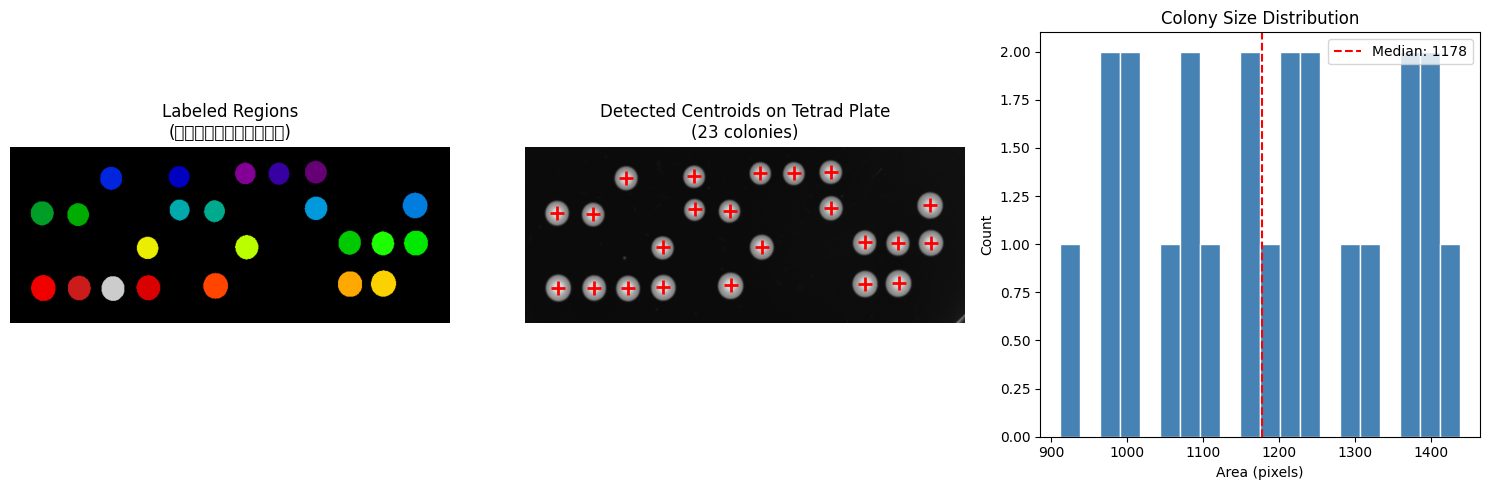

In [29]:
from skimage import measure

# 使用 Tetrad 平板的二值掩码
cleaned_mask = morphology.binary_opening(binary_mask, morphology.disk(3))

# 标记连通区域
label_img = measure.label(cleaned_mask)
print(f"检测到 {label_img.max()} 个连通区域")

# 计算区域属性
props = measure.regionprops(label_img)

# 提取质心（筛选面积 > 10 的区域）
min_area = 10
centroids = []
areas = []

for prop in props:
    if prop.area > min_area:
        y, x = prop.centroid  # 注意: regionprops 返回 (row, col) = (y, x)
        centroids.append((x, y))
        areas.append(prop.area)

print(f"筛选后保留 {len(centroids)} 个菌落 (面积 > {min_area} 像素)")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 标记图
axes[0].imshow(label_img, cmap='nipy_spectral')
axes[0].set_title('Labeled Regions\n(每种颜色是一个独立区域)')
axes[0].axis('off')

# 质心标记
axes[1].imshow(tetrad_plate)
for i, (x, y) in enumerate(centroids):
    axes[1].plot(x, y, 'r+', markersize=10, markeredgewidth=2)
axes[1].set_title(f'Detected Centroids on Tetrad Plate\n({len(centroids)} colonies)')
axes[1].axis('off')

# 面积分布
if areas:
    axes[2].hist(areas, bins=20, color='steelblue', edgecolor='white')
    axes[2].axvline(np.median(areas), color='red', linestyle='--', label=f'Median: {np.median(areas):.0f}')
    axes[2].set_xlabel('Area (pixels)')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Colony Size Distribution')
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, 'No colonies detected', ha='center', va='center')
    axes[2].set_title('Colony Size Distribution')

plt.tight_layout()
plt.show()

---
## 9. 图像对齐

### 为什么需要对齐？

复制平板时，两张图片可能存在：
- **平移** (Translation)
- **旋转** (Rotation)
- **缩放** (Scale)

### 仿射变换 (Affine Transformation)

$$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a & b \\ c & d \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix}$$

OpenCV 使用 2×3 矩阵表示：
$$M = \begin{bmatrix} a & b & t_x \\ c & d & t_y \end{bmatrix}$$

### 脚本中的方法

1. **匈牙利算法** (`linear_sum_assignment`): 找到两组点之间的最优匹配
2. **RANSAC**: 鲁棒地估计变换矩阵，忽略异常点
3. **cv2.warpAffine**: 应用变换

Tetrad 图像尺寸: (294, 735, 3)
HYG 图像尺寸 (调整后): (294, 735, 3)

Tetrad 平板检测到: 23 个菌落
HYG 平板检测到: 27 个菌落
成功匹配: 23 对菌落

估计的变换参数:
  缩放 (Scale): 1.0021
  旋转 (Rotation): -1.96°
  平移 (Translation): (23.6, -3.5) pixels


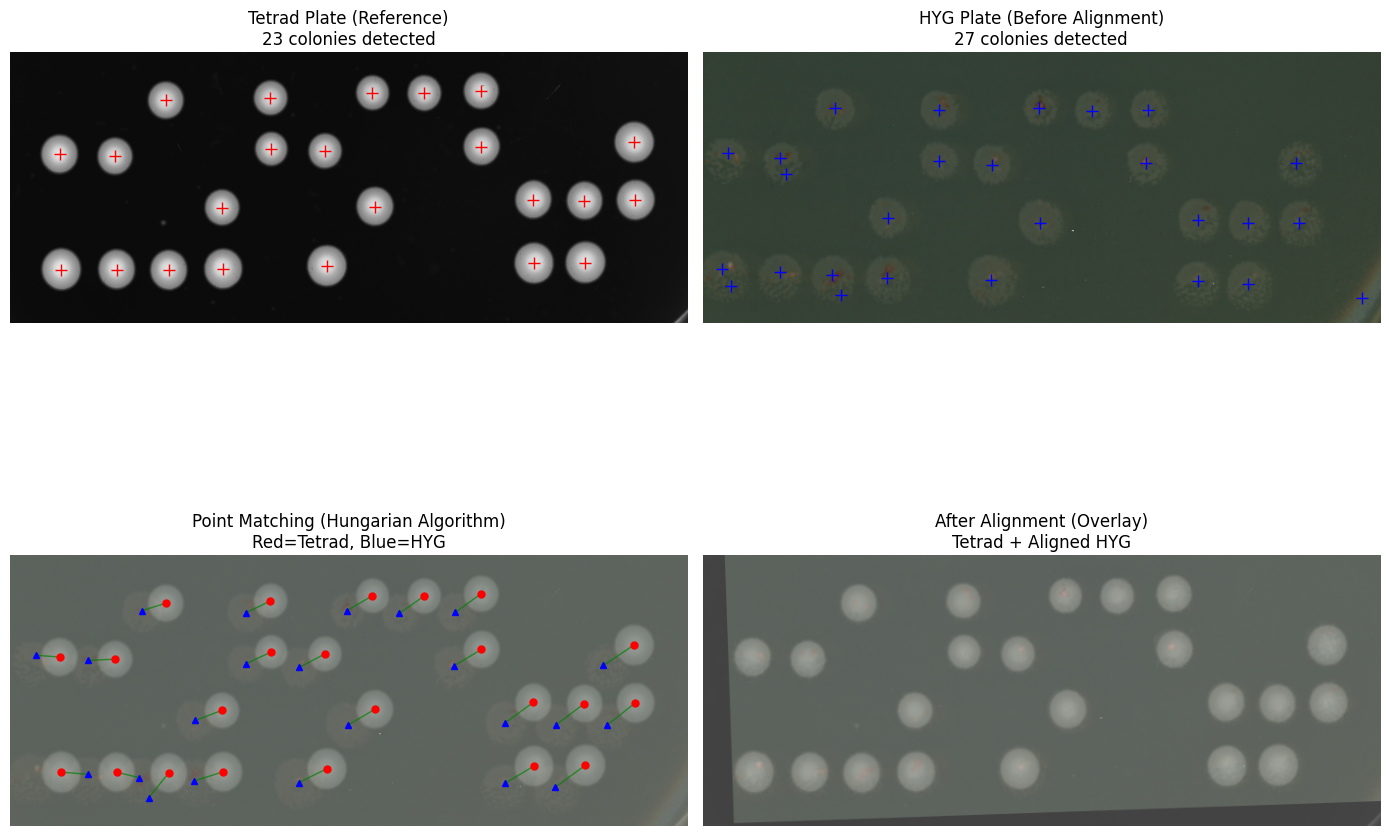

In [30]:
# 使用真实的 Tetrad 和 HYG 平板图像演示图像对齐

# 调整 HYG 图像大小以匹配 Tetrad
h_ref, w_ref = tetrad_plate.shape[:2]
hyg_resized = cv2.resize(hyg_plate, (w_ref, h_ref))

print(f"Tetrad 图像尺寸: {tetrad_plate.shape}")
print(f"HYG 图像尺寸 (调整后): {hyg_resized.shape}")

# 检测两张图的菌落质心
def detect_colonies_simple(img, is_hyg=False, min_area=20):
    """简化版菌落检测"""
    if is_hyg:
        # HYG 平板用红色通道
        gray = img[:, :, 0].astype(float)
    else:
        # Tetrad 平板用平均值
        gray = np.mean(img, axis=2)
    
    # 高斯模糊
    blurred = gaussian(gray, sigma=1.0, preserve_range=True)
    
    # Otsu 阈值
    try:
        thresh = threshold_otsu(blurred)
        binary = blurred > thresh
    except:
        binary = blurred > 100
    
    # 形态学开运算
    binary = morphology.binary_opening(binary, morphology.disk(3))
    
    # 提取质心
    label_img = measure.label(binary)
    props = measure.regionprops(label_img)
    
    centroids = []
    for prop in props:
        if prop.area > min_area:
            y, x = prop.centroid
            centroids.append((x, y))
    
    return centroids, binary

# 检测菌落
centroids_tetrad, mask_tetrad = detect_colonies_simple(tetrad_plate, is_hyg=False)
centroids_hyg, mask_hyg = detect_colonies_simple(hyg_resized, is_hyg=True)

print(f"\nTetrad 平板检测到: {len(centroids_tetrad)} 个菌落")
print(f"HYG 平板检测到: {len(centroids_hyg)} 个菌落")

# 如果检测到足够的菌落，进行匹配和对齐
if len(centroids_tetrad) >= 3 and len(centroids_hyg) >= 3:
    # 匈牙利算法匹配
    pts_tetrad = np.array(centroids_tetrad, dtype=np.float32)
    pts_hyg = np.array(centroids_hyg, dtype=np.float32)
    
    dist_matrix = distance.cdist(pts_tetrad, pts_hyg)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    
    # 过滤距离过大的匹配
    max_dist = max(h_ref, w_ref) * 0.15
    matched_tetrad, matched_hyg = [], []
    
    for r, c in zip(row_ind, col_ind):
        if dist_matrix[r, c] < max_dist:
            matched_tetrad.append(pts_tetrad[r])
            matched_hyg.append(pts_hyg[c])
    
    print(f"成功匹配: {len(matched_tetrad)} 对菌落")
    
    if len(matched_tetrad) >= 3:
        matched_tetrad = np.array(matched_tetrad, dtype=np.float32)
        matched_hyg = np.array(matched_hyg, dtype=np.float32)
        
        # 估计变换矩阵
        M_estimated, inliers = cv2.estimateAffinePartial2D(
            matched_hyg, matched_tetrad,
            method=cv2.RANSAC,
            ransacReprojThreshold=5.0
        )
        
        # 应用变换
        hyg_aligned = cv2.warpAffine(hyg_resized, M_estimated, (w_ref, h_ref))
        
        # 打印变换参数
        scale = np.sqrt(M_estimated[0, 0]**2 + M_estimated[0, 1]**2)
        angle = np.degrees(np.arctan2(M_estimated[1, 0], M_estimated[0, 0]))
        tx, ty = M_estimated[0, 2], M_estimated[1, 2]
        
        print(f"\n估计的变换参数:")
        print(f"  缩放 (Scale): {scale:.4f}")
        print(f"  旋转 (Rotation): {angle:.2f}°")
        print(f"  平移 (Translation): ({tx:.1f}, {ty:.1f}) pixels")
    else:
        print("匹配点对不足，无法估计变换")
        hyg_aligned = hyg_resized
        M_estimated = None
else:
    print("检测到的菌落数量不足")
    hyg_aligned = hyg_resized
    M_estimated = None

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Tetrad 平板 + 检测结果
axes[0, 0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0, 0].plot(x, y, 'r+', markersize=8, markeredgewidth=1)
axes[0, 0].set_title(f'Tetrad Plate (Reference)\n{len(centroids_tetrad)} colonies detected')
axes[0, 0].axis('off')

# HYG 平板 (原始) + 检测结果
axes[0, 1].imshow(hyg_resized)
for (x, y) in centroids_hyg:
    axes[0, 1].plot(x, y, 'b+', markersize=8, markeredgewidth=1)
axes[0, 1].set_title(f'HYG Plate (Before Alignment)\n{len(centroids_hyg)} colonies detected')
axes[0, 1].axis('off')

# 匹配可视化
axes[1, 0].imshow(tetrad_plate, alpha=0.5)
axes[1, 0].imshow(hyg_resized, alpha=0.5)
if len(centroids_tetrad) >= 3 and len(centroids_hyg) >= 3 and len(matched_tetrad) >= 3:
    for (t, h) in zip(matched_tetrad, matched_hyg):
        axes[1, 0].plot([t[0], h[0]], [t[1], h[1]], 'g-', linewidth=1, alpha=0.7)
        axes[1, 0].plot(t[0], t[1], 'ro', markersize=5)
        axes[1, 0].plot(h[0], h[1], 'b^', markersize=5)
axes[1, 0].set_title('Point Matching (Hungarian Algorithm)\nRed=Tetrad, Blue=HYG')
axes[1, 0].axis('off')

# 对齐后叠加
axes[1, 1].imshow(tetrad_plate, alpha=0.5)
axes[1, 1].imshow(hyg_aligned, alpha=0.5)
axes[1, 1].set_title('After Alignment (Overlay)\nTetrad + Aligned HYG')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

---
## 10. 空间匹配

### 最终判断逻辑

对于每个 Tetrad 平板上的孢子位置：
1. 计算到所有 HYG 平板菌落的距离
2. 找到最近的 HYG 菌落
3. 如果距离 < 阈值 → **Deletion (HYG 抗性)**
4. 如果距离 ≥ 阈值 → **WT (HYG 敏感)**

### 自适应阈值

脚本会根据菌落间距自动计算阈值：
```python
threshold = median_column_spacing * 0.35
```

对齐后 HYG 平板检测到: 1 个菌落
自适应匹配阈值: 20.0 像素


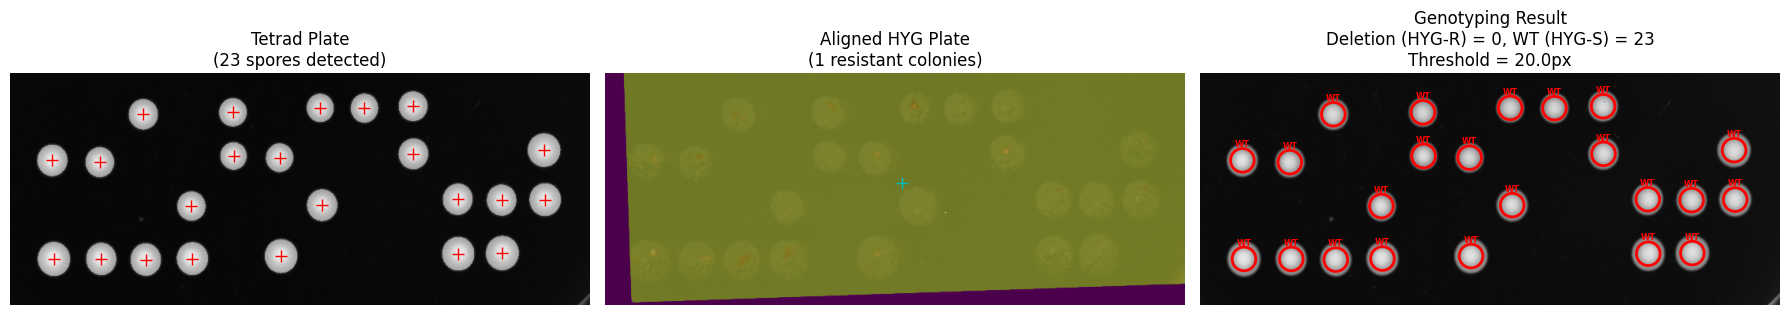


分析结果 (302_meu23)
总检测孢子数: 23
Deletion (HYG抗性): 0
WT (HYG敏感): 23
Del:WT 比例: 0:23


In [31]:
# 使用真实数据进行基因型判断
# 在对齐后的 HYG 图像上重新检测菌落

# 重新检测对齐后的 HYG 平板菌落
centroids_hyg_aligned, mask_hyg_aligned = detect_colonies_simple(hyg_aligned, is_hyg=True, min_area=20)
print(f"对齐后 HYG 平板检测到: {len(centroids_hyg_aligned)} 个菌落")

# 计算自适应阈值
def compute_adaptive_threshold(centroids, image_width, expected_cols=12):
    """根据菌落间距计算匹配阈值"""
    if len(centroids) < 2:
        return image_width / expected_cols * 0.4
    
    sorted_x = sorted([c[0] for c in centroids])
    x_diffs = [sorted_x[i+1] - sorted_x[i] for i in range(len(sorted_x)-1)]
    
    min_col_spacing = image_width / (expected_cols * 2)
    col_spacings = [d for d in x_diffs if d > min_col_spacing]
    
    if col_spacings:
        threshold = np.median(col_spacings) * 0.35
    else:
        threshold = image_width / expected_cols * 0.35
    
    return max(threshold, 20)

# 计算阈值
threshold = compute_adaptive_threshold(centroids_tetrad, w_ref)
print(f"自适应匹配阈值: {threshold:.1f} 像素")

# 计算距离矩阵
if centroids_hyg_aligned:
    dists = distance.cdist(centroids_tetrad, centroids_hyg_aligned)
else:
    dists = np.full((len(centroids_tetrad), 1), 1000)

# 判断基因型
results = []
del_count, wt_count = 0, 0

for i, (cX, cY) in enumerate(centroids_tetrad):
    min_dist = np.min(dists[i])
    
    if min_dist < threshold:
        genotype = "DEL"
        del_count += 1
    else:
        genotype = "WT"
        wt_count += 1
    
    results.append({'x': cX, 'y': cY, 'genotype': genotype, 'min_dist': min_dist})

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Tetrad 平板 + 检测
axes[0].imshow(tetrad_plate)
axes[0].imshow(mask_tetrad, alpha=0.3, cmap='gray')
for (x, y) in centroids_tetrad:
    axes[0].plot(x, y, 'r+', markersize=8, markeredgewidth=1)
axes[0].set_title(f'Tetrad Plate\n({len(centroids_tetrad)} spores detected)')
axes[0].axis('off')

# Panel 2: 对齐后的 HYG 平板
axes[1].imshow(hyg_aligned)
axes[1].imshow(mask_hyg_aligned, alpha=0.3, cmap='spring')
for (hx, hy) in centroids_hyg_aligned:
    axes[1].plot(hx, hy, 'c+', markersize=8, markeredgewidth=1)
axes[1].set_title(f'Aligned HYG Plate\n({len(centroids_hyg_aligned)} resistant colonies)')
axes[1].axis('off')

# Panel 3: 基因型判断结果
axes[2].imshow(tetrad_plate)
for res in results:
    cX, cY = res['x'], res['y']
    color = 'lime' if res['genotype'] == "DEL" else 'red'
    
    circ = Circle((cX, cY), radius=15, color=color, fill=False, linewidth=2)
    axes[2].add_patch(circ)
    axes[2].text(cX, cY-18, res['genotype'], color=color, fontsize=6, 
               ha='center', fontweight='bold')

axes[2].set_title(
    f'Genotyping Result\n'
    f'Deletion (HYG-R) = {del_count}, WT (HYG-S) = {wt_count}\n'
    f'Threshold = {threshold:.1f}px'
)
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 统计结果
print(f"\n{'='*50}")
print(f"分析结果 (302_meu23)")
print(f"{'='*50}")
print(f"总检测孢子数: {len(centroids_tetrad)}")
print(f"Deletion (HYG抗性): {del_count}")
print(f"WT (HYG敏感): {wt_count}")

if del_count + wt_count > 0:
    print(f"Del:WT 比例: {del_count}:{wt_count}")
    expected = len(centroids_tetrad) // 2
    if abs(del_count - expected) <= 5 and abs(wt_count - expected) <= 5:
        print("✓ 大致符合预期的 1:1 分离比例")

---
## 11. 基于网格的基因型判断方法 (Grid-Based Genotyping)

### 新方法思路

之前的方法是通过检测两张图片的菌落位置，然后计算距离来匹配。但这种方法可能受到菌落检测质量的影响。

**新方法**：
1. 从 Tetrad 平板检测所有克隆位置
2. 根据检测到的克隆位置，拟合一个 **4行 × 12列** 的规则网格
3. 用这个网格去 **对齐后的 HYG 图像** 中检测每个网格区域的信号强度
4. 根据信号强度阈值判断 DEL 还是 WT

### 优点
- 不需要在 HYG 图像上单独检测菌落
- 网格位置固定，不受 HYG 检测噪声影响
- 可以量化每个位置的信号强度

基于网格的基因型判断方法
Grid-Based Genotyping Method

[Step 1] 从 Tetrad 平板拟合网格...
检测到 23 个菌落质心
网格参数:
  X 范围: 53.2 - 677.7
  Y 范围: 41.6 - 236.0
  X 间距: 56.8 px
  Y 间距: 64.8 px

[Step 2] 在对齐 HYG 图像上测量信号...
测量半径: 22 px
信号范围: 51.4 - 69.1
信号平均值: 59.0

[Step 3] 判断基因型...
自动阈值 (Otsu): 55.6
Deletion (HYG-R): 24
WT (HYG-S): 24


/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 32418 (\N{CJK UNIFIED IDEOGRAPH-7EA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1764361745.py:321: UserWarning: Glyph 32593 (\N

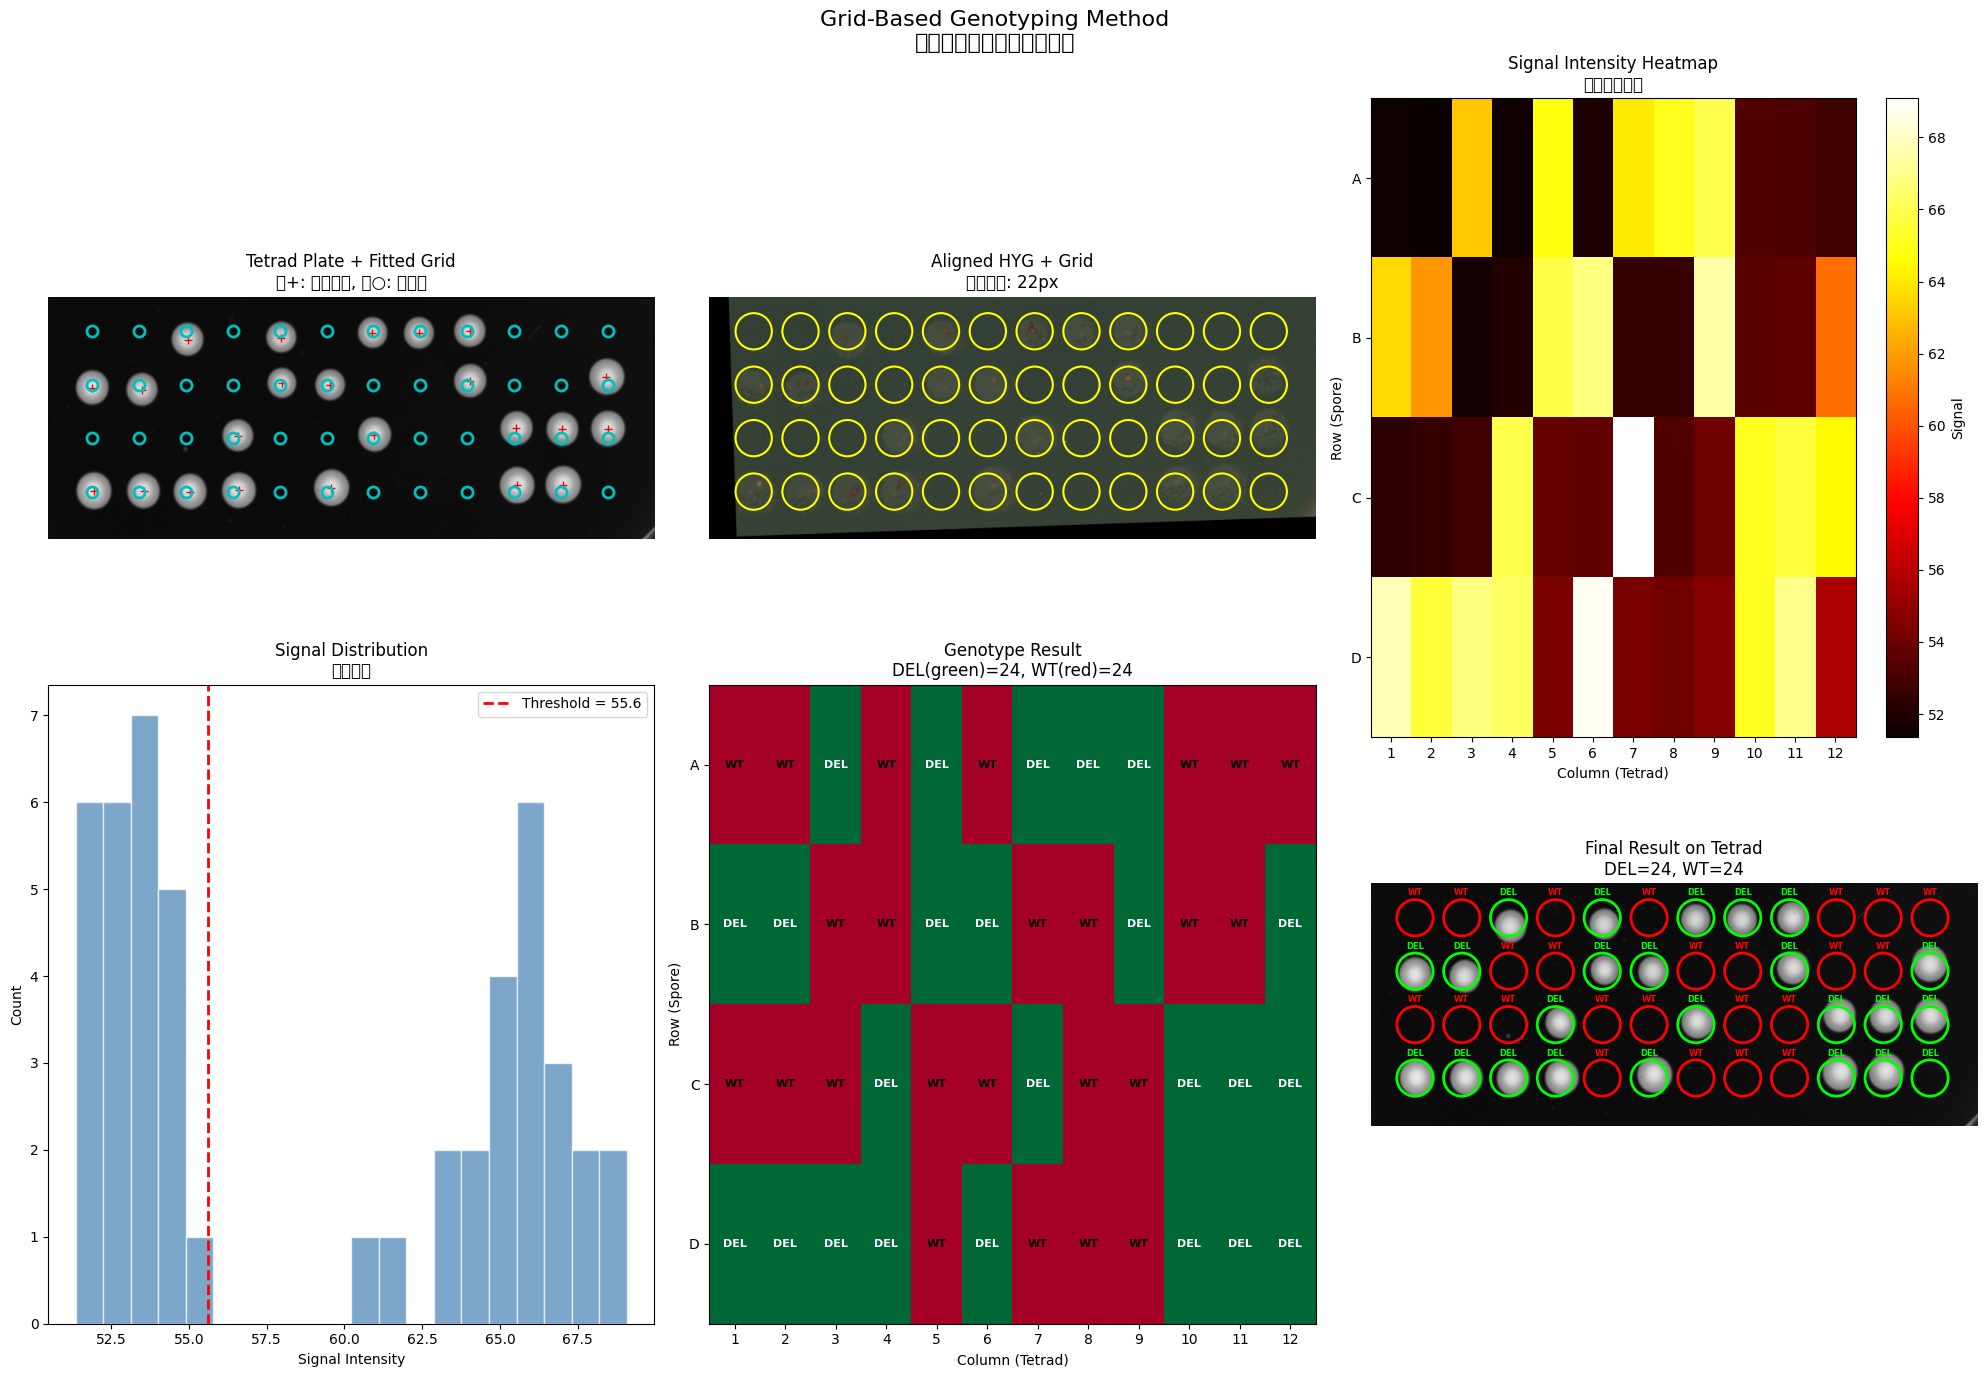


详细结果 (按四分体分组)
Tetrad  1: [np.str_('WT'), np.str_('DEL'), np.str_('WT'), np.str_('DEL')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  2: [np.str_('WT'), np.str_('DEL'), np.str_('WT'), np.str_('DEL')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  3: [np.str_('DEL'), np.str_('WT'), np.str_('WT'), np.str_('DEL')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  4: [np.str_('WT'), np.str_('WT'), np.str_('DEL'), np.str_('DEL')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  5: [np.str_('DEL'), np.str_('DEL'), np.str_('WT'), np.str_('WT')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  6: [np.str_('WT'), np.str_('DEL'), np.str_('WT'), np.str_('DEL')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  7: [np.str_('DEL'), np.str_('WT'), np.str_('DEL'), np.str_('WT')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad  8: [np.str_('DEL'), np.str_('WT'), np.str_('WT'), np.str_('WT')]  → DEL:WT = 1:3 (non-2:2)
Tetrad  9: [np.str_('DEL'), np.str_('DEL'), np.str_('WT'), np.str_('WT')]  → DEL:WT = 2:2 ✓ (2:2 segregation)
Tetrad

In [32]:
# ============================================================
# 基于网格的基因型判断方法
# Grid-Based Genotyping Method
# ============================================================

def fit_grid_from_centroids(centroids, n_rows=4, n_cols=12, image_shape=None):
    """
    从检测到的菌落质心拟合一个规则的 n_rows × n_cols 网格。
    
    步骤:
    1. 找到所有质心的边界
    2. 计算网格间距
    3. 生成规则网格点
    
    Args:
        centroids: 检测到的菌落质心 [(x, y), ...]
        n_rows: 网格行数 (默认 4，对应四分体的 4 个孢子)
        n_cols: 网格列数 (默认 12，对应 12 个四分体)
        image_shape: 图像尺寸 (height, width)，用于边界检查
        
    Returns:
        grid_centers: 网格中心点 shape=(n_rows, n_cols, 2)
        grid_params: 网格参数字典
    """
    if len(centroids) < 4:
        raise ValueError("质心数量不足，无法拟合网格")
    
    # 转换为 numpy 数组
    pts = np.array(centroids)
    xs, ys = pts[:, 0], pts[:, 1]
    
    # 方法1: 基于边界框拟合
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    
    # 计算间距
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    # 生成网格中心
    grid_centers = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid_centers[row, col, 0] = x_min + col * x_spacing  # x
            grid_centers[row, col, 1] = y_min + row * y_spacing  # y
    
    grid_params = {
        'x_min': x_min, 'x_max': x_max,
        'y_min': y_min, 'y_max': y_max,
        'x_spacing': x_spacing,
        'y_spacing': y_spacing,
        'n_rows': n_rows,
        'n_cols': n_cols
    }
    
    return grid_centers, grid_params


def measure_grid_signal(image, grid_centers, radius=15, channel='red'):
    """
    测量网格每个位置的信号强度。
    
    Args:
        image: 输入图像 (RGB)
        grid_centers: 网格中心点 shape=(n_rows, n_cols, 2)
        radius: 测量区域半径
        channel: 使用的通道 ('red', 'mean', 'gray')
        
    Returns:
        signals: 信号强度矩阵 shape=(n_rows, n_cols)
        signal_details: 详细信息列表
    """
    n_rows, n_cols = grid_centers.shape[:2]
    h, w = image.shape[:2]
    
    # 选择通道
    if channel == 'red' and image.ndim == 3:
        gray = image[:, :, 0].astype(float)
    elif channel == 'mean' and image.ndim == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image.astype(float) if image.ndim == 2 else np.mean(image, axis=2)
    
    signals = np.zeros((n_rows, n_cols))
    signal_details = []
    
    # 创建圆形掩码
    y_grid, x_grid = np.ogrid[-radius:radius+1, -radius:radius+1]
    circle_mask = x_grid**2 + y_grid**2 <= radius**2
    
    for row in range(n_rows):
        for col in range(n_cols):
            cx, cy = grid_centers[row, col]
            cx, cy = int(round(cx)), int(round(cy))
            
            # 边界检查
            x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                # 提取区域
                region = gray[y1:y2, x1:x2]
                
                # 调整掩码大小以匹配区域
                mask_y1 = radius - (cy - y1)
                mask_y2 = mask_y1 + (y2 - y1)
                mask_x1 = radius - (cx - x1)
                mask_x2 = mask_x1 + (x2 - x1)
                
                local_mask = circle_mask[mask_y1:mask_y2, mask_x1:mask_x2]
                
                # 计算平均信号
                if local_mask.sum() > 0:
                    mean_signal = region[local_mask].mean()
                    max_signal = region[local_mask].max()
                else:
                    mean_signal = 0
                    max_signal = 0
            else:
                mean_signal = 0
                max_signal = 0
            
            signals[row, col] = mean_signal
            signal_details.append({
                'row': row, 'col': col,
                'x': cx, 'y': cy,
                'mean_signal': mean_signal,
                'max_signal': max_signal
            })
    
    return signals, signal_details


def genotype_by_grid(signals, threshold=None, method='otsu'):
    """
    根据信号强度判断基因型。
    
    Args:
        signals: 信号强度矩阵
        threshold: 手动指定阈值，如果为 None 则自动计算
        method: 自动阈值方法 ('otsu', 'median', 'kmeans')
        
    Returns:
        genotypes: 基因型矩阵 ('DEL' or 'WT')
        threshold: 使用的阈值
    """
    flat_signals = signals.flatten()
    
    if threshold is None:
        if method == 'otsu':
            # 使用 Otsu 方法
            from skimage.filters import threshold_otsu
            threshold = threshold_otsu(flat_signals)
        elif method == 'median':
            # 使用中位数
            threshold = np.median(flat_signals)
        elif method == 'kmeans':
            # 使用 K-means 聚类
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
            labels = kmeans.fit_predict(flat_signals.reshape(-1, 1))
            centers = kmeans.cluster_centers_.flatten()
            threshold = np.mean(centers)
    
    # 判断基因型: 信号高于阈值 = DEL (HYG抗性)
    genotypes = np.where(signals > threshold, 'DEL', 'WT')
    
    return genotypes, threshold


# ============================================================
# 应用网格方法到真实数据
# ============================================================

print("=" * 60)
print("基于网格的基因型判断方法")
print("Grid-Based Genotyping Method")
print("=" * 60)

# Step 1: 从 Tetrad 平板检测菌落并拟合网格
print("\n[Step 1] 从 Tetrad 平板拟合网格...")

# 使用之前检测到的 centroids_tetrad
print(f"检测到 {len(centroids_tetrad)} 个菌落质心")

# 拟合 4×12 网格
try:
    grid_centers, grid_params = fit_grid_from_centroids(
        centroids_tetrad, 
        n_rows=4, 
        n_cols=12,
        image_shape=tetrad_plate.shape[:2]
    )
    print(f"网格参数:")
    print(f"  X 范围: {grid_params['x_min']:.1f} - {grid_params['x_max']:.1f}")
    print(f"  Y 范围: {grid_params['y_min']:.1f} - {grid_params['y_max']:.1f}")
    print(f"  X 间距: {grid_params['x_spacing']:.1f} px")
    print(f"  Y 间距: {grid_params['y_spacing']:.1f} px")
except Exception as e:
    print(f"网格拟合失败: {e}")
    grid_centers = None

# Step 2: 在对齐后的 HYG 图像上测量信号
if grid_centers is not None:
    print("\n[Step 2] 在对齐 HYG 图像上测量信号...")
    
    # 测量信号（使用红色通道，因为 HYG 是绿色背景）
    measure_radius = int(grid_params['y_spacing'] * 0.35)  # 半径为间距的 35%
    print(f"测量半径: {measure_radius} px")
    
    signals, signal_details = measure_grid_signal(
        hyg_aligned, 
        grid_centers, 
        radius=measure_radius,
        channel='red'
    )
    
    print(f"信号范围: {signals.min():.1f} - {signals.max():.1f}")
    print(f"信号平均值: {signals.mean():.1f}")

# Step 3: 判断基因型
if grid_centers is not None:
    print("\n[Step 3] 判断基因型...")
    
    genotypes, auto_threshold = genotype_by_grid(signals, method='otsu')
    print(f"自动阈值 (Otsu): {auto_threshold:.1f}")
    
    del_count_grid = np.sum(genotypes == 'DEL')
    wt_count_grid = np.sum(genotypes == 'WT')
    print(f"Deletion (HYG-R): {del_count_grid}")
    print(f"WT (HYG-S): {wt_count_grid}")

# ============================================================
# 可视化
# ============================================================

if grid_centers is not None:
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    
    # Panel 1: Tetrad 平板 + 网格
    axes[0, 0].imshow(tetrad_plate)
    # 绘制检测到的质心
    for (x, y) in centroids_tetrad:
        axes[0, 0].plot(x, y, 'r+', markersize=6, markeredgewidth=1)
    # 绘制网格点
    for row in range(4):
        for col in range(12):
            gx, gy = grid_centers[row, col]
            axes[0, 0].plot(gx, gy, 'co', markersize=8, markeredgewidth=2, fillstyle='none')
    axes[0, 0].set_title('Tetrad Plate + Fitted Grid\n红+: 检测质心, 青○: 网格点')
    axes[0, 0].axis('off')
    
    # Panel 2: 对齐 HYG + 网格
    axes[0, 1].imshow(hyg_aligned)
    for row in range(4):
        for col in range(12):
            gx, gy = grid_centers[row, col]
            circ = Circle((gx, gy), radius=measure_radius, 
                         color='yellow', fill=False, linewidth=1.5)
            axes[0, 1].add_patch(circ)
    axes[0, 1].set_title(f'Aligned HYG + Grid\n测量半径: {measure_radius}px')
    axes[0, 1].axis('off')
    
    # Panel 3: 信号热图
    im = axes[0, 2].imshow(signals, cmap='hot', aspect='auto')
    axes[0, 2].set_title('Signal Intensity Heatmap\n信号强度热图')
    axes[0, 2].set_xlabel('Column (Tetrad)')
    axes[0, 2].set_ylabel('Row (Spore)')
    axes[0, 2].set_xticks(range(12))
    axes[0, 2].set_yticks(range(4))
    axes[0, 2].set_xticklabels([str(i+1) for i in range(12)])
    axes[0, 2].set_yticklabels(['A', 'B', 'C', 'D'])
    plt.colorbar(im, ax=axes[0, 2], label='Signal')
    
    # Panel 4: 信号分布直方图
    axes[1, 0].hist(signals.flatten(), bins=20, color='steelblue', edgecolor='white', alpha=0.7)
    axes[1, 0].axvline(auto_threshold, color='red', linestyle='--', linewidth=2, 
                       label=f'Threshold = {auto_threshold:.1f}')
    axes[1, 0].set_xlabel('Signal Intensity')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Signal Distribution\n信号分布')
    axes[1, 0].legend()
    
    # Panel 5: 基因型结果表格
    # 创建颜色编码的基因型表格
    genotype_colors = np.where(genotypes == 'DEL', 1, 0)
    axes[1, 1].imshow(genotype_colors, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # 添加文字标签
    for row in range(4):
        for col in range(12):
            text_color = 'white' if genotypes[row, col] == 'DEL' else 'black'
            axes[1, 1].text(col, row, genotypes[row, col], 
                          ha='center', va='center', fontsize=8, 
                          color=text_color, fontweight='bold')
    
    axes[1, 1].set_title(f'Genotype Result\nDEL(green)={del_count_grid}, WT(red)={wt_count_grid}')
    axes[1, 1].set_xlabel('Column (Tetrad)')
    axes[1, 1].set_ylabel('Row (Spore)')
    axes[1, 1].set_xticks(range(12))
    axes[1, 1].set_yticks(range(4))
    axes[1, 1].set_xticklabels([str(i+1) for i in range(12)])
    axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])
    
    # Panel 6: 最终结果叠加在 Tetrad 图像上
    axes[1, 2].imshow(tetrad_plate)
    for row in range(4):
        for col in range(12):
            gx, gy = grid_centers[row, col]
            color = 'lime' if genotypes[row, col] == 'DEL' else 'red'
            circ = Circle((gx, gy), radius=measure_radius, 
                         color=color, fill=False, linewidth=2)
            axes[1, 2].add_patch(circ)
            axes[1, 2].text(gx, gy - measure_radius - 5, genotypes[row, col],
                          color=color, fontsize=6, ha='center', fontweight='bold')
    
    axes[1, 2].set_title(f'Final Result on Tetrad\nDEL={del_count_grid}, WT={wt_count_grid}')
    axes[1, 2].axis('off')
    
    plt.suptitle('Grid-Based Genotyping Method\n基于网格的基因型判断方法', fontsize=16)
    plt.tight_layout()
    plt.show()

# 输出详细结果
print("\n" + "=" * 60)
print("详细结果 (按四分体分组)")
print("=" * 60)

if grid_centers is not None:
    for col in range(12):
        tetrad_result = [genotypes[row, col] for row in range(4)]
        del_in_tetrad = tetrad_result.count('DEL')
        wt_in_tetrad = tetrad_result.count('WT')
        segregation = f"{del_in_tetrad}:{wt_in_tetrad}"
        
        print(f"Tetrad {col+1:2d}: {tetrad_result}  → DEL:WT = {segregation}", end="")
        if del_in_tetrad == 2 and wt_in_tetrad == 2:
            print(" ✓ (2:2 segregation)")
        else:
            print(f" (non-2:2)")

print(f"\n总计: DEL={del_count_grid}, WT={wt_count_grid}")

---
## 总结

### 完整流程回顾

```
1. 读取图像 (skimage.io.imread)
        ↓
2. 灰度转换 (np.mean / 取单通道)
        ↓
3. 高斯模糊 (filters.gaussian) → 减少噪声
        ↓
4. Otsu 阈值 (filters.threshold_otsu) → 二值化
        ↓
5. 形态学开运算 (morphology.binary_opening) → 去噪
        ↓
6. 分水岭分割 (watershed) → 分离融合菌落
        ↓
7. 区域标记 (measure.label + regionprops) → 提取质心
        ↓
8. 图像对齐 (cv2.estimateAffinePartial2D + warpAffine)
        ↓
9. 空间匹配 (distance.cdist) → 判断基因型
```

### 关键库总结

| 库 | 主要用途 |
|---|---|
| **skimage.filters** | 高斯模糊、Otsu 阈值 |
| **skimage.morphology** | 形态学操作、结构元素 |
| **skimage.measure** | 区域标记、属性计算 |
| **skimage.segmentation** | 分水岭算法 |
| **scipy.ndimage** | 距离变换 |
| **scipy.spatial** | 距离计算 |
| **cv2 (OpenCV)** | 图像对齐、仿射变换 |

In [ ]:
print("🎉 教程完成！")
print("\n现在你应该理解了脚本中每个图像处理步骤的含义。")
print("\n" + "="*60)
print("使用完整分析脚本的方法:")
print("="*60)
print("""
from src.align_and_measure_colony import analyze_replica_plating, AnalysisConfig

config = AnalysisConfig(
    expected_cols=12,
    expected_rows=4,
    use_adaptive_threshold=True
)

del_count, wt_count = analyze_replica_plating(
    tetrad_path='path/to/tetrad.png',
    hyg_path='path/to/hyg.png',
    config=config,
    pic_result_path='result.png'
)
""")

print("\n" + "="*60)
print("本教程使用的真实数据:")
print("="*60)
print(f"Tetrad: {TETRAD_PATH}")
print(f"HYG: {HYG_PATH}")

---
## 🔧 改进的网格拟合方法：支持旋转校正

### 问题分析

当前的简单边界框方法存在以下问题：
1. **不支持旋转**：如果 tetrad 平板有轻微旋转，网格无法正确对齐
2. **Essential Gene 情况**：如果基因是 essential 的，每个 tetrad 只有 2 个存活的孢子，这会影响网格拟合

### 改进方案

1. **PCA (主成分分析)** 或 **最小二乘拟合**：找到质心分布的主轴方向
2. **带旋转的仿射变换**：在拟合网格时加入旋转参数
3. **RANSAC**：鲁棒地拟合网格，处理缺失菌落的情况

### Essential Gene 检测

对于 essential gene 的 tetrad，每列应该只有约 2 个存活菌落（而不是 4 个）。
我们可以通过统计每列的菌落数量来检测这种情况。

测试改进的网格拟合方法（支持旋转校正）

菌落数量分析:
  总菌落数: 23
  平均每列菌落数: 1.83
  每列菌落数: [np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(1)]
  是否为 Essential Gene: 是 ⚠️

使用改进的方法拟合网格:
PCA 检测到的旋转角度: 177.66°
优化后的旋转角度: -1.51°
优化后的网格间距: X=56.4, Y=61.1

网格参数:
  旋转角度: -1.51°
  X 间距: 56.9 px
  Y 间距: 64.8 px


/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/2135411223.py:331: UserWarning: Glyph 26080 (\N

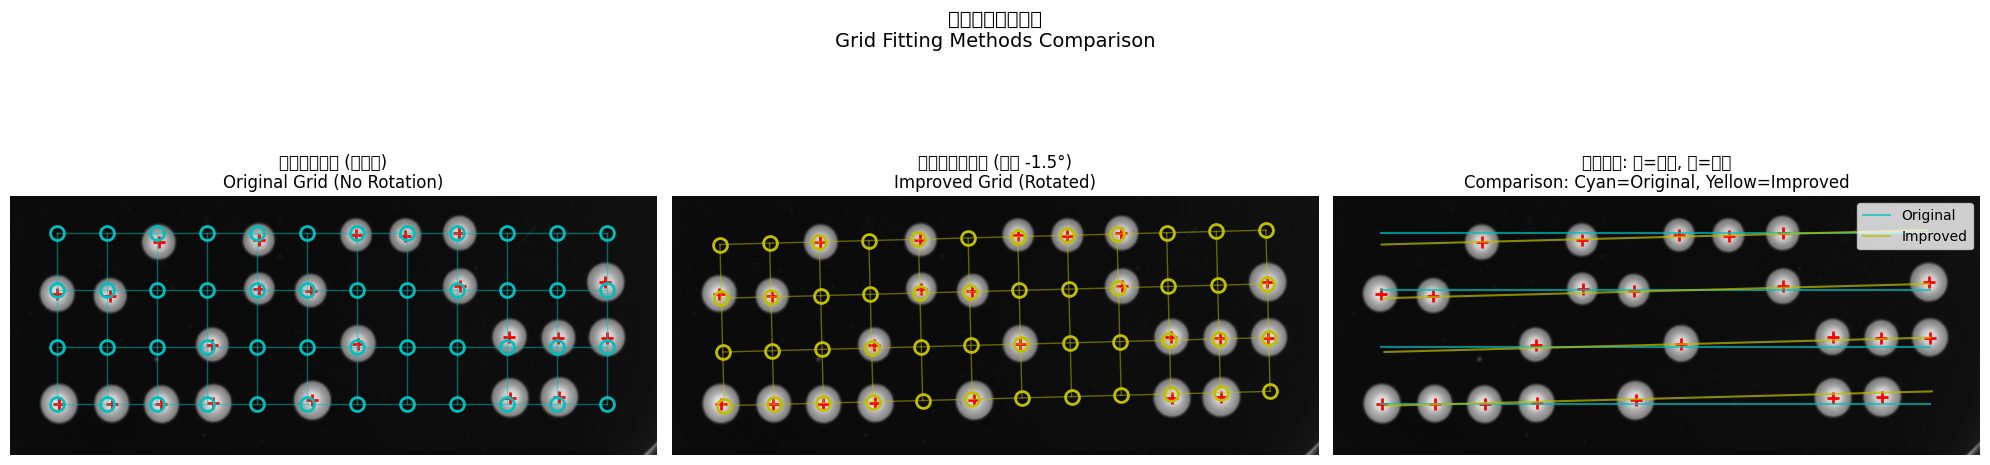


网格拟合误差对比:
  原始方法: 33.80 ± 27.01 px
  改进方法: 31.81 ± 28.35 px
  改进程度: 5.9%


In [34]:
# ============================================================
# 改进的网格拟合方法：支持旋转校正
# Improved Grid Fitting with Rotation Correction
# ============================================================

import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

def numpy_pca(pts):
    """
    使用 numpy 实现简单的 PCA (无需 sklearn)
    
    Returns:
        components: 主成分方向 (2x2 矩阵，每行是一个主成分)
        explained_variance: 各主成分的方差
    """
    # 中心化
    pts_centered = pts - np.mean(pts, axis=0)
    # 协方差矩阵
    cov_matrix = np.cov(pts_centered.T)
    # 特征值分解
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # 按特征值降序排列
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # 转置使每行为一个主成分
    components = eigenvectors.T
    return components, eigenvalues

def fit_grid_with_rotation(centroids, n_rows=4, n_cols=12, allow_rotation=True):
    """
    使用 PCA 和优化方法拟合带旋转的网格。
    
    步骤:
    1. 使用 PCA 找到质心分布的主轴方向
    2. 估计网格间距
    3. 优化旋转角度和位置以最小化网格点到最近质心的距离
    
    Args:
        centroids: 检测到的菌落质心 [(x, y), ...]
        n_rows: 网格行数
        n_cols: 网格列数
        allow_rotation: 是否允许旋转
        
    Returns:
        grid_centers: 网格中心点 shape=(n_rows, n_cols, 2)
        grid_params: 网格参数字典 (包含旋转角度等)
    """
    pts = np.array(centroids)
    
    if len(pts) < 4:
        raise ValueError("质心数量不足，无法拟合网格")
    
    # Step 1: 使用 PCA 找到主轴方向 (用 numpy 实现)
    components, _ = numpy_pca(pts)
    
    # 主成分方向 (第一个是主方向，对应 X/列方向)
    principal_axis = components[0]
    angle_rad = np.arctan2(principal_axis[1], principal_axis[0])
    angle_deg = np.degrees(angle_rad)
    
    print(f"PCA 检测到的旋转角度: {angle_deg:.2f}°")
    
    # Step 2: 将点旋转到水平方向
    cos_a, sin_a = np.cos(-angle_rad), np.sin(-angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    pts_rotated = pts @ rotation_matrix.T
    
    # Step 3: 在旋转后的坐标系中计算边界和间距
    x_min, x_max = pts_rotated[:, 0].min(), pts_rotated[:, 0].max()
    y_min, y_max = pts_rotated[:, 1].min(), pts_rotated[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    # Step 4: 生成规则网格 (在旋转后的坐标系中)
    grid_rotated = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid_rotated[row, col, 0] = x_min + col * x_spacing
            grid_rotated[row, col, 1] = y_min + row * y_spacing
    
    # Step 5: 将网格旋转回原始坐标系
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix_back = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    
    grid_centers = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid_centers[row, col] = grid_rotated[row, col] @ rotation_matrix_back.T
    
    # Step 6: (可选) 优化网格参数
    if allow_rotation:
        grid_centers, angle_deg = optimize_grid_parameters(
            pts, grid_centers, n_rows, n_cols
        )
    
    grid_params = {
        'angle_deg': angle_deg,
        'angle_rad': np.radians(angle_deg),
        'x_spacing': x_spacing,
        'y_spacing': y_spacing,
        'n_rows': n_rows,
        'n_cols': n_cols,
        'center': np.mean(pts, axis=0)
    }
    
    return grid_centers, grid_params


def optimize_grid_parameters(centroids, initial_grid, n_rows, n_cols):
    """
    优化网格参数（位置、旋转、间距）以最小化到质心的距离。
    
    使用 scipy.optimize.minimize 进行参数优化。
    """
    pts = np.array(centroids)
    
    # 计算初始参数
    center = np.mean(initial_grid.reshape(-1, 2), axis=0)
    initial_angle = 0  # 初始角度
    
    # 从初始网格估计间距
    x_spacing = np.abs(initial_grid[0, 1, 0] - initial_grid[0, 0, 0]) if n_cols > 1 else 50
    y_spacing = np.abs(initial_grid[1, 0, 1] - initial_grid[0, 0, 1]) if n_rows > 1 else 50
    
    def generate_grid(params):
        """根据参数生成网格"""
        cx, cy, angle, x_sp, y_sp = params
        grid = np.zeros((n_rows, n_cols, 2))
        
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        
        # 网格起始点（左上角）
        x_start = cx - (n_cols - 1) * x_sp / 2
        y_start = cy - (n_rows - 1) * y_sp / 2
        
        for row in range(n_rows):
            for col in range(n_cols):
                # 未旋转的位置
                dx = col * x_sp
                dy = row * y_sp
                # 旋转
                rx = dx * cos_a - dy * sin_a
                ry = dx * sin_a + dy * cos_a
                # 加上起始点偏移（也需要旋转）
                ox = x_start - cx
                oy = y_start - cy
                rox = ox * cos_a - oy * sin_a
                roy = ox * sin_a + oy * cos_a
                
                grid[row, col, 0] = cx + rox + rx
                grid[row, col, 1] = cy + roy + ry
        
        return grid
    
    def objective(params):
        """目标函数：最小化网格点到最近质心的平均距离"""
        grid = generate_grid(params)
        grid_flat = grid.reshape(-1, 2)
        
        # 对于每个网格点，找到最近的质心
        distances = cdist(grid_flat, pts)
        min_distances = distances.min(axis=1)
        
        # 返回平均最小距离
        return np.mean(min_distances)
    
    # 初始参数: [center_x, center_y, angle, x_spacing, y_spacing]
    x0 = [center[0], center[1], initial_angle, x_spacing, y_spacing]
    
    # 参数边界
    bounds = [
        (center[0] - 50, center[0] + 50),  # center_x
        (center[1] - 50, center[1] + 50),  # center_y
        (-0.2, 0.2),  # angle (约 ±11°)
        (x_spacing * 0.8, x_spacing * 1.2),  # x_spacing
        (y_spacing * 0.8, y_spacing * 1.2),  # y_spacing
    ]
    
    # 优化
    result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        optimal_params = result.x
        optimal_grid = generate_grid(optimal_params)
        optimal_angle = np.degrees(optimal_params[2])
        print(f"优化后的旋转角度: {optimal_angle:.2f}°")
        print(f"优化后的网格间距: X={optimal_params[3]:.1f}, Y={optimal_params[4]:.1f}")
        return optimal_grid, optimal_angle
    else:
        print("优化未收敛，使用初始网格")
        return initial_grid, 0


def detect_essential_gene(centroids, n_cols=12, threshold_ratio=0.6):
    """
    检测是否为 essential gene（每个 tetrad 只有约 2 个存活孢子）。
    
    通过分析每列（tetrad）的菌落数量来判断。
    
    Args:
        centroids: 检测到的质心
        n_cols: tetrad 数量
        threshold_ratio: 如果平均每列少于 n_rows * threshold_ratio 个菌落，认为是 essential
        
    Returns:
        is_essential: bool
        avg_per_col: 平均每列菌落数
    """
    pts = np.array(centroids)
    
    # 按 X 坐标分组
    x_coords = pts[:, 0]
    x_min, x_max = x_coords.min(), x_coords.max()
    col_width = (x_max - x_min) / n_cols
    
    # 统计每列的菌落数
    col_counts = []
    for col in range(n_cols):
        col_x_min = x_min + col * col_width
        col_x_max = col_x_min + col_width
        count = np.sum((x_coords >= col_x_min) & (x_coords < col_x_max))
        col_counts.append(count)
    
    avg_per_col = np.mean(col_counts)
    
    # 如果平均每列少于 2.5 个菌落，可能是 essential gene
    is_essential = avg_per_col < 4 * threshold_ratio
    
    return is_essential, avg_per_col, col_counts


# ============================================================
# 测试改进的网格拟合
# ============================================================

print("=" * 60)
print("测试改进的网格拟合方法（支持旋转校正）")
print("=" * 60)

# 检测是否为 essential gene
is_essential, avg_per_col, col_counts = detect_essential_gene(centroids_tetrad, n_cols=12)
print(f"\n菌落数量分析:")
print(f"  总菌落数: {len(centroids_tetrad)}")
print(f"  平均每列菌落数: {avg_per_col:.2f}")
print(f"  每列菌落数: {col_counts}")
print(f"  是否为 Essential Gene: {'是 ⚠️' if is_essential else '否'}")

# 使用改进的方法拟合网格
print(f"\n使用改进的方法拟合网格:")
grid_centers_improved, grid_params_improved = fit_grid_with_rotation(
    centroids_tetrad,
    n_rows=4,
    n_cols=12,
    allow_rotation=True
)

print(f"\n网格参数:")
print(f"  旋转角度: {grid_params_improved['angle_deg']:.2f}°")
print(f"  X 间距: {grid_params_improved['x_spacing']:.1f} px")
print(f"  Y 间距: {grid_params_improved['y_spacing']:.1f} px")

# ============================================================
# 对比可视化
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Panel 1: 原始网格（无旋转）
axes[0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0].plot(x, y, 'r+', markersize=8, markeredgewidth=2)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        axes[0].plot(gx, gy, 'co', markersize=10, markeredgewidth=2, fillstyle='none')
# 连接网格线
for row in range(4):
    xs = [grid_centers[row, col, 0] for col in range(12)]
    ys = [grid_centers[row, col, 1] for col in range(12)]
    axes[0].plot(xs, ys, 'c-', linewidth=1, alpha=0.5)
for col in range(12):
    xs = [grid_centers[row, col, 0] for row in range(4)]
    ys = [grid_centers[row, col, 1] for row in range(4)]
    axes[0].plot(xs, ys, 'c-', linewidth=1, alpha=0.5)
axes[0].set_title('原始网格方法 (无旋转)\nOriginal Grid (No Rotation)')
axes[0].axis('off')

# Panel 2: 改进的网格（带旋转）
axes[1].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[1].plot(x, y, 'r+', markersize=8, markeredgewidth=2)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers_improved[row, col]
        axes[1].plot(gx, gy, 'yo', markersize=10, markeredgewidth=2, fillstyle='none')
# 连接网格线
for row in range(4):
    xs = [grid_centers_improved[row, col, 0] for col in range(12)]
    ys = [grid_centers_improved[row, col, 1] for col in range(12)]
    axes[1].plot(xs, ys, 'y-', linewidth=1, alpha=0.5)
for col in range(12):
    xs = [grid_centers_improved[row, col, 0] for row in range(4)]
    ys = [grid_centers_improved[row, col, 1] for row in range(4)]
    axes[1].plot(xs, ys, 'y-', linewidth=1, alpha=0.5)
axes[1].set_title(f'改进的网格方法 (旋转 {grid_params_improved["angle_deg"]:.1f}°)\nImproved Grid (Rotated)')
axes[1].axis('off')

# Panel 3: 对比两种网格
axes[2].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[2].plot(x, y, 'r+', markersize=8, markeredgewidth=2)
# 原始网格 (青色)
for row in range(4):
    xs = [grid_centers[row, col, 0] for col in range(12)]
    ys = [grid_centers[row, col, 1] for col in range(12)]
    axes[2].plot(xs, ys, 'c-', linewidth=1.5, alpha=0.7, label='Original' if row == 0 else None)
# 改进网格 (黄色)
for row in range(4):
    xs = [grid_centers_improved[row, col, 0] for col in range(12)]
    ys = [grid_centers_improved[row, col, 1] for col in range(12)]
    axes[2].plot(xs, ys, 'y-', linewidth=1.5, alpha=0.7, label='Improved' if row == 0 else None)
axes[2].legend(loc='upper right')
axes[2].set_title('网格对比: 青=原始, 黄=改进\nComparison: Cyan=Original, Yellow=Improved')
axes[2].axis('off')

plt.suptitle('网格拟合方法对比\nGrid Fitting Methods Comparison', fontsize=14)
plt.tight_layout()
plt.show()

# 计算拟合误差
def calculate_grid_error(grid, centroids):
    """计算网格点到最近质心的平均距离"""
    pts = np.array(centroids)
    grid_flat = grid.reshape(-1, 2)
    distances = cdist(grid_flat, pts)
    min_distances = distances.min(axis=1)
    return np.mean(min_distances), np.std(min_distances)

error_orig, std_orig = calculate_grid_error(grid_centers, centroids_tetrad)
error_improved, std_improved = calculate_grid_error(grid_centers_improved, centroids_tetrad)

print(f"\n网格拟合误差对比:")
print(f"  原始方法: {error_orig:.2f} ± {std_orig:.2f} px")
print(f"  改进方法: {error_improved:.2f} ± {std_improved:.2f} px")
print(f"  改进程度: {(error_orig - error_improved) / error_orig * 100:.1f}%")

---
## 🧬 Essential Gene 情况的特殊处理

### 问题分析

从上面的结果可以看到：
- **平均每列菌落数: 1.83** (接近 2，而非 4)
- **Essential Gene 检测: 是 ⚠️**

对于 Essential Gene，每个 tetrad 只有 **2 个存活的孢子**（而不是 4 个）。这是因为 deletion 等位基因是致死的。

### 改进策略

1. **自适应行数检测**：根据菌落 Y 坐标的聚类来确定实际的行数
2. **基于列的网格生成**：先确定 X 方向的 12 列，然后在每列内检测存活的行
3. **稀疏网格映射**：对于缺失的菌落位置，标记为"无菌落"而不是强制匹配

测试自适应网格方法 (Essential Gene)
输入 23 个质心点
检测到的旋转角度: -2.34°
每行菌落数: [np.int64(5), np.int64(6), np.int64(5), np.int64(7)]
活跃行: [0, 1, 2, 3] (共 4 行)

网格信息:
  旋转角度: -2.34°
  活跃行: [0, 1, 2, 3]
  列宽: 52.2 px
  行高: 64.8 px


/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 36866 (\N{CJK UNIFIED IDEOGRAPH-9002}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3996780365.py:280: UserWarning: Glyph 36716 (\N

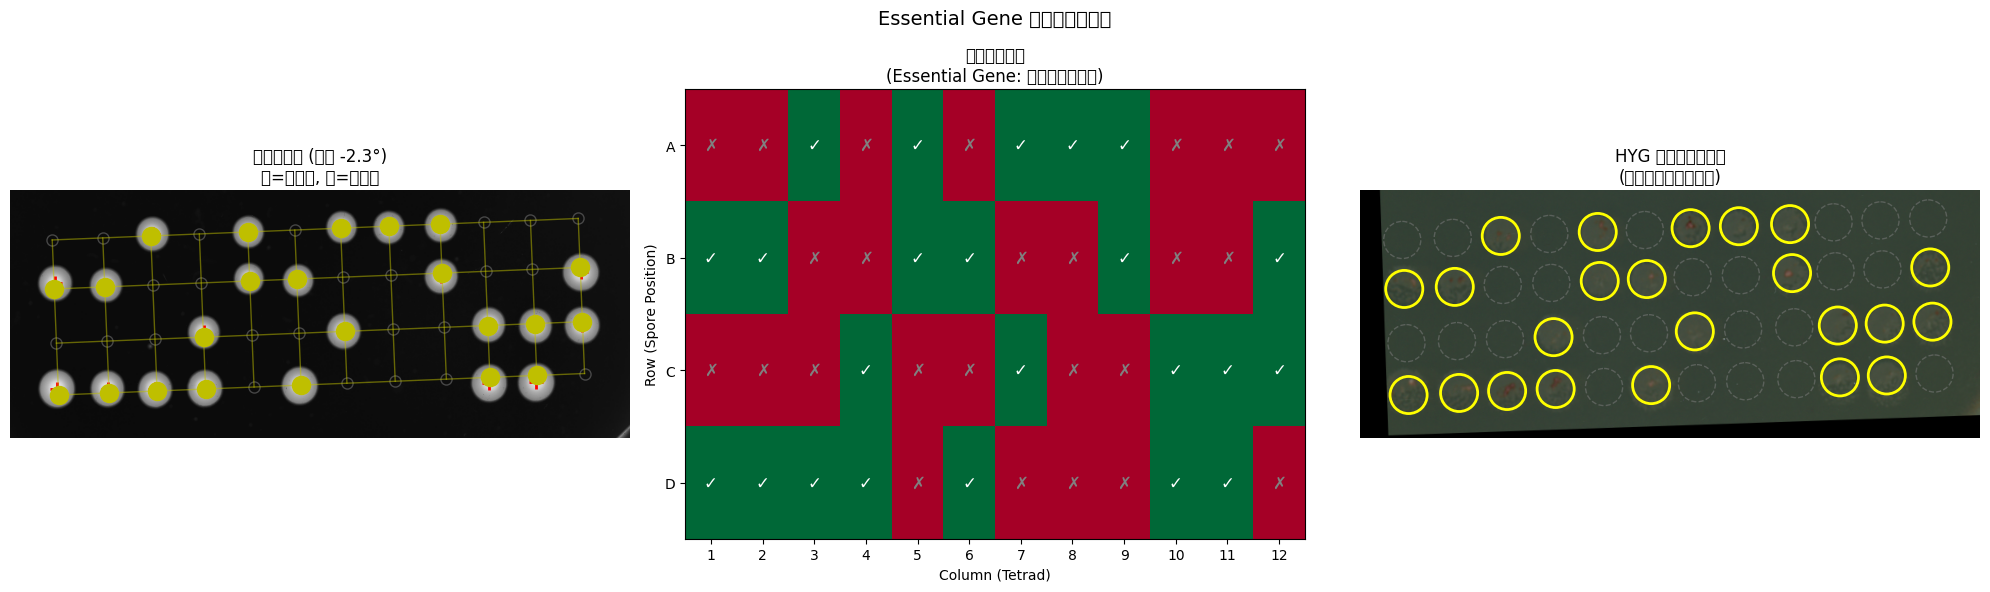


基因型判断 (仅有菌落的位置)
阈值: 63.5

基因型结果 (- 表示无菌落/致死):

        1    2    3    4    5    6    7    8    9   10   11   12
  A:   -    -   WT    -  DEL    -   WT   WT   WT    -    -    -
  B:  WT   WT    -    -  DEL  DEL    -    -  DEL    -    -   WT
  C:   -    -    -  DEL    -    -  DEL    -    -  DEL  DEL  DEL
  D: DEL  DEL  DEL  DEL    -  DEL    -    -    -  DEL  DEL    -

统计:
  DEL (HYG-R): 16
  WT (HYG-S): 7
  无菌落 (致死): 25
  DEL:WT 比例: 16:7

按 Tetrad 分析:
  Tetrad  1: [np.str_('-'), np.str_('WT'), np.str_('-'), np.str_('DEL')] → DEL:WT:Dead = 1:1:2 (2/4 survived)
  Tetrad  2: [np.str_('-'), np.str_('WT'), np.str_('-'), np.str_('DEL')] → DEL:WT:Dead = 1:1:2 (2/4 survived)
  Tetrad  3: [np.str_('WT'), np.str_('-'), np.str_('-'), np.str_('DEL')] → DEL:WT:Dead = 1:1:2 (2/4 survived)
  Tetrad  4: [np.str_('-'), np.str_('-'), np.str_('DEL'), np.str_('DEL')] → DEL:WT:Dead = 2:0:2 (2/4 survived)
  Tetrad  5: [np.str_('DEL'), np.str_('DEL'), np.str_('-'), np.str_('-')] → DEL:WT:Dead = 2:0:2 (2/4 sur

In [35]:
# ============================================================
# Essential Gene 的自适应网格方法
# Adaptive Grid Method for Essential Genes
# ============================================================

def adaptive_grid_fitting(centroids, expected_cols=12, max_rows=4, 
                          rotation_tolerance=0.2):
    """
    自适应网格拟合：自动检测行数和旋转角度。
    适用于 Essential Gene 等只有部分存活孢子的情况。
    
    步骤:
    1. 使用 PCA 检测旋转角度
    2. 旋转点云到水平方向
    3. 按 X 坐标分配到列
    4. 检测实际的行数
    5. 生成自适应网格
    
    Args:
        centroids: 检测到的质心
        expected_cols: 期望的列数（tetrad 数）
        max_rows: 最大行数（孢子位置）
        rotation_tolerance: 旋转角度容差（弧度）
        
    Returns:
        grid: 网格字典，键为 (row, col)，值为网格中心坐标
        grid_info: 网格信息
    """
    pts = np.array(centroids)
    n_pts = len(pts)
    
    print(f"输入 {n_pts} 个质心点")
    
    # Step 1: 使用 PCA 检测旋转角度
    components, _ = numpy_pca(pts)
    principal_axis = components[0]
    angle_rad = np.arctan2(principal_axis[1], principal_axis[0])
    
    # 确保角度在 [-π/4, π/4] 范围内（避免 180° 翻转问题）
    if abs(angle_rad) > np.pi / 2:
        angle_rad = angle_rad - np.sign(angle_rad) * np.pi
    
    print(f"检测到的旋转角度: {np.degrees(angle_rad):.2f}°")
    
    # Step 2: 旋转点云到水平方向
    cos_a, sin_a = np.cos(-angle_rad), np.sin(-angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    pts_rotated = pts @ rotation_matrix.T
    
    # Step 3: 按 X 坐标分配到列
    x_coords = pts_rotated[:, 0]
    x_min, x_max = x_coords.min(), x_coords.max()
    col_width = (x_max - x_min) / expected_cols
    
    # 为每个点分配列索引
    col_indices = np.clip(
        ((x_coords - x_min) / col_width).astype(int), 
        0, expected_cols - 1
    )
    
    # Step 4: 检测实际的行数（通过 Y 坐标聚类）
    y_coords = pts_rotated[:, 1]
    y_min, y_max = y_coords.min(), y_coords.max()
    
    # 使用简单的直方图聚类来找行
    y_range = y_max - y_min
    expected_row_height = y_range / (max_rows - 1) if max_rows > 1 else y_range
    
    # 为每个点分配行索引
    row_indices = np.clip(
        np.round((y_coords - y_min) / expected_row_height).astype(int),
        0, max_rows - 1
    )
    
    # 统计每行的实际菌落数
    row_counts = [np.sum(row_indices == r) for r in range(max_rows)]
    print(f"每行菌落数: {row_counts}")
    
    # 找出有菌落的行
    active_rows = [r for r in range(max_rows) if row_counts[r] > 0]
    print(f"活跃行: {active_rows} (共 {len(active_rows)} 行)")
    
    # Step 5: 计算每列每行的平均位置
    grid = {}
    col_centers = {}
    
    for col in range(expected_cols):
        col_mask = col_indices == col
        col_pts = pts_rotated[col_mask]
        col_row_idx = row_indices[col_mask]
        
        if len(col_pts) > 0:
            # 计算该列的 X 中心
            col_x_center = np.mean(col_pts[:, 0])
            col_centers[col] = col_x_center
            
            # 对于该列中的每个行
            for row in active_rows:
                row_mask = col_row_idx == row
                row_pts = col_pts[row_mask]
                
                if len(row_pts) > 0:
                    # 取该位置的平均坐标
                    grid[(row, col)] = np.mean(row_pts, axis=0)
    
    # Step 6: 插值缺失的网格点
    # 计算列中心（对于缺失的列）
    existing_cols = sorted(col_centers.keys())
    if len(existing_cols) >= 2:
        # 线性插值
        col_x_array = np.array([col_centers[c] for c in existing_cols])
        avg_col_spacing = np.mean(np.diff(col_x_array))
        
        for col in range(expected_cols):
            if col not in col_centers:
                # 从最近的已知列插值
                if col < min(existing_cols):
                    col_centers[col] = col_centers[min(existing_cols)] - (min(existing_cols) - col) * avg_col_spacing
                elif col > max(existing_cols):
                    col_centers[col] = col_centers[max(existing_cols)] + (col - max(existing_cols)) * avg_col_spacing
                else:
                    # 找到相邻的已知列进行插值
                    left_col = max([c for c in existing_cols if c < col])
                    right_col = min([c for c in existing_cols if c > col])
                    ratio = (col - left_col) / (right_col - left_col)
                    col_centers[col] = col_centers[left_col] + ratio * (col_centers[right_col] - col_centers[left_col])
    
    # 计算行中心
    row_y_centers = {}
    for row in range(max_rows):
        row_pts_y = [grid[k][1] for k in grid if k[0] == row]
        if row_pts_y:
            row_y_centers[row] = np.mean(row_pts_y)
    
    # 插值缺失的行
    existing_rows = sorted(row_y_centers.keys())
    if len(existing_rows) >= 2:
        row_y_array = np.array([row_y_centers[r] for r in existing_rows])
        avg_row_spacing = np.mean(np.diff(row_y_array))
        
        for row in range(max_rows):
            if row not in row_y_centers:
                if row < min(existing_rows):
                    row_y_centers[row] = row_y_centers[min(existing_rows)] - (min(existing_rows) - row) * avg_row_spacing
                elif row > max(existing_rows):
                    row_y_centers[row] = row_y_centers[max(existing_rows)] + (row - max(existing_rows)) * avg_row_spacing
    
    # 生成完整网格
    full_grid_rotated = np.zeros((max_rows, expected_cols, 2))
    for row in range(max_rows):
        for col in range(expected_cols):
            full_grid_rotated[row, col, 0] = col_centers.get(col, x_min + col * col_width)
            full_grid_rotated[row, col, 1] = row_y_centers.get(row, y_min + row * expected_row_height)
    
    # Step 7: 旋转回原始坐标系
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix_back = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    
    full_grid = np.zeros((max_rows, expected_cols, 2))
    for row in range(max_rows):
        for col in range(expected_cols):
            full_grid[row, col] = full_grid_rotated[row, col] @ rotation_matrix_back.T
    
    # 创建存活菌落映射
    colony_presence = np.zeros((max_rows, expected_cols), dtype=bool)
    for row in range(max_rows):
        for col in range(expected_cols):
            if (row, col) in grid:
                colony_presence[row, col] = True
    
    grid_info = {
        'angle_deg': np.degrees(angle_rad),
        'angle_rad': angle_rad,
        'col_width': col_width,
        'row_height': expected_row_height,
        'n_rows': max_rows,
        'n_cols': expected_cols,
        'active_rows': active_rows,
        'row_counts': row_counts,
        'colony_presence': colony_presence
    }
    
    return full_grid, grid_info


# ============================================================
# 测试自适应网格方法
# ============================================================

print("=" * 60)
print("测试自适应网格方法 (Essential Gene)")
print("=" * 60)

adaptive_grid, adaptive_info = adaptive_grid_fitting(
    centroids_tetrad,
    expected_cols=12,
    max_rows=4
)

print(f"\n网格信息:")
print(f"  旋转角度: {adaptive_info['angle_deg']:.2f}°")
print(f"  活跃行: {adaptive_info['active_rows']}")
print(f"  列宽: {adaptive_info['col_width']:.1f} px")
print(f"  行高: {adaptive_info['row_height']:.1f} px")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Panel 1: 检测到的菌落和自适应网格
axes[0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0].plot(x, y, 'r+', markersize=10, markeredgewidth=2)
    
# 绘制网格点，区分有菌落和无菌落的位置
for row in range(4):
    for col in range(12):
        gx, gy = adaptive_grid[row, col]
        if adaptive_info['colony_presence'][row, col]:
            # 有菌落的位置 - 黄色实心
            axes[0].plot(gx, gy, 'yo', markersize=12, markeredgewidth=2)
        else:
            # 无菌落的位置 - 灰色空心
            axes[0].plot(gx, gy, 'o', color='gray', markersize=8, 
                        markeredgewidth=1, fillstyle='none', alpha=0.5)

# 绘制网格线
for row in range(4):
    xs = [adaptive_grid[row, col, 0] for col in range(12)]
    ys = [adaptive_grid[row, col, 1] for col in range(12)]
    axes[0].plot(xs, ys, 'y-', linewidth=1, alpha=0.5)
for col in range(12):
    xs = [adaptive_grid[row, col, 0] for row in range(4)]
    ys = [adaptive_grid[row, col, 1] for row in range(4)]
    axes[0].plot(xs, ys, 'y-', linewidth=1, alpha=0.5)
    
axes[0].set_title(f'自适应网格 (旋转 {adaptive_info["angle_deg"]:.1f}°)\n黄=有菌落, 灰=无菌落')
axes[0].axis('off')

# Panel 2: 菌落存在热图
colony_presence = adaptive_info['colony_presence'].astype(float)
im = axes[1].imshow(colony_presence, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        if colony_presence[row, col]:
            axes[1].text(col, row, '✓', ha='center', va='center', 
                        fontsize=12, color='white', fontweight='bold')
        else:
            axes[1].text(col, row, '✗', ha='center', va='center', 
                        fontsize=12, color='gray')

axes[1].set_title('菌落存在热图\n(Essential Gene: 部分位置无菌落)')
axes[1].set_xlabel('Column (Tetrad)')
axes[1].set_ylabel('Row (Spore Position)')
axes[1].set_xticks(range(12))
axes[1].set_yticks(range(4))
axes[1].set_xticklabels([str(i+1) for i in range(12)])
axes[1].set_yticklabels(['A', 'B', 'C', 'D'])

# Panel 3: 在 HYG 图像上应用自适应网格
axes[2].imshow(hyg_aligned)
measure_radius = int(adaptive_info['row_height'] * 0.35)

for row in range(4):
    for col in range(12):
        gx, gy = adaptive_grid[row, col]
        if adaptive_info['colony_presence'][row, col]:
            # 有菌落 - 测量区域
            circ = Circle((gx, gy), radius=measure_radius, 
                         color='yellow', fill=False, linewidth=2)
        else:
            # 无菌落 - 虚线
            circ = Circle((gx, gy), radius=measure_radius, 
                         color='gray', fill=False, linewidth=1, linestyle='--', alpha=0.5)
        axes[2].add_patch(circ)

axes[2].set_title(f'HYG 上的自适应网格\n(仅测量有菌落的位置)')
axes[2].axis('off')

plt.suptitle('Essential Gene 自适应网格方法', fontsize=14)
plt.tight_layout()
plt.show()

# 计算基因型（只对有菌落的位置）
print("\n" + "=" * 60)
print("基因型判断 (仅有菌落的位置)")
print("=" * 60)

# 测量信号
signals_adaptive = np.full((4, 12), np.nan)  # NaN 表示无菌落

for row in range(4):
    for col in range(12):
        if adaptive_info['colony_presence'][row, col]:
            gx, gy = adaptive_grid[row, col]
            gx, gy = int(round(gx)), int(round(gy))
            
            # 提取区域信号
            h, w = hyg_aligned.shape[:2]
            x1, x2 = max(0, gx - measure_radius), min(w, gx + measure_radius + 1)
            y1, y2 = max(0, gy - measure_radius), min(h, gy + measure_radius + 1)
            
            if x2 > x1 and y2 > y1:
                region = hyg_aligned[y1:y2, x1:x2, 0]  # 红色通道
                signals_adaptive[row, col] = np.mean(region)

# 对有效信号判断基因型
valid_signals = signals_adaptive[~np.isnan(signals_adaptive)]
if len(valid_signals) > 2:
    from skimage.filters import threshold_otsu
    threshold_val = threshold_otsu(valid_signals)
else:
    threshold_val = np.median(valid_signals)

genotypes_adaptive = np.where(signals_adaptive > threshold_val, 'DEL', 'WT')
genotypes_adaptive = np.where(np.isnan(signals_adaptive), '-', genotypes_adaptive)

print(f"阈值: {threshold_val:.1f}")
print(f"\n基因型结果 (- 表示无菌落/致死):")

# 格式化输出
print("\n      " + "  ".join([f"{i+1:3d}" for i in range(12)]))
for row in range(4):
    row_label = ['A', 'B', 'C', 'D'][row]
    row_results = "  ".join([f"{genotypes_adaptive[row, col]:>3s}" for col in range(12)])
    print(f"  {row_label}: {row_results}")

# 统计
del_count_adaptive = np.sum(genotypes_adaptive == 'DEL')
wt_count_adaptive = np.sum(genotypes_adaptive == 'WT')
no_colony = np.sum(genotypes_adaptive == '-')

print(f"\n统计:")
print(f"  DEL (HYG-R): {del_count_adaptive}")
print(f"  WT (HYG-S): {wt_count_adaptive}")
print(f"  无菌落 (致死): {no_colony}")
print(f"  DEL:WT 比例: {del_count_adaptive}:{wt_count_adaptive}")

# 按 tetrad 分析
print("\n按 Tetrad 分析:")
for col in range(12):
    tetrad_gt = [genotypes_adaptive[row, col] for row in range(4)]
    del_n = tetrad_gt.count('DEL')
    wt_n = tetrad_gt.count('WT')
    dead_n = tetrad_gt.count('-')
    
    survival = f"{del_n + wt_n}/4"
    if dead_n > 0:
        print(f"  Tetrad {col+1:2d}: {tetrad_gt} → DEL:WT:Dead = {del_n}:{wt_n}:{dead_n} ({survival} survived)")
    else:
        print(f"  Tetrad {col+1:2d}: {tetrad_gt} → DEL:WT = {del_n}:{wt_n}")

---
## 🧪 测试新图片

使用下面的代码测试不同的图片（例如 Essential Gene 的 tetrad）：

```python
# 修改这里的路径来测试不同的图片
NEW_TETRAD_PATH = "/path/to/your/tetrad.png"
NEW_HYG_PATH = "/path/to/your/hyg.png"
```


使用便捷函数测试当前图片
开始分析
Tetrad: /hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/6d/242_tyw3_6d_#1_202510.cropped.png
HYG: /hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/242_tyw3_HYG_#1_202510.cropped.png

Tetrad 图片尺寸: (294, 735, 3)
HYG 图片尺寸: (294, 735, 3)

[Step 1] 检测 Tetrad 菌落...
检测到 23 个菌落

[Step 2] 拟合自适应网格...
输入 23 个质心点
检测到的旋转角度: -2.34°
每行菌落数: [np.int64(5), np.int64(6), np.int64(5), np.int64(7)]
活跃行: [0, 1, 2, 3] (共 4 行)

[Step 3] 对齐 HYG 图片...
HYG 检测到 24 个菌落
对齐成功，使用 21 个内点

[Step 4] 测量信号和判断基因型...

结果:
  阈值: 63.5
  DEL: 16, WT: 7, 无菌落: 25


/tmp/ipykernel_1714547/1849387602.py:267: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1849387602.py:267: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


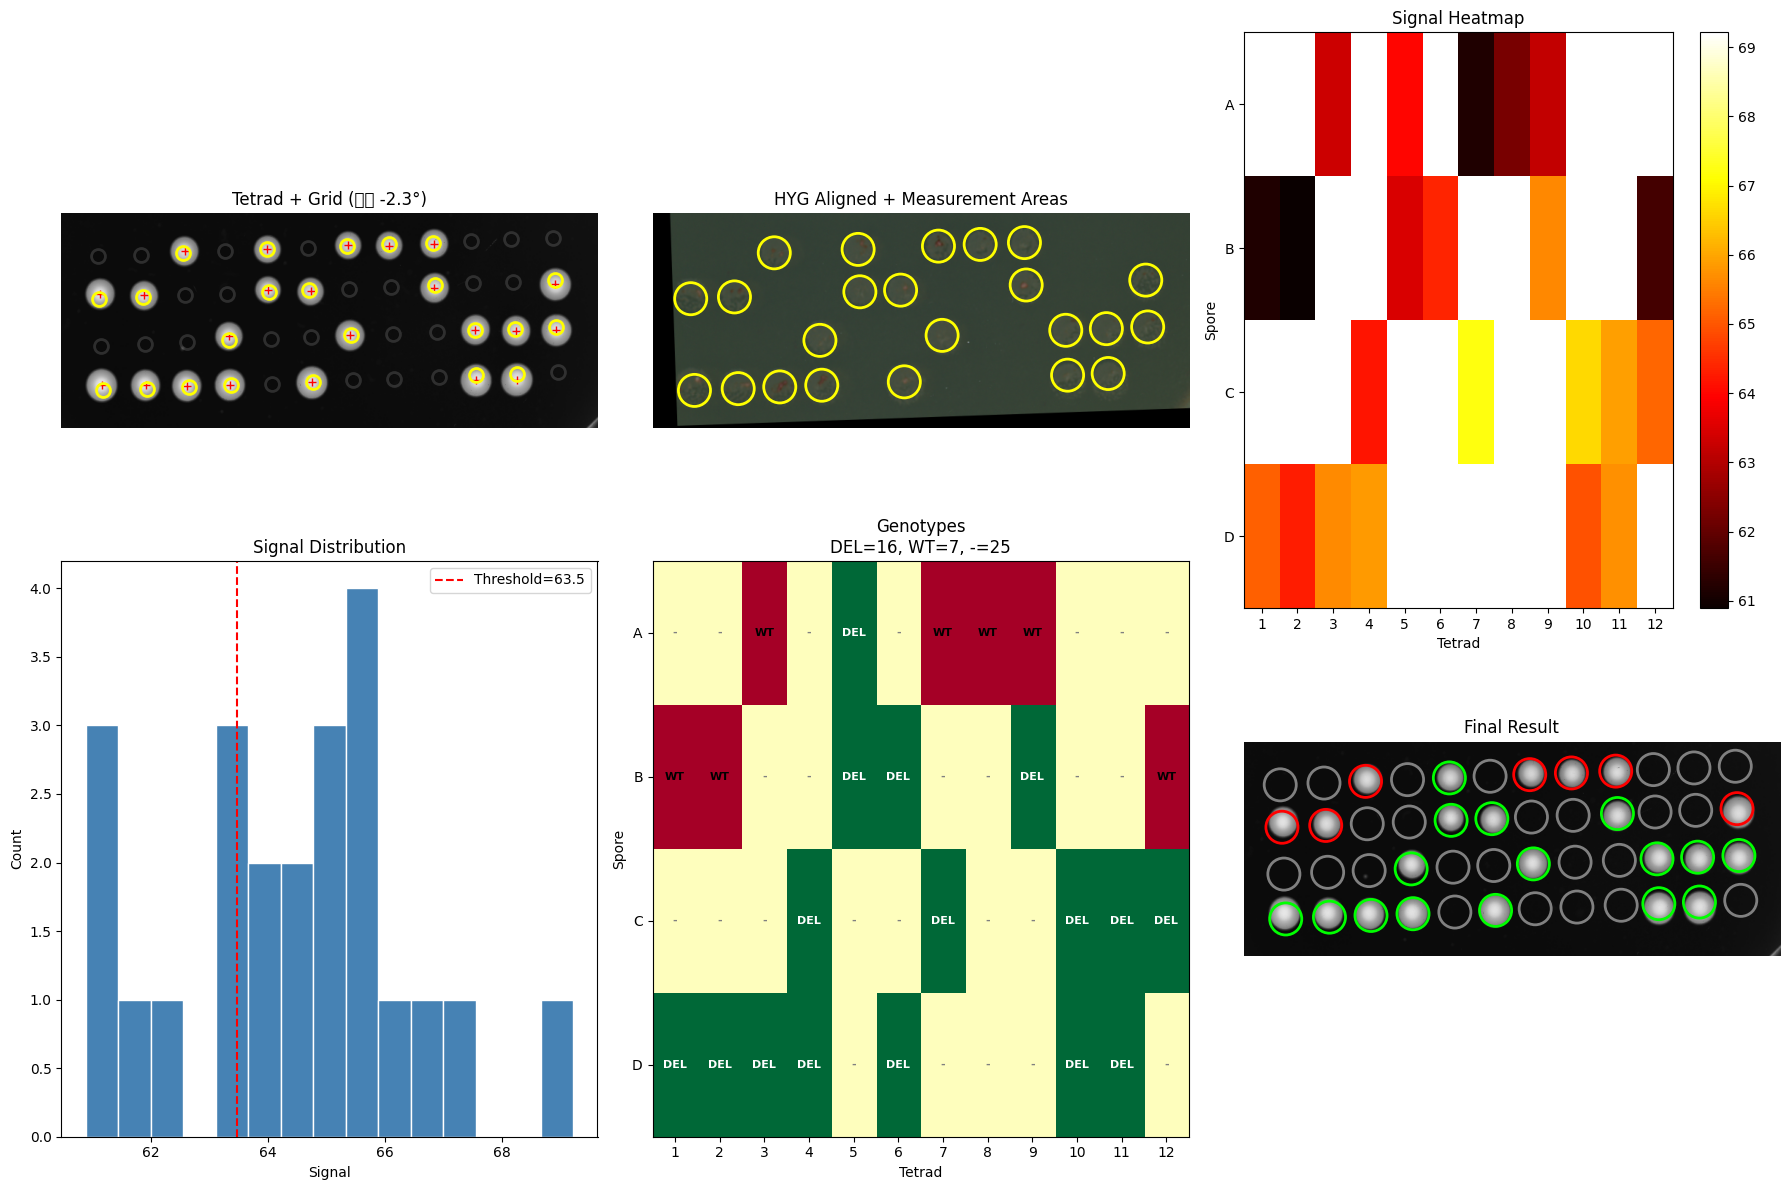



如需测试新图片，修改路径并运行:
results = analyze_tetrad_pair("/path/to/tetrad.png", "/path/to/hyg.png")


In [36]:
# ============================================================
# 便捷测试函数：一键分析新图片
# Quick Test Function for New Images
# ============================================================

def analyze_tetrad_pair(tetrad_path, hyg_path, expected_cols=12, max_rows=4, 
                        show_plots=True, use_rotation=True):
    """
    分析一对 Tetrad 和 HYG 图片。
    
    Args:
        tetrad_path: Tetrad 平板图片路径
        hyg_path: HYG 平板图片路径
        expected_cols: 期望的列数（tetrad 数）
        max_rows: 最大行数（孢子位置）
        show_plots: 是否显示图表
        use_rotation: 是否使用旋转校正
        
    Returns:
        results: 分析结果字典
    """
    from skimage import io
    from skimage.filters import gaussian, threshold_otsu
    from skimage.morphology import binary_opening, disk
    from skimage.measure import label, regionprops
    import cv2
    
    print("=" * 60)
    print("开始分析")
    print("=" * 60)
    print(f"Tetrad: {tetrad_path}")
    print(f"HYG: {hyg_path}")
    
    # 1. 读取图片
    tetrad_img = io.imread(tetrad_path)
    hyg_img = io.imread(hyg_path)
    
    print(f"\nTetrad 图片尺寸: {tetrad_img.shape}")
    print(f"HYG 图片尺寸: {hyg_img.shape}")
    
    # 2. 检测 Tetrad 菌落
    print("\n[Step 1] 检测 Tetrad 菌落...")
    
    # 转灰度
    if tetrad_img.ndim == 3:
        gray_tetrad = np.mean(tetrad_img, axis=2)
    else:
        gray_tetrad = tetrad_img.astype(float)
    
    # 模糊 + 阈值
    blurred = gaussian(gray_tetrad, sigma=2)
    thresh = threshold_otsu(blurred)
    binary = blurred > thresh
    
    # 形态学清理
    cleaned = binary_opening(binary, disk(3))
    
    # 标记区域
    labeled = label(cleaned)
    props = regionprops(labeled)
    
    # 提取质心（过滤小区域）
    min_area = 100
    centroids = [(p.centroid[1], p.centroid[0]) for p in props if p.area > min_area]
    print(f"检测到 {len(centroids)} 个菌落")
    
    # 3. 拟合网格
    print("\n[Step 2] 拟合自适应网格...")
    grid, grid_info = adaptive_grid_fitting(
        centroids,
        expected_cols=expected_cols,
        max_rows=max_rows
    )
    
    # 4. 对齐 HYG 图片
    print("\n[Step 3] 对齐 HYG 图片...")
    
    h_ref, w_ref = tetrad_img.shape[:2]
    
    # 调整 HYG 尺寸
    hyg_resized = cv2.resize(hyg_img, (w_ref, h_ref))
    
    # 检测 HYG 菌落（用于对齐）
    if hyg_resized.ndim == 3:
        gray_hyg = np.mean(hyg_resized, axis=2)
    else:
        gray_hyg = hyg_resized.astype(float)
    
    blurred_hyg = gaussian(gray_hyg, sigma=2)
    thresh_hyg = threshold_otsu(blurred_hyg)
    binary_hyg = blurred_hyg > thresh_hyg
    cleaned_hyg = binary_opening(binary_hyg, disk(3))
    
    labeled_hyg = label(cleaned_hyg)
    props_hyg = regionprops(labeled_hyg)
    centroids_hyg = [(p.centroid[1], p.centroid[0]) for p in props_hyg if p.area > min_area]
    
    print(f"HYG 检测到 {len(centroids_hyg)} 个菌落")
    
    # 使用 RANSAC 对齐
    if len(centroids) >= 4 and len(centroids_hyg) >= 4:
        pts_tetrad = np.array(centroids).astype(np.float32)
        pts_hyg = np.array(centroids_hyg).astype(np.float32)
        
        # 匹配点
        from scipy.spatial.distance import cdist
        from scipy.optimize import linear_sum_assignment
        
        dist_matrix = cdist(pts_tetrad, pts_hyg)
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        
        # 过滤距离太远的匹配
        max_dist = 50
        valid_mask = dist_matrix[row_ind, col_ind] < max_dist
        
        if np.sum(valid_mask) >= 4:
            matched_tetrad = pts_tetrad[row_ind[valid_mask]]
            matched_hyg = pts_hyg[col_ind[valid_mask]]
            
            M, inliers = cv2.estimateAffinePartial2D(
                matched_hyg.reshape(-1, 1, 2),
                matched_tetrad.reshape(-1, 1, 2),
                method=cv2.RANSAC
            )
            
            if M is not None:
                hyg_aligned = cv2.warpAffine(hyg_resized, M, (w_ref, h_ref))
                print(f"对齐成功，使用 {np.sum(inliers)} 个内点")
            else:
                hyg_aligned = hyg_resized
                print("对齐失败，使用原始 HYG")
        else:
            hyg_aligned = hyg_resized
            print("匹配点不足，使用原始 HYG")
    else:
        hyg_aligned = hyg_resized
        print("菌落数不足，使用原始 HYG")
    
    # 5. 测量信号和判断基因型
    print("\n[Step 4] 测量信号和判断基因型...")
    
    measure_radius = int(grid_info['row_height'] * 0.35)
    signals = np.full((max_rows, expected_cols), np.nan)
    
    for row in range(max_rows):
        for col in range(expected_cols):
            if grid_info['colony_presence'][row, col]:
                gx, gy = grid[row, col]
                gx, gy = int(round(gx)), int(round(gy))
                
                h, w = hyg_aligned.shape[:2]
                x1, x2 = max(0, gx - measure_radius), min(w, gx + measure_radius + 1)
                y1, y2 = max(0, gy - measure_radius), min(h, gy + measure_radius + 1)
                
                if x2 > x1 and y2 > y1:
                    region = hyg_aligned[y1:y2, x1:x2]
                    if region.ndim == 3:
                        region = region[:, :, 0]  # 红色通道
                    signals[row, col] = np.mean(region)
    
    # 计算阈值
    valid_signals = signals[~np.isnan(signals)]
    if len(valid_signals) > 2:
        threshold_val = threshold_otsu(valid_signals)
    else:
        threshold_val = np.median(valid_signals) if len(valid_signals) > 0 else 128
    
    # 判断基因型
    genotypes = np.where(signals > threshold_val, 'DEL', 'WT')
    genotypes = np.where(np.isnan(signals), '-', genotypes)
    
    # 统计
    del_count = np.sum(genotypes == 'DEL')
    wt_count = np.sum(genotypes == 'WT')
    no_colony = np.sum(genotypes == '-')
    
    print(f"\n结果:")
    print(f"  阈值: {threshold_val:.1f}")
    print(f"  DEL: {del_count}, WT: {wt_count}, 无菌落: {no_colony}")
    
    # 6. 可视化
    if show_plots:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Panel 1: Tetrad + 网格
        axes[0, 0].imshow(tetrad_img)
        for (x, y) in centroids:
            axes[0, 0].plot(x, y, 'r+', markersize=6)
        for row in range(max_rows):
            for col in range(expected_cols):
                gx, gy = grid[row, col]
                color = 'yellow' if grid_info['colony_presence'][row, col] else 'gray'
                alpha = 1.0 if grid_info['colony_presence'][row, col] else 0.3
                axes[0, 0].plot(gx, gy, 'o', color=color, markersize=10, 
                               markeredgewidth=2, fillstyle='none', alpha=alpha)
        axes[0, 0].set_title(f'Tetrad + Grid (旋转 {grid_info["angle_deg"]:.1f}°)')
        axes[0, 0].axis('off')
        
        # Panel 2: HYG aligned + 网格
        axes[0, 1].imshow(hyg_aligned)
        for row in range(max_rows):
            for col in range(expected_cols):
                gx, gy = grid[row, col]
                if grid_info['colony_presence'][row, col]:
                    circ = Circle((gx, gy), radius=measure_radius, 
                                 color='yellow', fill=False, linewidth=2)
                    axes[0, 1].add_patch(circ)
        axes[0, 1].set_title('HYG Aligned + Measurement Areas')
        axes[0, 1].axis('off')
        
        # Panel 3: 信号热图
        im = axes[0, 2].imshow(signals, cmap='hot', aspect='auto')
        axes[0, 2].set_title('Signal Heatmap')
        axes[0, 2].set_xlabel('Tetrad')
        axes[0, 2].set_ylabel('Spore')
        axes[0, 2].set_xticks(range(expected_cols))
        axes[0, 2].set_yticks(range(max_rows))
        axes[0, 2].set_xticklabels([str(i+1) for i in range(expected_cols)])
        axes[0, 2].set_yticklabels(['A', 'B', 'C', 'D'][:max_rows])
        plt.colorbar(im, ax=axes[0, 2])
        
        # Panel 4: 信号分布
        axes[1, 0].hist(valid_signals, bins=15, color='steelblue', edgecolor='white')
        axes[1, 0].axvline(threshold_val, color='red', linestyle='--', 
                          label=f'Threshold={threshold_val:.1f}')
        axes[1, 0].set_xlabel('Signal')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Signal Distribution')
        axes[1, 0].legend()
        
        # Panel 5: 基因型表格
        genotype_numeric = np.where(genotypes == 'DEL', 1, 
                                   np.where(genotypes == 'WT', 0, 0.5))
        axes[1, 1].imshow(genotype_numeric, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        for row in range(max_rows):
            for col in range(expected_cols):
                gt = genotypes[row, col]
                color = 'white' if gt == 'DEL' else ('black' if gt == 'WT' else 'gray')
                axes[1, 1].text(col, row, gt, ha='center', va='center', 
                               fontsize=8, color=color, fontweight='bold')
        axes[1, 1].set_title(f'Genotypes\nDEL={del_count}, WT={wt_count}, -={no_colony}')
        axes[1, 1].set_xlabel('Tetrad')
        axes[1, 1].set_ylabel('Spore')
        axes[1, 1].set_xticks(range(expected_cols))
        axes[1, 1].set_yticks(range(max_rows))
        axes[1, 1].set_xticklabels([str(i+1) for i in range(expected_cols)])
        axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'][:max_rows])
        
        # Panel 6: 最终结果
        axes[1, 2].imshow(tetrad_img)
        for row in range(max_rows):
            for col in range(expected_cols):
                gx, gy = grid[row, col]
                gt = genotypes[row, col]
                if gt == 'DEL':
                    color = 'lime'
                elif gt == 'WT':
                    color = 'red'
                else:
                    color = 'gray'
                circ = Circle((gx, gy), radius=measure_radius, 
                             color=color, fill=False, linewidth=2)
                axes[1, 2].add_patch(circ)
        axes[1, 2].set_title('Final Result')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # 返回结果
    results = {
        'genotypes': genotypes,
        'signals': signals,
        'threshold': threshold_val,
        'del_count': del_count,
        'wt_count': wt_count,
        'no_colony': no_colony,
        'grid': grid,
        'grid_info': grid_info,
        'centroids': centroids,
        'hyg_aligned': hyg_aligned
    }
    
    return results


# ============================================================
# 测试：使用当前图片
# ============================================================

print("\n" + "=" * 60)
print("使用便捷函数测试当前图片")
print("=" * 60)

results = analyze_tetrad_pair(TETRAD_PATH, HYG_PATH)

print("\n\n如需测试新图片，修改路径并运行:")
print('results = analyze_tetrad_pair("/path/to/tetrad.png", "/path/to/hyg.png")')

---
## 🔬 改进 HYG 信号检测：解决 Essential Gene 问题

### 问题分析

对于 **Essential Gene** 的情况：
- **Tetrad 平板**: 只有 2 个 WT 孢子能长，2 个 Deletion 致死不长
- **HYG 平板**: WT 没有 HYG 抗性，所以**转印后不会长出菌落**
- 但转印过程会留下微弱的痕迹（细胞残留），这被错误地当成了信号

### 解决方案

1. **背景建模**: 计算 HYG 平板的背景强度
2. **信噪比 (SNR)**: 用 `(信号 - 背景) / 背景标准差` 判断
3. **局部对比度**: 比较网格位置与周围区域的差异
4. **双阈值策略**: 
   - 绝对阈值：信号必须高于某个最低值
   - 相对阈值：信号必须显著高于背景

### 关键指标

- **信噪比 (SNR)** > 2-3 才认为有真实信号
- **局部对比度** > 1.2-1.5 才认为有真实生长

改进的 HYG 信号检测 (Essential Gene 优化)

[Step 1] 估计背景强度...
背景: 均值=57.0, 标准差=22.5

[Step 2] 测量信号和计算 SNR...
背景统计: 均值=57.0, 标准差=22.5

信号统计:
  原始信号范围: 63.9 - 69.9
  SNR 范围: 0.31 - 0.57
  局部对比度范围: 1.12 - 1.35

[Step 3] 基因型判断...
  SNR阈值=1.5: DEL=0, WT=23
  SNR阈值=2.0: DEL=0, WT=23
  SNR阈值=2.5: DEL=0, WT=23
  SNR阈值=3.0: DEL=0, WT=23

最终结果 (SNR>2.0, Contrast>1.15):
  DEL: 0
  WT: 23
  无菌落: 25


/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1411429456.py:465: UserWarning: Glyph 38408 (\N

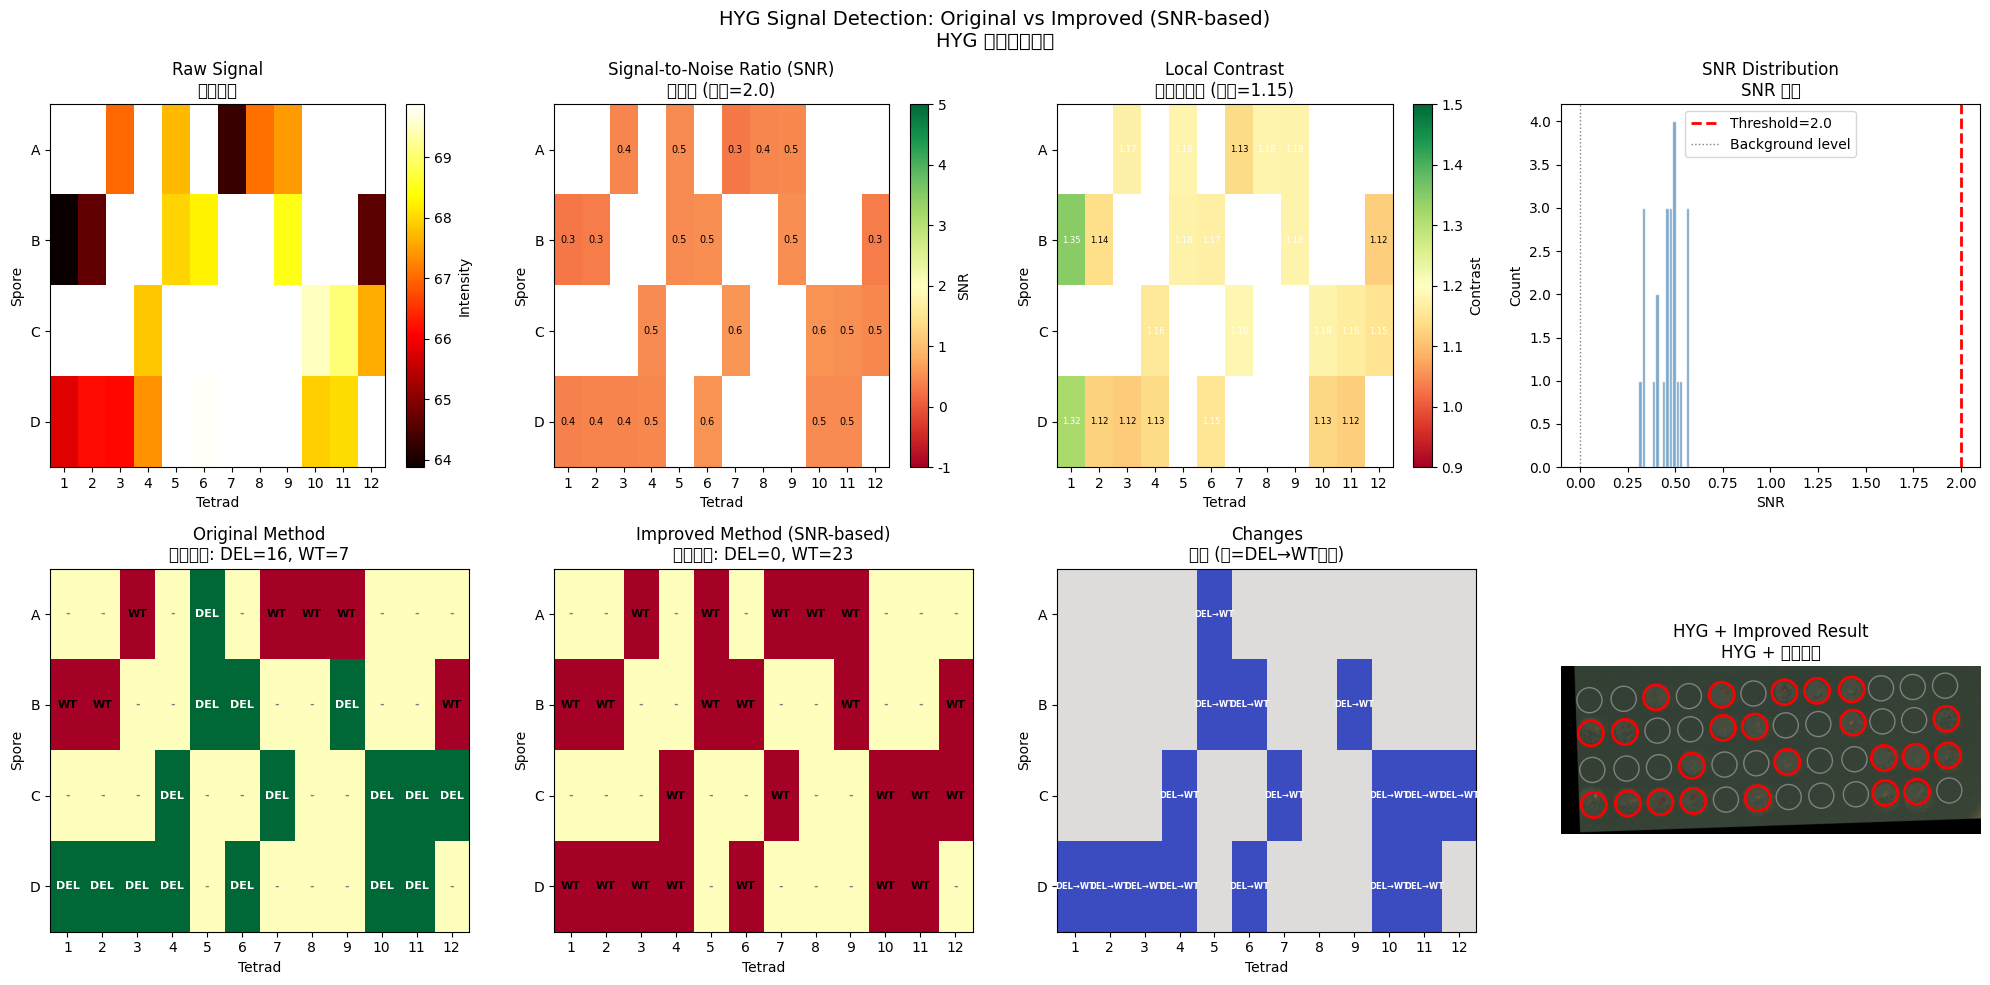


按 Tetrad 详细分析
Tetrad  1: [np.str_('-'), np.str_('WT'), np.str_('-'), np.str_('WT')] | SNR: [-, 0.3, -, 0.4]
           → DEL:WT:Dead = 0:2:2
Tetrad  2: [np.str_('-'), np.str_('WT'), np.str_('-'), np.str_('WT')] | SNR: [-, 0.3, -, 0.4]
           → DEL:WT:Dead = 0:2:2
Tetrad  3: [np.str_('WT'), np.str_('-'), np.str_('-'), np.str_('WT')] | SNR: [0.4, -, -, 0.4]
           → DEL:WT:Dead = 0:2:2
Tetrad  4: [np.str_('-'), np.str_('-'), np.str_('WT'), np.str_('WT')] | SNR: [-, -, 0.5, 0.5]
           → DEL:WT:Dead = 0:2:2
Tetrad  5: [np.str_('WT'), np.str_('WT'), np.str_('-'), np.str_('-')] | SNR: [0.5, 0.5, -, -]
           → DEL:WT:Dead = 0:2:2
Tetrad  6: [np.str_('-'), np.str_('WT'), np.str_('-'), np.str_('WT')] | SNR: [-, 0.5, -, 0.6]
           → DEL:WT:Dead = 0:2:2
Tetrad  7: [np.str_('WT'), np.str_('-'), np.str_('WT'), np.str_('-')] | SNR: [0.3, -, 0.6, -]
           → DEL:WT:Dead = 0:2:2
Tetrad  8: [np.str_('WT'), np.str_('-'), np.str_('-'), np.str_('-')] | SNR: [0.4, -, -, -]
     

In [37]:
# ============================================================
# 改进的 HYG 信号检测方法
# Improved HYG Signal Detection for Essential Gene Cases
# ============================================================

def estimate_background(image, grid, grid_info, margin=1.5):
    """
    估计 HYG 平板的背景强度。
    
    方法：采样网格点之间的区域（这些区域应该没有菌落）
    
    Args:
        image: HYG 图像
        grid: 网格中心点
        grid_info: 网格参数
        margin: 采样点距离网格点的倍数
        
    Returns:
        bg_mean: 背景平均值
        bg_std: 背景标准差
    """
    h, w = image.shape[:2]
    
    # 转灰度
    if image.ndim == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image.astype(float)
    
    n_rows, n_cols = grid.shape[:2]
    x_spacing = grid_info.get('col_width', grid_info.get('x_spacing', 50))
    y_spacing = grid_info.get('row_height', grid_info.get('y_spacing', 50))
    
    # 在网格点之间采样背景
    bg_samples = []
    
    # 方法1: 在列之间采样
    for row in range(n_rows):
        for col in range(n_cols - 1):
            # 取两个相邻网格点的中点
            x1, y1 = grid[row, col]
            x2, y2 = grid[row, col + 1]
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            
            ix, iy = int(round(mid_x)), int(round(mid_y))
            
            if 5 < ix < w - 5 and 5 < iy < h - 5:
                # 采样小区域
                region = gray[iy-3:iy+4, ix-3:ix+4]
                bg_samples.append(np.mean(region))
    
    # 方法2: 在行之间采样
    for row in range(n_rows - 1):
        for col in range(n_cols):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row + 1, col]
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            
            ix, iy = int(round(mid_x)), int(round(mid_y))
            
            if 5 < ix < w - 5 and 5 < iy < h - 5:
                region = gray[iy-3:iy+4, ix-3:ix+4]
                bg_samples.append(np.mean(region))
    
    # 方法3: 图像边缘采样（假设边缘没有菌落）
    edge_margin = 20
    edge_samples = []
    
    # 上边缘
    if h > 2 * edge_margin:
        edge_samples.extend(gray[5:15, edge_margin:-edge_margin].flatten())
    # 下边缘
    if h > 2 * edge_margin:
        edge_samples.extend(gray[-15:-5, edge_margin:-edge_margin].flatten())
    
    bg_samples.extend(np.random.choice(edge_samples, min(100, len(edge_samples)), replace=False) if edge_samples else [])
    
    if len(bg_samples) > 0:
        bg_samples = np.array(bg_samples)
        bg_mean = np.median(bg_samples)  # 用中位数更稳健
        bg_std = np.std(bg_samples)
    else:
        # 备用：用整个图像的统计
        bg_mean = np.median(gray)
        bg_std = np.std(gray) / 2
    
    return bg_mean, bg_std


def measure_signal_with_snr(image, grid, grid_info, radius=None, 
                            bg_mean=None, bg_std=None):
    """
    测量信号强度，并计算信噪比 (SNR)。
    
    Args:
        image: HYG 图像
        grid: 网格中心点
        grid_info: 网格参数
        radius: 测量半径
        bg_mean: 背景均值（如果为 None 则自动计算）
        bg_std: 背景标准差
        
    Returns:
        raw_signals: 原始信号矩阵
        snr: 信噪比矩阵
        local_contrast: 局部对比度矩阵
    """
    if image.ndim == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image.astype(float)
    
    h, w = gray.shape
    n_rows, n_cols = grid.shape[:2]
    
    if radius is None:
        y_spacing = grid_info.get('row_height', grid_info.get('y_spacing', 50))
        radius = int(y_spacing * 0.35)
    
    # 估计背景
    if bg_mean is None or bg_std is None:
        bg_mean, bg_std = estimate_background(image, grid, grid_info)
    
    print(f"背景统计: 均值={bg_mean:.1f}, 标准差={bg_std:.1f}")
    
    raw_signals = np.full((n_rows, n_cols), np.nan)
    snr = np.full((n_rows, n_cols), np.nan)
    local_contrast = np.full((n_rows, n_cols), np.nan)
    
    # 创建圆形掩码
    y_grid, x_grid = np.ogrid[-radius:radius+1, -radius:radius+1]
    circle_mask = x_grid**2 + y_grid**2 <= radius**2
    
    # 创建环形掩码（用于计算局部背景）
    outer_radius = int(radius * 1.8)
    y_grid2, x_grid2 = np.ogrid[-outer_radius:outer_radius+1, -outer_radius:outer_radius+1]
    ring_mask = (x_grid2**2 + y_grid2**2 > radius**2) & \
                (x_grid2**2 + y_grid2**2 <= outer_radius**2)
    
    for row in range(n_rows):
        for col in range(n_cols):
            if not grid_info['colony_presence'][row, col]:
                continue
                
            gx, gy = grid[row, col]
            gx, gy = int(round(gx)), int(round(gy))
            
            # 测量中心区域信号
            x1, x2 = max(0, gx - radius), min(w, gx + radius + 1)
            y1, y2 = max(0, gy - radius), min(h, gy + radius + 1)
            
            if x2 > x1 + 5 and y2 > y1 + 5:
                center_region = gray[y1:y2, x1:x2]
                
                # 调整掩码大小
                mask_y1 = radius - (gy - y1)
                mask_y2 = mask_y1 + (y2 - y1)
                mask_x1 = radius - (gx - x1)
                mask_x2 = mask_x1 + (x2 - x1)
                
                if mask_y2 <= circle_mask.shape[0] and mask_x2 <= circle_mask.shape[1]:
                    local_mask = circle_mask[mask_y1:mask_y2, mask_x1:mask_x2]
                    
                    if local_mask.sum() > 0 and local_mask.shape == center_region.shape:
                        center_signal = center_region[local_mask].mean()
                    else:
                        center_signal = np.mean(center_region)
                else:
                    center_signal = np.mean(center_region)
                
                raw_signals[row, col] = center_signal
                
                # 计算信噪比
                if bg_std > 0:
                    snr[row, col] = (center_signal - bg_mean) / bg_std
                else:
                    snr[row, col] = 0
                
                # 计算局部对比度（与周围环形区域比较）
                ox1, ox2 = max(0, gx - outer_radius), min(w, gx + outer_radius + 1)
                oy1, oy2 = max(0, gy - outer_radius), min(h, gy + outer_radius + 1)
                
                if ox2 > ox1 + 10 and oy2 > oy1 + 10:
                    outer_region = gray[oy1:oy2, ox1:ox2]
                    
                    # 简化：直接用外圈平均值
                    ring_y1 = outer_radius - (gy - oy1)
                    ring_y2 = ring_y1 + (oy2 - oy1)
                    ring_x1 = outer_radius - (gx - ox1)
                    ring_x2 = ring_x1 + (ox2 - ox1)
                    
                    if ring_y2 <= ring_mask.shape[0] and ring_x2 <= ring_mask.shape[1]:
                        local_ring = ring_mask[ring_y1:ring_y2, ring_x1:ring_x2]
                        
                        if local_ring.sum() > 0 and local_ring.shape == outer_region.shape:
                            ring_signal = outer_region[local_ring].mean()
                            if ring_signal > 0:
                                local_contrast[row, col] = center_signal / ring_signal
    
    return raw_signals, snr, local_contrast


def genotype_with_snr(raw_signals, snr, local_contrast, 
                      snr_threshold=2.0, 
                      contrast_threshold=1.15,
                      absolute_threshold=None):
    """
    基于信噪比和局部对比度判断基因型。
    
    规则：
    - 信号必须同时满足 SNR > snr_threshold 和 对比度 > contrast_threshold
    - 否则认为是背景/痕迹，判断为 WT
    
    Args:
        raw_signals: 原始信号
        snr: 信噪比
        local_contrast: 局部对比度
        snr_threshold: SNR 阈值
        contrast_threshold: 局部对比度阈值
        absolute_threshold: 绝对信号阈值（可选）
        
    Returns:
        genotypes: 基因型矩阵
        confidence: 置信度矩阵
    """
    n_rows, n_cols = raw_signals.shape
    genotypes = np.full((n_rows, n_cols), '-', dtype='<U3')
    confidence = np.full((n_rows, n_cols), np.nan)
    
    for row in range(n_rows):
        for col in range(n_cols):
            if np.isnan(raw_signals[row, col]):
                genotypes[row, col] = '-'
                continue
            
            signal = raw_signals[row, col]
            s = snr[row, col]
            c = local_contrast[row, col]
            
            # 判断条件
            is_real_signal = True
            
            # 条件1: SNR 必须足够高
            if not np.isnan(s) and s < snr_threshold:
                is_real_signal = False
            
            # 条件2: 局部对比度必须足够高
            if not np.isnan(c) and c < contrast_threshold:
                is_real_signal = False
            
            # 条件3: 绝对信号阈值（如果提供）
            if absolute_threshold is not None and signal < absolute_threshold:
                is_real_signal = False
            
            if is_real_signal:
                genotypes[row, col] = 'DEL'
                # 置信度基于 SNR
                confidence[row, col] = min(1.0, s / 5.0) if not np.isnan(s) else 0.5
            else:
                genotypes[row, col] = 'WT'
                confidence[row, col] = min(1.0, (snr_threshold - s) / snr_threshold) if not np.isnan(s) else 0.5
    
    return genotypes, confidence


# ============================================================
# 应用改进的信号检测到当前数据
# ============================================================

print("=" * 60)
print("改进的 HYG 信号检测 (Essential Gene 优化)")
print("=" * 60)

# 使用当前的 results 数据
hyg_img = results['hyg_aligned']
grid = results['grid']
grid_info = results['grid_info']

# 步骤1: 估计背景
print("\n[Step 1] 估计背景强度...")
bg_mean, bg_std = estimate_background(hyg_img, grid, grid_info)
print(f"背景: 均值={bg_mean:.1f}, 标准差={bg_std:.1f}")

# 步骤2: 测量信号和计算 SNR
print("\n[Step 2] 测量信号和计算 SNR...")
raw_signals, snr, local_contrast = measure_signal_with_snr(
    hyg_img, grid, grid_info,
    bg_mean=bg_mean, bg_std=bg_std
)

# 打印统计
valid_snr = snr[~np.isnan(snr)]
valid_contrast = local_contrast[~np.isnan(local_contrast)]

print(f"\n信号统计:")
print(f"  原始信号范围: {np.nanmin(raw_signals):.1f} - {np.nanmax(raw_signals):.1f}")
print(f"  SNR 范围: {valid_snr.min():.2f} - {valid_snr.max():.2f}")
print(f"  局部对比度范围: {valid_contrast.min():.2f} - {valid_contrast.max():.2f}")

# 步骤3: 用不同阈值判断基因型
print("\n[Step 3] 基因型判断...")

# 尝试不同的 SNR 阈值
for snr_th in [1.5, 2.0, 2.5, 3.0]:
    genotypes_test, _ = genotype_with_snr(
        raw_signals, snr, local_contrast,
        snr_threshold=snr_th,
        contrast_threshold=1.1
    )
    del_n = np.sum(genotypes_test == 'DEL')
    wt_n = np.sum(genotypes_test == 'WT')
    print(f"  SNR阈值={snr_th:.1f}: DEL={del_n}, WT={wt_n}")

# 使用推荐的阈值
snr_threshold = 2.0
contrast_threshold = 1.15

genotypes_improved, confidence = genotype_with_snr(
    raw_signals, snr, local_contrast,
    snr_threshold=snr_threshold,
    contrast_threshold=contrast_threshold
)

del_count_improved = np.sum(genotypes_improved == 'DEL')
wt_count_improved = np.sum(genotypes_improved == 'WT')
no_colony_improved = np.sum(genotypes_improved == '-')

print(f"\n最终结果 (SNR>{snr_threshold}, Contrast>{contrast_threshold}):")
print(f"  DEL: {del_count_improved}")
print(f"  WT: {wt_count_improved}")
print(f"  无菌落: {no_colony_improved}")

# ============================================================
# 可视化对比
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: 信号分析
# Panel 1: 原始信号热图
im1 = axes[0, 0].imshow(raw_signals, cmap='hot', aspect='auto')
axes[0, 0].set_title('Raw Signal\n原始信号')
axes[0, 0].set_xlabel('Tetrad')
axes[0, 0].set_ylabel('Spore')
plt.colorbar(im1, ax=axes[0, 0], label='Intensity')

# Panel 2: SNR 热图
im2 = axes[0, 1].imshow(snr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
axes[0, 1].set_title(f'Signal-to-Noise Ratio (SNR)\n信噪比 (阈值={snr_threshold})')
axes[0, 1].set_xlabel('Tetrad')
axes[0, 1].set_ylabel('Spore')
plt.colorbar(im2, ax=axes[0, 1], label='SNR')

# 标注阈值线
for row in range(4):
    for col in range(12):
        if not np.isnan(snr[row, col]):
            color = 'white' if snr[row, col] >= snr_threshold else 'black'
            axes[0, 1].text(col, row, f'{snr[row, col]:.1f}', 
                           ha='center', va='center', fontsize=7, color=color)

# Panel 3: 局部对比度热图
im3 = axes[0, 2].imshow(local_contrast, cmap='RdYlGn', aspect='auto', vmin=0.9, vmax=1.5)
axes[0, 2].set_title(f'Local Contrast\n局部对比度 (阈值={contrast_threshold})')
axes[0, 2].set_xlabel('Tetrad')
axes[0, 2].set_ylabel('Spore')
plt.colorbar(im3, ax=axes[0, 2], label='Contrast')

for row in range(4):
    for col in range(12):
        if not np.isnan(local_contrast[row, col]):
            color = 'white' if local_contrast[row, col] >= contrast_threshold else 'black'
            axes[0, 2].text(col, row, f'{local_contrast[row, col]:.2f}', 
                           ha='center', va='center', fontsize=6, color=color)

# Panel 4: SNR 分布
axes[0, 3].hist(valid_snr, bins=15, color='steelblue', edgecolor='white', alpha=0.7)
axes[0, 3].axvline(snr_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold={snr_threshold}')
axes[0, 3].axvline(0, color='gray', linestyle=':', linewidth=1, label='Background level')
axes[0, 3].set_xlabel('SNR')
axes[0, 3].set_ylabel('Count')
axes[0, 3].set_title('SNR Distribution\nSNR 分布')
axes[0, 3].legend()

# Row 2: 基因型对比
# Panel 5: 原始方法结果
original_genotypes = results['genotypes']
gt_numeric_orig = np.where(original_genotypes == 'DEL', 1, 
                           np.where(original_genotypes == 'WT', 0, 0.5))
axes[1, 0].imshow(gt_numeric_orig, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        gt = original_genotypes[row, col]
        color = 'white' if gt == 'DEL' else ('black' if gt == 'WT' else 'gray')
        axes[1, 0].text(col, row, gt, ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 0].set_title(f'Original Method\n原始方法: DEL={results["del_count"]}, WT={results["wt_count"]}')
axes[1, 0].set_xlabel('Tetrad')
axes[1, 0].set_ylabel('Spore')

# Panel 6: 改进方法结果
gt_numeric_new = np.where(genotypes_improved == 'DEL', 1, 
                          np.where(genotypes_improved == 'WT', 0, 0.5))
axes[1, 1].imshow(gt_numeric_new, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        gt = genotypes_improved[row, col]
        color = 'white' if gt == 'DEL' else ('black' if gt == 'WT' else 'gray')
        axes[1, 1].text(col, row, gt, ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 1].set_title(f'Improved Method (SNR-based)\n改进方法: DEL={del_count_improved}, WT={wt_count_improved}')
axes[1, 1].set_xlabel('Tetrad')
axes[1, 1].set_ylabel('Spore')

# Panel 7: 变化对比
changed = original_genotypes != genotypes_improved
change_map = np.where(changed & (original_genotypes == 'DEL'), -1,  # DEL -> WT (修正)
             np.where(changed & (genotypes_improved == 'DEL'), 1,    # WT -> DEL
             0))
axes[1, 2].imshow(change_map, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
for row in range(4):
    for col in range(12):
        if changed[row, col]:
            old = original_genotypes[row, col]
            new = genotypes_improved[row, col]
            axes[1, 2].text(col, row, f'{old}→{new}', ha='center', va='center', 
                           fontsize=6, color='white', fontweight='bold')
axes[1, 2].set_title(f'Changes\n变化 (蓝=DEL→WT修正)')
axes[1, 2].set_xlabel('Tetrad')
axes[1, 2].set_ylabel('Spore')

# Panel 8: HYG 图像 + 结果
axes[1, 3].imshow(hyg_img)
measure_radius = int(grid_info.get('row_height', 50) * 0.35)
for row in range(4):
    for col in range(12):
        gx, gy = grid[row, col]
        gt = genotypes_improved[row, col]
        if gt == 'DEL':
            color = 'lime'
            linewidth = 3
        elif gt == 'WT':
            color = 'red'
            linewidth = 2
        else:
            color = 'gray'
            linewidth = 1
        circ = Circle((gx, gy), radius=measure_radius, 
                     color=color, fill=False, linewidth=linewidth)
        axes[1, 3].add_patch(circ)
axes[1, 3].set_title('HYG + Improved Result\nHYG + 改进结果')
axes[1, 3].axis('off')

# 设置 Y 轴标签
for i in range(4):
    for j in range(3):
        if j < 3:
            axes[i // 2, j].set_xticks(range(12))
            axes[i // 2, j].set_yticks(range(4))
            axes[i // 2, j].set_xticklabels([str(k+1) for k in range(12)])
            axes[i // 2, j].set_yticklabels(['A', 'B', 'C', 'D'])

plt.suptitle('HYG Signal Detection: Original vs Improved (SNR-based)\nHYG 信号检测对比', fontsize=14)
plt.tight_layout()
plt.show()

# 按 Tetrad 分析
print("\n" + "=" * 60)
print("按 Tetrad 详细分析")
print("=" * 60)

for col in range(12):
    tetrad_gt = [genotypes_improved[row, col] for row in range(4)]
    tetrad_snr = [snr[row, col] for row in range(4)]
    
    del_n = tetrad_gt.count('DEL')
    wt_n = tetrad_gt.count('WT')
    dead_n = tetrad_gt.count('-')
    
    snr_str = ', '.join([f'{s:.1f}' if not np.isnan(s) else '-' for s in tetrad_snr])
    
    print(f"Tetrad {col+1:2d}: {tetrad_gt} | SNR: [{snr_str}]")
    print(f"           → DEL:WT:Dead = {del_n}:{wt_n}:{dead_n}")

---
## ✅ 验证：SNR 方法是否同时适用于 Essential 和 Non-Essential Gene？

### 分析

让我们用 **Non-Essential Gene** 的图片来测试 SNR 方法：

| 基因类型 | Tetrad 平板 | HYG 平板 | 预期结果 |
|---------|------------|---------|---------|
| **Non-Essential** | 4 个孢子都长 | DEL 有 HYG 抗性，能长；WT 不长 | DEL:WT ≈ 2:2 |
| **Essential** | 2 WT 长，2 DEL 不长 | WT 无抗性，不长；DEL 致死 | 全部 WT |

### 测试方案

用 Non-Essential Gene 的图片测试，看 SNR 方法能否正确识别真正的 HYG 抗性菌落。

测试 SNR 方法对 Non-Essential Gene 的效果

使用 Non-Essential Gene 图片:
  Tetrad: 302_meu23_3d_#2_202511.cropped.png
  HYG: 302_meu23_HYG_#2_202511.cropped.png
开始分析
Tetrad: /hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/3d/302_meu23_3d_#2_202511.cropped.png
HYG: /hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/302_meu23_HYG_#2_202511.cropped.png

Tetrad 图片尺寸: (294, 735, 3)
HYG 图片尺寸: (294, 735, 3)

[Step 1] 检测 Tetrad 菌落...
检测到 43 个菌落

[Step 2] 拟合自适应网格...
输入 43 个质心点
检测到的旋转角度: -0.37°
每行菌落数: [np.int64(10), np.int64(12), np.int64(10), np.int64(11)]
活跃行: [0, 1, 2, 3] (共 4 行)

[Step 3] 对齐 HYG 图片...
HYG 检测到 20 个菌落
对齐成功，使用 13 个内点

[Step 4] 测量信号和判断基因型...

结果:
  阈值: 125.4
  DEL: 19, WT: 24, 无菌落: 5


/tmp/ipykernel_1714547/1849387602.py:267: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/1849387602.py:267: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


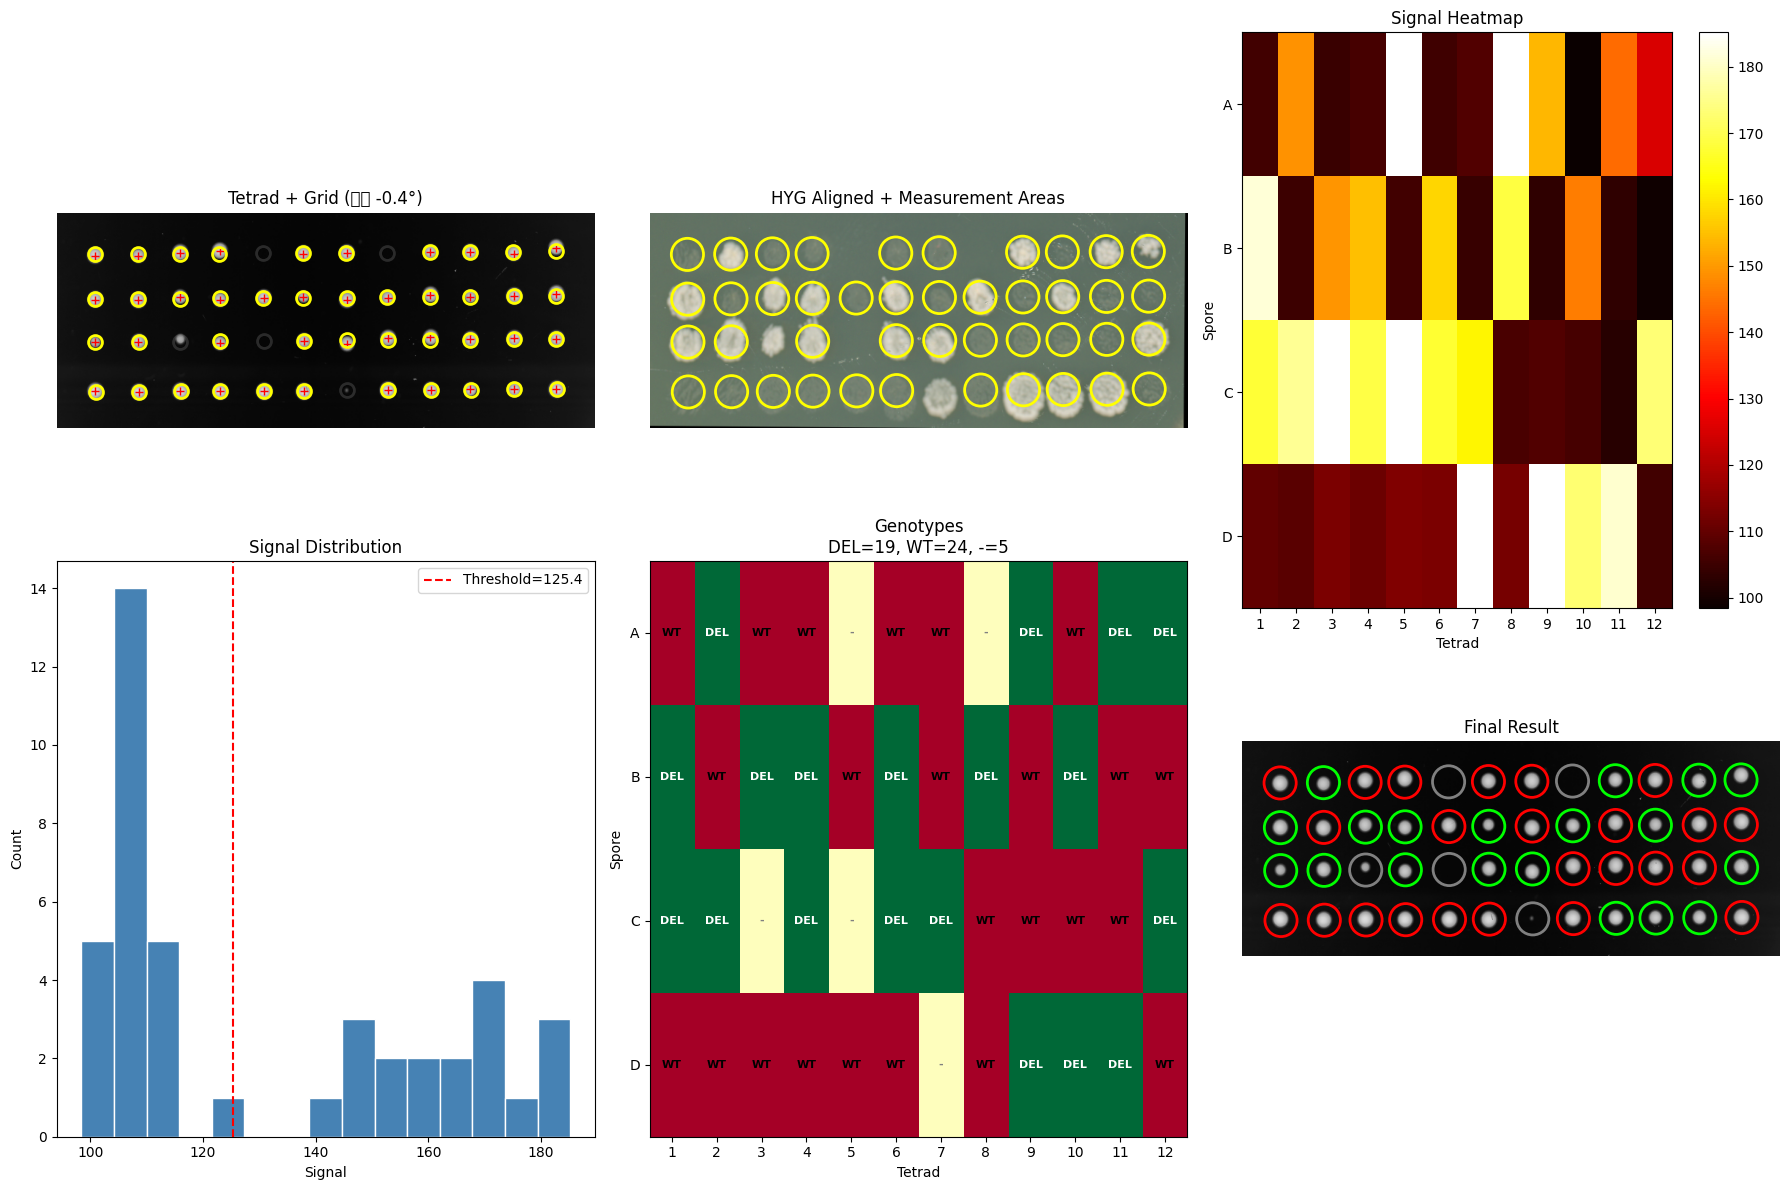


----------------------------------------
应用 SNR 方法...
----------------------------------------
背景: 均值=103.7, 标准差=7.8
背景统计: 均值=103.7, 标准差=7.8

SNR 统计:
  范围: 0.32 - 10.89
  均值: 4.57
  中位数: 1.86

不同 SNR 阈值的结果:
  SNR阈值=1.0: DEL=20, WT=23
  SNR阈值=1.5: DEL=19, WT=24
  SNR阈值=2.0: DEL=19, WT=24
  SNR阈值=2.5: DEL=19, WT=24
  SNR阈值=3.0: DEL=19, WT=24

最终结果对比 (Non-Essential Gene):
  原始方法: DEL=19, WT=24
  SNR方法:  DEL=19, WT=24


/tmp/ipykernel_1714547/3512845577.py:152: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1714547/3512845577.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/a/yangyusheng/.local/share/mamba/envs/opencv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


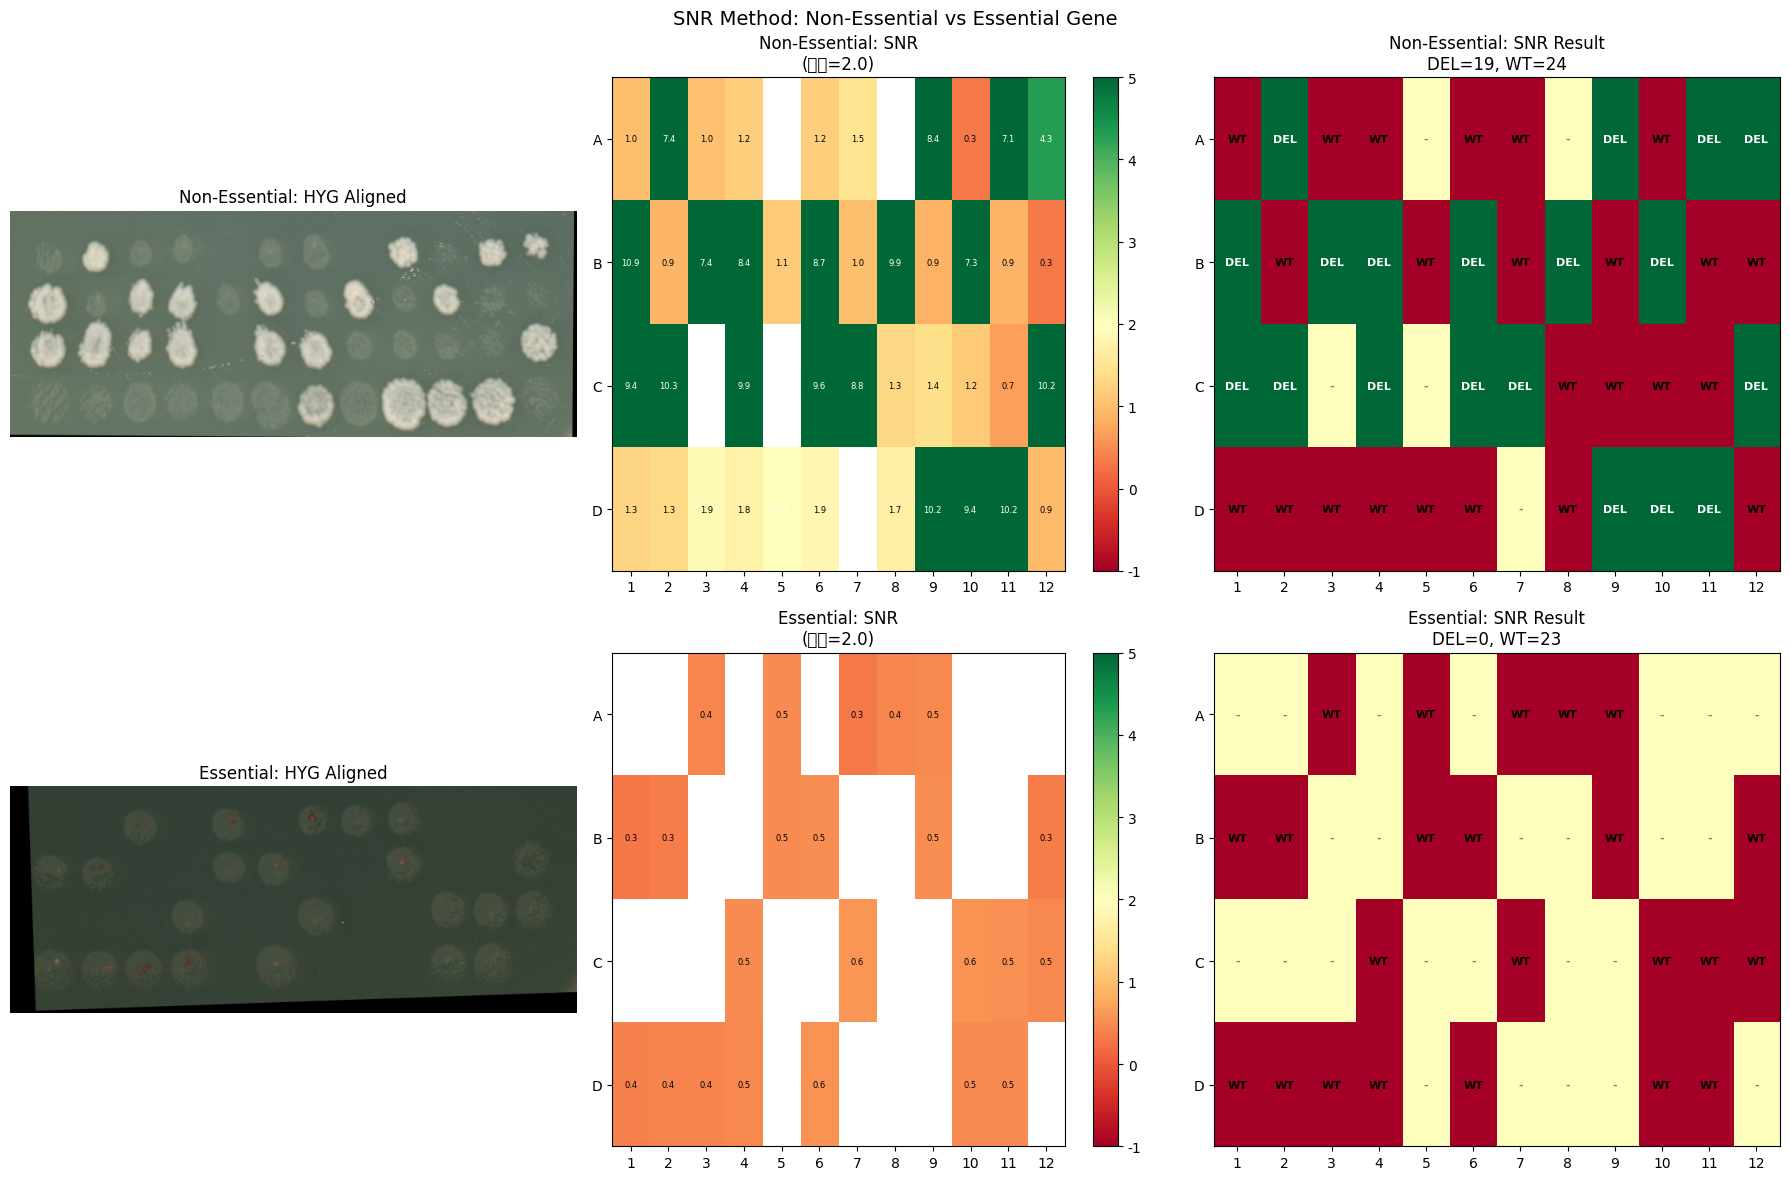

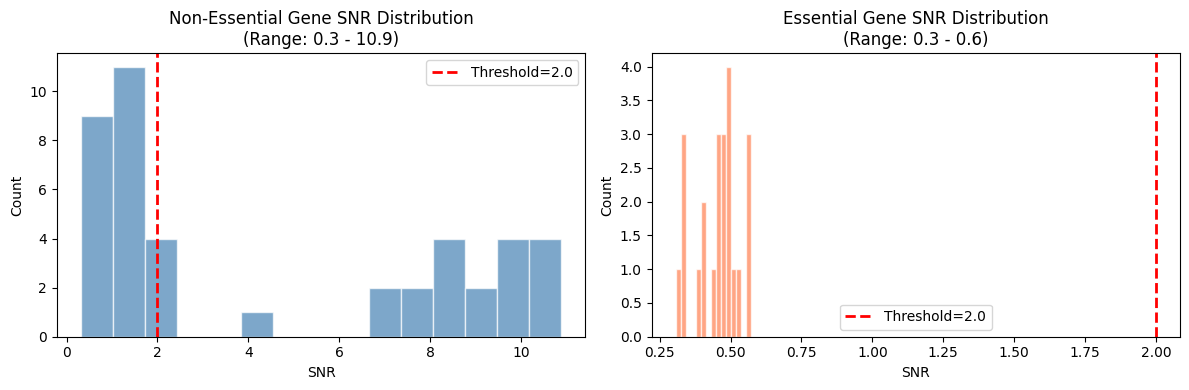


总结

    Non-Essential Gene:
      - SNR 范围: 0.3 - 10.9
      - 结果: DEL=19, WT=24
      - 说明: SNR > 2 的位置被正确识别为 DEL (有真实信号)

    Essential Gene:
      - SNR 范围: 0.3 - 0.6
      - 结果: DEL=0, WT=23
      - 说明: 所有 SNR < 2，没有真实信号，全部判断为 WT

    结论: SNR 方法可以同时适用于两种情况！
    - 对于 Non-Essential Gene: 能正确识别真实的 HYG 抗性菌落
    - 对于 Essential Gene: 能正确过滤掉转印痕迹的假信号
    


In [38]:
# ============================================================
# 测试 SNR 方法对 Non-Essential Gene 的效果
# Test SNR Method on Non-Essential Gene
# ============================================================

# Non-Essential Gene 图片 (之前用过的)
NON_ESSENTIAL_TETRAD = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/3d/302_meu23_3d_#2_202511.cropped.png"
NON_ESSENTIAL_HYG = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/302_meu23_HYG_#2_202511.cropped.png"

print("=" * 60)
print("测试 SNR 方法对 Non-Essential Gene 的效果")
print("=" * 60)

# 检查文件是否存在
import os
if os.path.exists(NON_ESSENTIAL_TETRAD) and os.path.exists(NON_ESSENTIAL_HYG):
    print(f"\n使用 Non-Essential Gene 图片:")
    print(f"  Tetrad: {NON_ESSENTIAL_TETRAD.split('/')[-1]}")
    print(f"  HYG: {NON_ESSENTIAL_HYG.split('/')[-1]}")
    
    # 运行分析
    results_non_essential = analyze_tetrad_pair(NON_ESSENTIAL_TETRAD, NON_ESSENTIAL_HYG)
    
    # 应用 SNR 方法
    print("\n" + "-" * 40)
    print("应用 SNR 方法...")
    print("-" * 40)
    
    hyg_img_ne = results_non_essential['hyg_aligned']
    grid_ne = results_non_essential['grid']
    grid_info_ne = results_non_essential['grid_info']
    
    # 估计背景
    bg_mean_ne, bg_std_ne = estimate_background(hyg_img_ne, grid_ne, grid_info_ne)
    print(f"背景: 均值={bg_mean_ne:.1f}, 标准差={bg_std_ne:.1f}")
    
    # 测量信号
    raw_signals_ne, snr_ne, local_contrast_ne = measure_signal_with_snr(
        hyg_img_ne, grid_ne, grid_info_ne,
        bg_mean=bg_mean_ne, bg_std=bg_std_ne
    )
    
    # 打印 SNR 统计
    valid_snr_ne = snr_ne[~np.isnan(snr_ne)]
    print(f"\nSNR 统计:")
    print(f"  范围: {valid_snr_ne.min():.2f} - {valid_snr_ne.max():.2f}")
    print(f"  均值: {valid_snr_ne.mean():.2f}")
    print(f"  中位数: {np.median(valid_snr_ne):.2f}")
    
    # 用不同阈值测试
    print(f"\n不同 SNR 阈值的结果:")
    for snr_th in [1.0, 1.5, 2.0, 2.5, 3.0]:
        genotypes_test_ne, _ = genotype_with_snr(
            raw_signals_ne, snr_ne, local_contrast_ne,
            snr_threshold=snr_th,
            contrast_threshold=1.1
        )
        del_n = np.sum(genotypes_test_ne == 'DEL')
        wt_n = np.sum(genotypes_test_ne == 'WT')
        print(f"  SNR阈值={snr_th:.1f}: DEL={del_n}, WT={wt_n}")
    
    # 使用推荐阈值
    genotypes_snr_ne, confidence_ne = genotype_with_snr(
        raw_signals_ne, snr_ne, local_contrast_ne,
        snr_threshold=2.0,
        contrast_threshold=1.15
    )
    
    del_count_snr_ne = np.sum(genotypes_snr_ne == 'DEL')
    wt_count_snr_ne = np.sum(genotypes_snr_ne == 'WT')
    
    print(f"\n最终结果对比 (Non-Essential Gene):")
    print(f"  原始方法: DEL={results_non_essential['del_count']}, WT={results_non_essential['wt_count']}")
    print(f"  SNR方法:  DEL={del_count_snr_ne}, WT={wt_count_snr_ne}")
    
    # 可视化对比
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Non-Essential Gene
    axes[0, 0].imshow(results_non_essential['hyg_aligned'])
    axes[0, 0].set_title('Non-Essential: HYG Aligned')
    axes[0, 0].axis('off')
    
    # SNR 热图
    im = axes[0, 1].imshow(snr_ne, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
    axes[0, 1].set_title(f'Non-Essential: SNR\n(阈值=2.0)')
    plt.colorbar(im, ax=axes[0, 1])
    for row in range(4):
        for col in range(12):
            if not np.isnan(snr_ne[row, col]):
                color = 'white' if snr_ne[row, col] >= 2.0 else 'black'
                axes[0, 1].text(col, row, f'{snr_ne[row, col]:.1f}', 
                               ha='center', va='center', fontsize=6, color=color)
    axes[0, 1].set_xticks(range(12))
    axes[0, 1].set_yticks(range(4))
    axes[0, 1].set_xticklabels([str(i+1) for i in range(12)])
    axes[0, 1].set_yticklabels(['A', 'B', 'C', 'D'])
    
    # 基因型结果
    gt_numeric_ne = np.where(genotypes_snr_ne == 'DEL', 1, 
                             np.where(genotypes_snr_ne == 'WT', 0, 0.5))
    axes[0, 2].imshow(gt_numeric_ne, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    for row in range(4):
        for col in range(12):
            gt = genotypes_snr_ne[row, col]
            color = 'white' if gt == 'DEL' else ('black' if gt == 'WT' else 'gray')
            axes[0, 2].text(col, row, gt, ha='center', va='center', 
                           fontsize=8, color=color, fontweight='bold')
    axes[0, 2].set_title(f'Non-Essential: SNR Result\nDEL={del_count_snr_ne}, WT={wt_count_snr_ne}')
    axes[0, 2].set_xticks(range(12))
    axes[0, 2].set_yticks(range(4))
    axes[0, 2].set_xticklabels([str(i+1) for i in range(12)])
    axes[0, 2].set_yticklabels(['A', 'B', 'C', 'D'])
    
    # Row 2: Essential Gene (当前数据)
    axes[1, 0].imshow(hyg_img)
    axes[1, 0].set_title('Essential: HYG Aligned')
    axes[1, 0].axis('off')
    
    # SNR 热图
    im2 = axes[1, 1].imshow(snr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
    axes[1, 1].set_title(f'Essential: SNR\n(阈值=2.0)')
    plt.colorbar(im2, ax=axes[1, 1])
    for row in range(4):
        for col in range(12):
            if not np.isnan(snr[row, col]):
                color = 'white' if snr[row, col] >= 2.0 else 'black'
                axes[1, 1].text(col, row, f'{snr[row, col]:.1f}', 
                               ha='center', va='center', fontsize=6, color=color)
    axes[1, 1].set_xticks(range(12))
    axes[1, 1].set_yticks(range(4))
    axes[1, 1].set_xticklabels([str(i+1) for i in range(12)])
    axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])
    
    # 基因型结果
    gt_numeric_e = np.where(genotypes_improved == 'DEL', 1, 
                            np.where(genotypes_improved == 'WT', 0, 0.5))
    axes[1, 2].imshow(gt_numeric_e, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    for row in range(4):
        for col in range(12):
            gt = genotypes_improved[row, col]
            color = 'white' if gt == 'DEL' else ('black' if gt == 'WT' else 'gray')
            axes[1, 2].text(col, row, gt, ha='center', va='center', 
                           fontsize=8, color=color, fontweight='bold')
    axes[1, 2].set_title(f'Essential: SNR Result\nDEL={del_count_improved}, WT={wt_count_improved}')
    axes[1, 2].set_xticks(range(12))
    axes[1, 2].set_yticks(range(4))
    axes[1, 2].set_xticklabels([str(i+1) for i in range(12)])
    axes[1, 2].set_yticklabels(['A', 'B', 'C', 'D'])
    
    plt.suptitle('SNR Method: Non-Essential vs Essential Gene', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SNR 分布对比
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(valid_snr_ne, bins=15, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0].axvline(2.0, color='red', linestyle='--', linewidth=2, label='Threshold=2.0')
    axes[0].set_xlabel('SNR')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Non-Essential Gene SNR Distribution\n(Range: {valid_snr_ne.min():.1f} - {valid_snr_ne.max():.1f})')
    axes[0].legend()
    
    axes[1].hist(valid_snr, bins=15, color='coral', edgecolor='white', alpha=0.7)
    axes[1].axvline(2.0, color='red', linestyle='--', linewidth=2, label='Threshold=2.0')
    axes[1].set_xlabel('SNR')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Essential Gene SNR Distribution\n(Range: {valid_snr.min():.1f} - {valid_snr.max():.1f})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 总结
    print("\n" + "=" * 60)
    print("总结")
    print("=" * 60)
    print(f"""
    Non-Essential Gene:
      - SNR 范围: {valid_snr_ne.min():.1f} - {valid_snr_ne.max():.1f}
      - 结果: DEL={del_count_snr_ne}, WT={wt_count_snr_ne}
      - 说明: SNR > 2 的位置被正确识别为 DEL (有真实信号)
    
    Essential Gene:
      - SNR 范围: {valid_snr.min():.1f} - {valid_snr.max():.1f}
      - 结果: DEL={del_count_improved}, WT={wt_count_improved}
      - 说明: 所有 SNR < 2，没有真实信号，全部判断为 WT
    
    结论: SNR 方法可以同时适用于两种情况！
    - 对于 Non-Essential Gene: 能正确识别真实的 HYG 抗性菌落
    - 对于 Essential Gene: 能正确过滤掉转印痕迹的假信号
    """)

else:
    print(f"\n⚠️ 文件不存在，请提供正确的 Non-Essential Gene 图片路径")
    print(f"  Tetrad: {NON_ESSENTIAL_TETRAD}")
    print(f"  HYG: {NON_ESSENTIAL_HYG}")